# Hyperskill python dataset analysis

## Settings

In [20]:
import pandas as pd
import numpy as np

from typing import List, Dict
import string
import sys
import os

import importlib

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='whitegrid', font_scale=2, rc={"lines.linewidth": 5, "lines.markersize": 15})

In [21]:
module_path = os.path.abspath(os.path.join('../../../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import analysis
importlib.reload(analysis)

from analysis.src.python.data_analysis.analysis.attrs import draw_base_attrs

from analysis.src.python.data_analysis.analysis.statistics import \
    get_submissions_percent_by_issues, get_client_stats, \
    get_submissions_series_dynamic_by_feature, get_submissions_series_issues_dynamic, \
    get_top_issues, get_submissions_percent_by_feature, \
    get_submissions_series_client_dynamic

from analysis.src.python.data_analysis.analysis.plots import \
    draw_compare, draw_heatmap_compare, \
    draw_hist_plots, draw_count_plots, \
    draw_stat_plot, draw_client_dynamic_graph

from analysis.src.python.data_analysis.stat_test.iticse_2022.rq_stat_tests import run_stat_tests

In [22]:
def merge_dfs(df_left: pd.DataFrame, df_right: pd.DataFrame, left_on: str, right_on: str) -> pd.DataFrame:
    df_merged = pd.merge(df_left, df_right, left_on=left_on, right_on=right_on, suffixes=('', '_extra'))
    df_merged.drop(df_merged.filter(regex='_extra$').columns.tolist(), axis=1, inplace=True)
    return df_merged

In [23]:
def get_tag(count, scope_borders, labels) -> str:
    if count <= scope_borders[0]:
        return labels[0]
    if count >= scope_borders[1]:
        return labels[2]
    return labels[1]

### Set path to following csv files (or use preset default)

In [24]:
data_directory_path = '/Users/tiginamaria1999/PycharmProjects/hyperstyle-analyze/analysis/src/resources/data/python_new'
steps_file_path = os.path.join(data_directory_path, 'steps_prep.csv')
topics_file_path = os.path.join(data_directory_path, 'topics_prep.csv')

submissions_file_path = os.path.join(data_directory_path, 'solutions_python3_prep.csv')
submissions_stats_file_path = os.path.join(data_directory_path, 'solutions_python3_prep_stats.csv')

hyperstyle_issues_stats_file_path = os.path.join(data_directory_path, 'solutions_python3_prep_hyperstyle_filtered_issues_stats.csv')
hyperstyle_issues_classes_file_path = os.path.join(data_directory_path, 'hyperstyle_issues.csv')


### Color pallents of main attributes

difficulty
easy -> medium -> hard


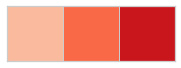

complexity
shallow -> middle -> deep


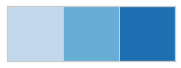

scope
small -> medium -> wide


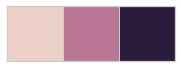

level
low -> average -> high


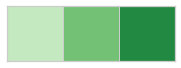

client
idea -> web


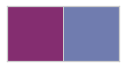

In [25]:
draw_base_attrs()

# Steps and Topics
**Step** - is a task where user is asked to write some code. Main attributes:
* `id` - *identifier of step*
* `seconds_to_complete` - *estimated secons to complete (calculated as average from all successful sumbissions)*
* `solved_by` - *number of successful sumbissions*
* `success_rate` - *number of successful sumbissions dvided by total number of sumbissions*
* `topic_id` - *id of topic step is related to. By this id we can define step's `depth` and `prerequisites_count` by related topic's `depth` and `prerequisites_count`*
* `difficulty` - [`easy`, `medium`, `hard`] *according to success_rate [sr<=0.33, 0.33<sr<0.66, sr>=0.66]*. This value is defeined in planform and calculated there for each step according this rule.
* `complexity` - [`shallow`, `middle`, `deep`] *according to topic depth [d<=2, 2<d<5, d>=5]*. Borders was selected as 0.25 and 0.75 quantiles.
* `scope` - [`small`, `medium`, `wide`] *according to prerequisites_count [pc<=6, 6<pc<42, pc>=42]*. Borders was selected as 0.25 and 0.75 quantiles.

**Topic** - is a theme or knowledge area. Every step is related to some topic. Main attributes:
* `id` - *identifier of step*
* `prerequisites` - *topics ids which must be leared before*
* `depth` - *the depth in topics tree*
* `prerequisites_count` - *number of all prerequisite topics in topics tree (subtree size)*

In [26]:
df_steps = pd.read_csv(steps_file_path)
df_steps[['id', 'success_rate', 'depth', 'prerequisites_count']].describe(percentiles=[0.25, 0.5, 0.75])

id  success_rate       depth  prerequisites_count
count    364.000000    364.000000  364.000000           364.000000
mean    9051.164835      0.486664    3.810440            18.368132
std     2709.851774      0.144660    2.118995            19.314468
min     5205.000000      0.059000    0.000000             0.000000
25%     6718.250000      0.381750    2.000000             5.000000
50%     8440.500000      0.456500    3.500000            11.000000
75%    10791.250000      0.594320    5.000000            26.000000
max    15188.000000      0.885000   10.000000            78.000000

In [27]:
df_steps['complexity'] = df_steps['depth'].apply(get_tag, scope_borders=[2, 5], labels=['shallow', 'middle', 'deep'])
df_steps['scope'] = df_steps['prerequisites_count'].apply(get_tag, scope_borders=[5, 26], labels=['small', 'medium', 'wide'])
df_steps.to_csv(steps_file_path, index=False)

## Steps statistics description

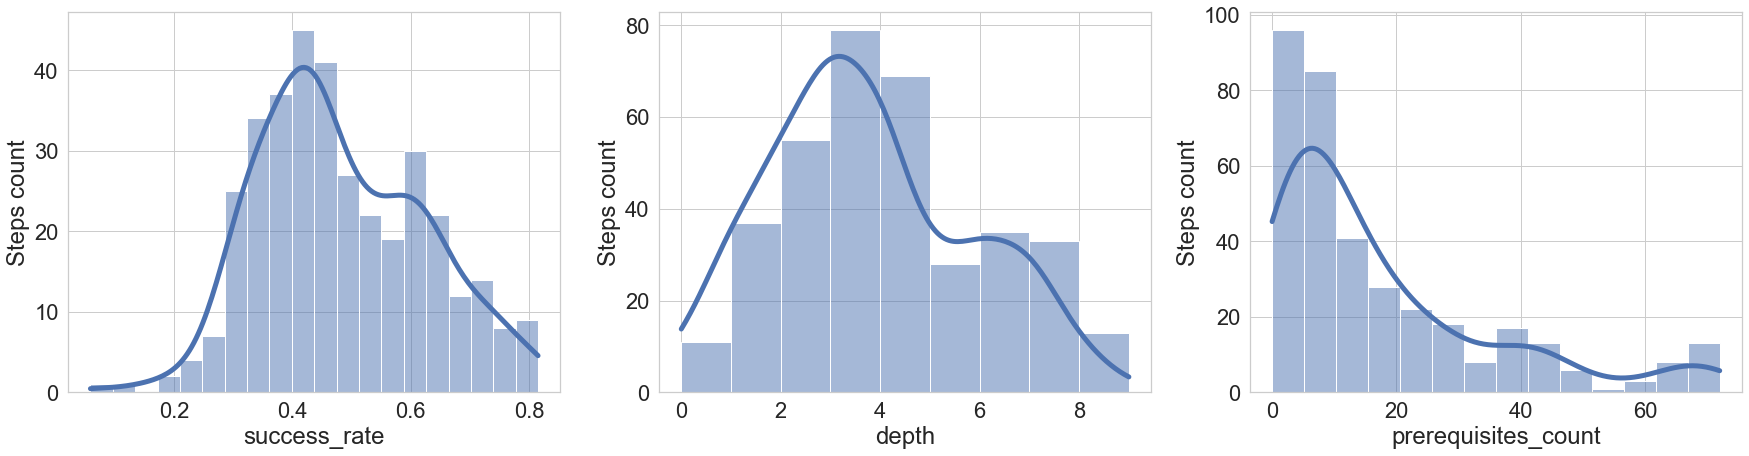

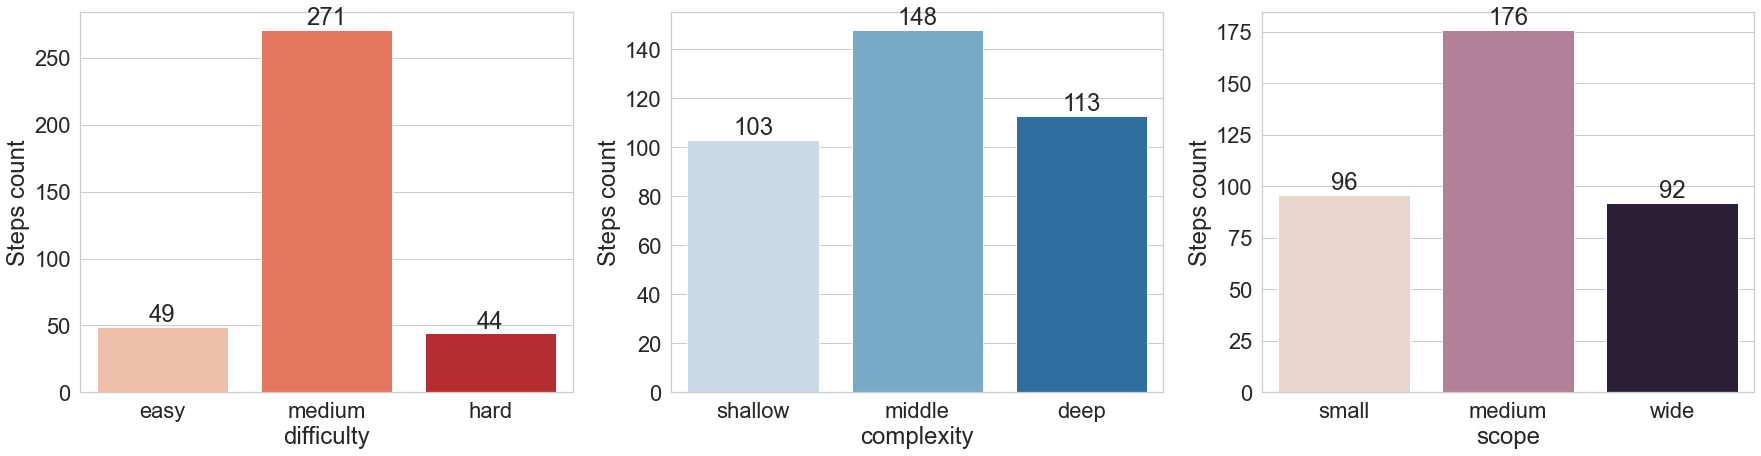

In [28]:
draw_hist_plots(df_steps, ['success_rate', 'depth', 'prerequisites_count'], 
                columns=3, log_scale=False, kde=True, y_label='Steps count')
draw_count_plots(df_steps, ['difficulty', 'complexity', 'scope'], 
                 columns=3, y_label='Steps count')

## Submissions

Submission is an attempt of user to pass step's task. One user can do several attempts to pass one step.

* `id` - *identifier of submission*
* `step_id` - *identifier of step*
* `user_id` - *identifier of user*
* `group` - *number of submission series (group of submissions on one step by one user)*
* `attempt` - *number of attempt inside submission series*
* `total_attempt` - *number of attempts is submission series*
* `base_client` - `[web, idea, ide, IdeaEdu, Idea]` *interface from which submission was submitted*
* `client` - `[web, idea]` *interface group from which submission was submitted*

In [76]:
df_submissions = pd.read_csv(submissions_file_path)
df_submissions.describe()

id       step_id  sync_counter       user_id         group  \
count  1.404532e+06  1.404532e+06  1.404532e+06  1.404532e+06  1.404532e+06   
mean   4.299687e+07  7.106596e+03  4.809562e+00  4.933600e+04  8.212245e+05   
std    7.727498e+06  1.467019e+03  1.038248e+00  1.780248e+04  4.841512e+05   
min    2.938133e+07  5.205000e+03  1.000000e+00  3.000000e+00  2.000000e+00   
25%    3.629623e+07  6.345000e+03  4.000000e+00  4.254900e+04  4.069958e+05   
50%    4.304991e+07  6.737000e+03  5.000000e+00  5.207100e+04  8.219550e+05   
75%    4.981060e+07  7.468000e+03  5.000000e+00  6.058500e+04  1.218373e+06   
max    5.639778e+07  1.518800e+04  1.900000e+01  8.240000e+04  1.722704e+06   

            attempt  total_attempts  
count  1.404532e+06    1.404532e+06  
mean   1.379840e+01    2.659679e+01  
std    1.236126e+02    2.136905e+02  
min    1.000000e+00    1.000000e+00  
25%    1.000000e+00    1.000000e+00  
50%    1.000000e+00    1.000000e+00  
75%    1.000000e+00    2.000000e+00  
max    3.347000e+03    3.347000e+03

In [77]:
total_attempt_count = {
    'total_attempts': [],
    'count<=': [],
    'count>': [],
    'percent<=': [],
    'percent>': [],
}


for total_attempt in sorted(df_submissions['total_attempts'].unique()):
    total_attempt_count['total_attempts'].append(total_attempt)
    count = df_submissions[df_submissions['total_attempts'] <= total_attempt].shape[0]
    total_attempt_count['count<='].append(count)
    total_attempt_count['count>'].append(df_submissions.shape[0] - count)
    total_attempt_count['percent<='].append(count / df_submissions.shape[0])
    total_attempt_count['percent>'].append((df_submissions.shape[0] - count) / df_submissions.shape[0])

df_total_attempt_count = pd.DataFrame.from_dict(total_attempt_count)
df_total_attempt_count.to_csv('python/total_attempts.csv', index=False)
df_total_attempt_count

total_attempts  count<=  count>  percent<=  percent>
0                 1  1010454  394078   0.719424  0.280576
1                 2  1222282  182250   0.870241  0.129759
2                 3  1297033  107499   0.923463  0.076537
3                 4  1329557   74975   0.946619  0.053381
4                 5  1345332   59200   0.957851  0.042149
..              ...      ...     ...        ...       ...
129            1352  1395804    8728   0.993786  0.006214
130            1698  1397502    7030   0.994995  0.005005
131            1739  1399241    5291   0.996233  0.003767
132            1944  1401185    3347   0.997617  0.002383
133            3347  1404532       0   1.000000  0.000000

[134 rows x 5 columns]

# Filter all submissions with > 5 total attempts

In [78]:
df_submissions = df_submissions[df_submissions['total_attempts'] <= 5]
df_submissions.describe()

id       step_id  sync_counter       user_id         group  \
count  1.345332e+06  1.345332e+06  1.345332e+06  1.345332e+06  1.345332e+06   
mean   4.292182e+07  7.089858e+03  4.810385e+00  5.065179e+04  8.429489e+05   
std    7.704249e+06  1.459950e+03  1.038372e+00  1.616353e+04  4.721067e+05   
min    2.938133e+07  5.205000e+03  2.000000e+00  3.000000e+00  2.000000e+00   
25%    3.626600e+07  6.319000e+03  4.000000e+00  4.336500e+04  4.413668e+05   
50%    4.292694e+07  6.737000e+03  5.000000e+00  5.244000e+04  8.430660e+05   
75%    4.968532e+07  7.458000e+03  5.000000e+00  6.089200e+04  1.229866e+06   
max    5.639778e+07  1.518800e+04  1.900000e+01  8.240000e+04  1.722704e+06   

            attempt  total_attempts  
count  1.345332e+06    1.345332e+06  
mean   1.194005e+00    1.388010e+00  
std    5.372738e-01    7.964588e-01  
min    1.000000e+00    1.000000e+00  
25%    1.000000e+00    1.000000e+00  
50%    1.000000e+00    1.000000e+00  
75%    1.000000e+00    1.000000e+00  
max    5.000000e+00    5.000000e+00

### Sumbission client distriburion
In platform student can use `web` indeface for typing code or `ide`.
This plot shows that around 2/3 of the sumbisssions are done in `web` indeface. 

<AxesSubplot:xlabel='client', ylabel='Count'>

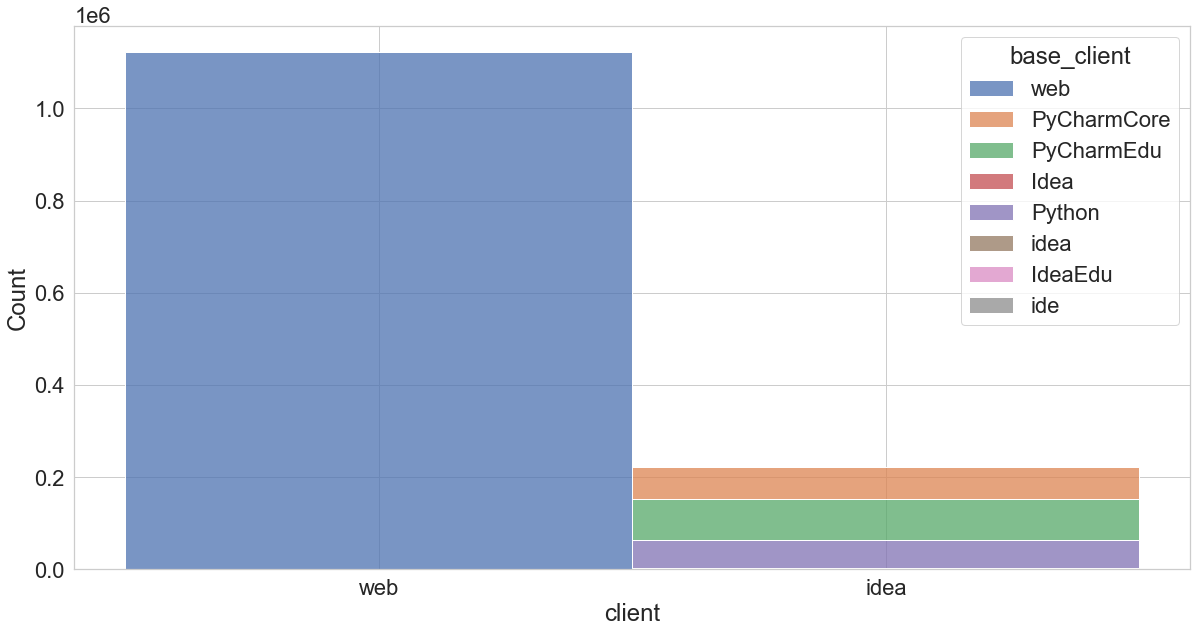

In [79]:
fig, ax = plt.subplots(figsize=((20, 10)))
sns.histplot(data=df_submissions, x='client', hue='base_client', multiple='stack')

## Submission statistics
* `code_lines_count` - number of code lines
* `code_symbols_count` - number of code symbols

In [80]:
df_submissions_stats = pd.read_csv(submissions_stats_file_path)
df_submissions_stats = df_submissions_stats[df_submissions_stats['id'].isin(df_submissions['id'])]
df_submissions_stats.describe().astype('int32')

id  code_lines_count  code_symbols_count
count   1345332           1345332             1345332
mean   42921818                 5                 119
std     7704249                 4                 116
min    29381330                 1                   8
25%    36266000                 2                  45
50%    42926943                 4                  86
75%    49685322                 7                 154
max    56397784               128                4948

In [81]:
df_submissions_stats = merge_dfs(df_submissions_stats, df_submissions, left_on='id', right_on='id')
df_submissions_stats = merge_dfs(df_submissions_stats, df_steps[['id', 'complexity', 'difficulty', 'scope']], left_on='step_id', right_on='id')

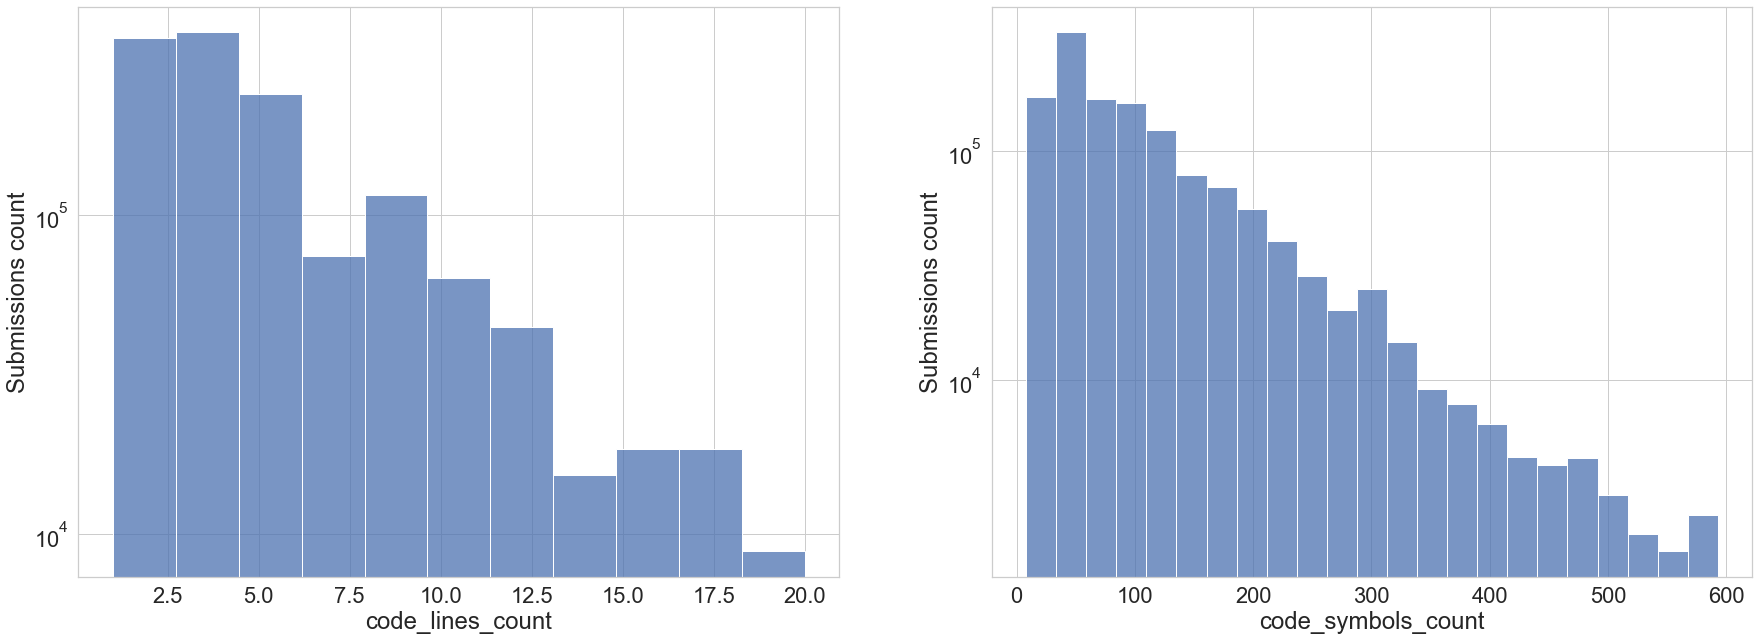

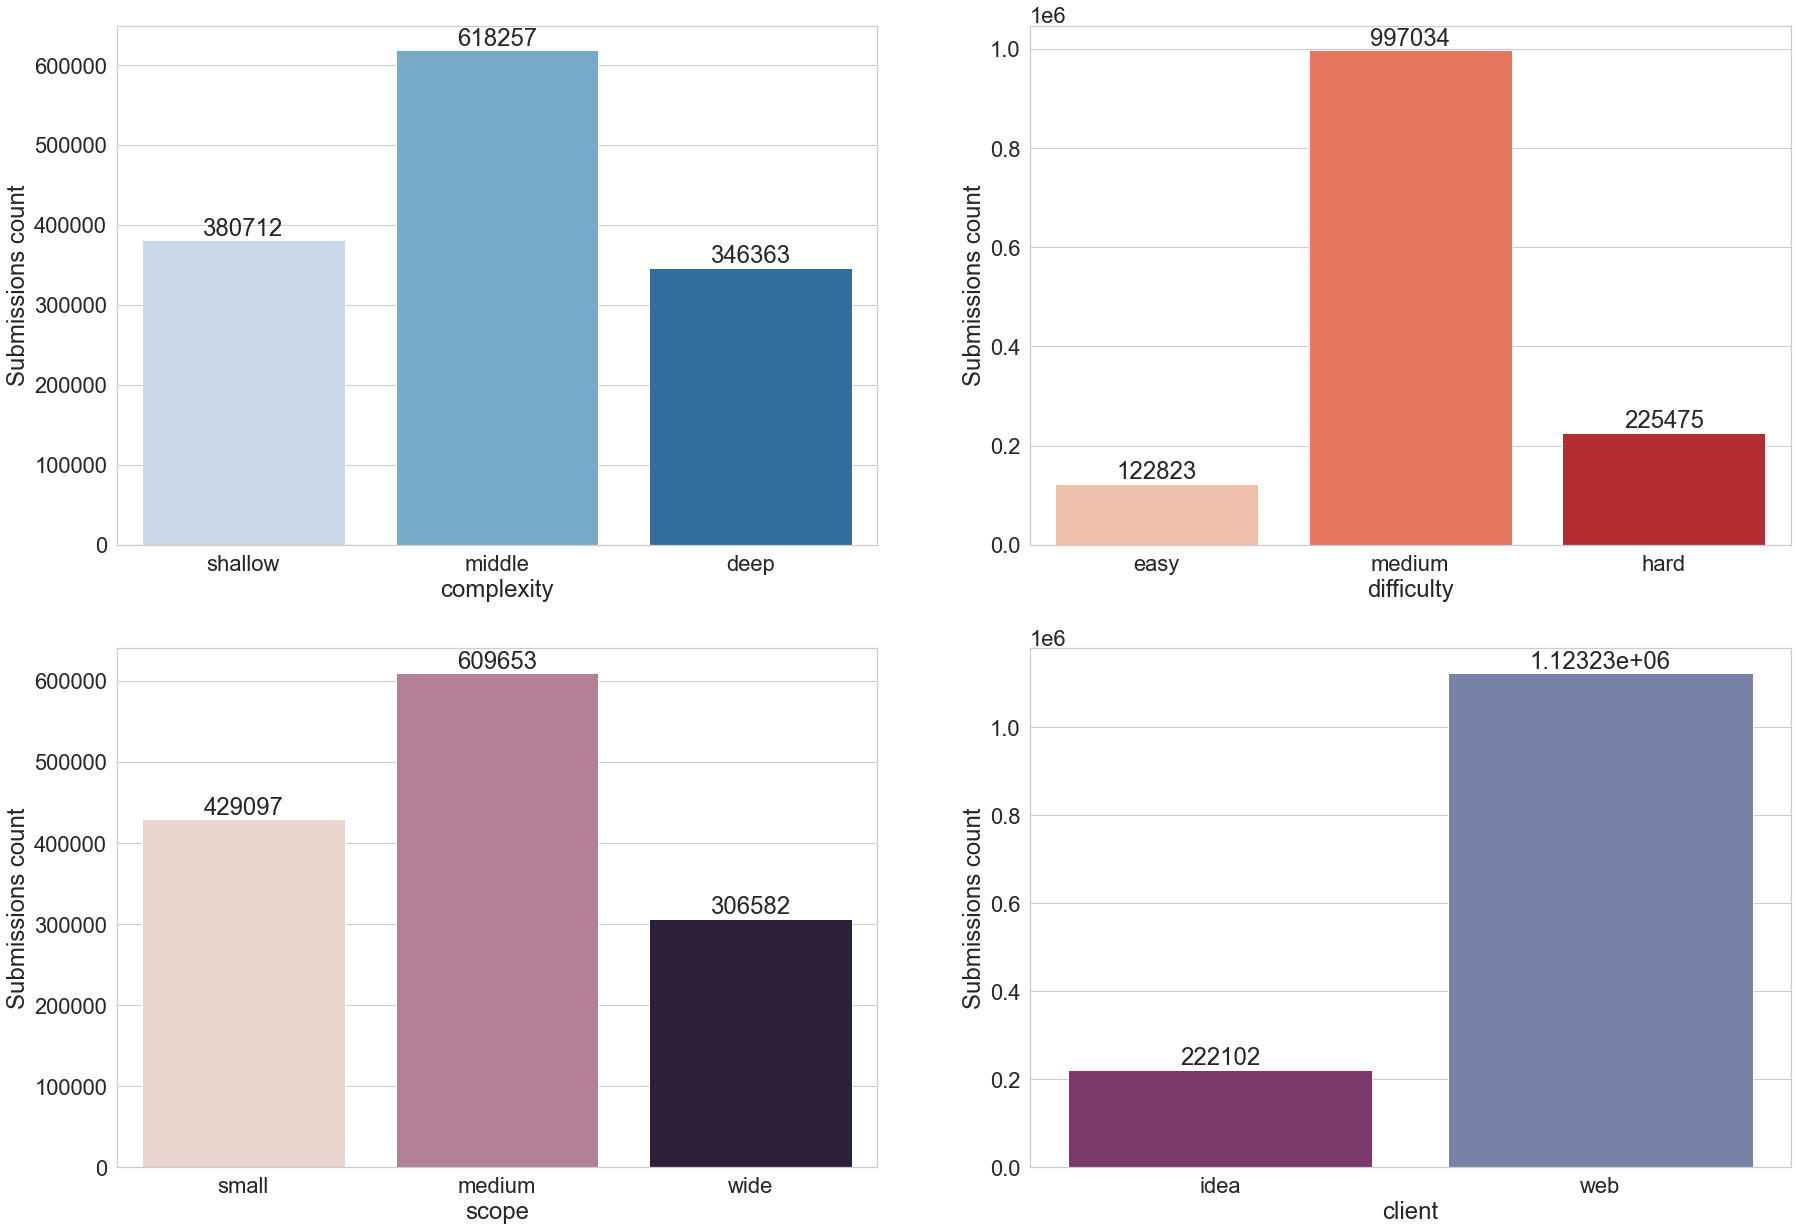

In [82]:
draw_hist_plots(df_submissions_stats, ['code_lines_count', 'code_symbols_count'], 
                columns=2, log_scale=(False, True), y_label='Submissions count')

draw_count_plots(df_submissions_stats, ['complexity', 'difficulty', 'scope', 'client'], y_label='Submissions count')

# Hyperstyle code quality issue analysis

We invoked Hyperstyle code quality tool on each submissions and got a code quality report with list of detected issues in submission `hypertyle_issues`. Hyperstyle issue is code quality error which has `name` e.x. MagicNumberCheck and `category` e.x. INFO. 

In a preprocessing part for each submission we calcaulated number of hypertyle issues of each name.

In [83]:
def draw_issues(df: pd.DataFrame, df_issues: pd.DataFrame, blur_issues, base_dir: str = 'results'):
    os.makedirs(base_dir, exist_ok=True)
    for attr in ['difficulty', 'complexity', 'client', 'scope']:
        df_stats = get_submissions_percent_by_issues(df, df_issues, attr, sort=False)
        df_stats.to_csv(os.path.join(base_dir, f'issues_stats_{attr}.csv'), index=False)
        draw_compare(df_stats, 
                     'issue', 
                     attr, blur_issues, 
                     save_path=os.path.join(base_dir, f'issues_stats_{attr}.png'))

In [84]:
df_hyperstyle_issues_stats = pd.read_csv(hyperstyle_issues_stats_file_path)
df_hyperstyle_issues_stats = df_hyperstyle_issues_stats[df_hyperstyle_issues_stats['id'].isin(df_submissions['id'])]
df_hyperstyle_issues_stats.describe()

id         SC200        WPS432          E226          E231  \
count  1.345332e+06  1.345332e+06  1.345332e+06  1.345332e+06  1.345332e+06   
mean   4.292182e+07  3.067444e-01  2.074098e-01  7.315072e-02  5.544282e-02   
std    7.704249e+06  1.518779e+00  9.498807e-01  4.859322e-01  6.908922e-01   
min    2.938133e+07  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    3.626600e+07  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    4.292694e+07  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    4.968532e+07  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
max    5.639778e+07  9.600000e+01  3.400000e+01  2.400000e+01  4.750000e+02   

               E225        WPS336          E265          E211         W0311  \
count  1.345332e+06  1.345332e+06  1.345332e+06  1.345332e+06  1.345332e+06   
mean   5.076219e-02  3.499434e-02  3.015315e-02  1.835532e-02  1.342048e-02   
std    3.895867e-01  3.372046e-01  2.503708e-01  1.958264e-01  2.572182e-01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
max    4.100000e+01  2.400000e+01  2.600000e+01  1.700000e+01  3.800000e+01   

       ...          E721        WPS311          E743         E1102      W0223  \
count  ...  1.345332e+06  1.345332e+06  1.345332e+06  1.345332e+06  1345332.0   
mean   ...  7.433109e-07  7.433109e-07  7.433109e-07  7.433109e-07        0.0   
std    ...  8.621548e-04  8.621548e-04  8.621548e-04  8.621548e-04        0.0   
min    ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00        0.0   
25%    ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00        0.0   
50%    ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00        0.0   
75%    ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00        0.0   
max    ...  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00        0.0   

             WPS522        WPS219        WPS338         R1704        WPS456  
count  1.345332e+06  1.345332e+06  1.345332e+06  1.345332e+06  1.345332e+06  
mean   7.433109e-07  7.433109e-07  7.433109e-07  7.433109e-07  7.433109e-07  
std    8.621548e-04  8.621548e-04  8.621548e-04  8.621548e-04  8.621548e-04  
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
75%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
max    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  

[8 rows x 366 columns]

In [85]:
df_hyperstyle_issues_stats = merge_dfs(df_hyperstyle_issues_stats, df_submissions_stats, left_on='id', right_on='id')

During the analysis we desided to filter out issues with `INFO` and `CODE_STYLE` categories and focude on `BEST_PRACTICES `and `ERROR_PRONE`.

In [86]:
df_hyperstyle_issues = pd.read_csv(hyperstyle_issues_classes_file_path)

hyperstyle_issues_wrong_names = ['R0801', 'WPS453', 'WPS226']
hyperstyle_issues_info_names = [issue['name'] for _, issue in df_hyperstyle_issues.iterrows() 
                                if issue['category'] == 'INFO']

hyperstyle_issues_ignore_names = [issue['name'] for _, issue in df_hyperstyle_issues.iterrows() 
                                   if issue['category'] == 'INFO' or issue['category'] == 'CODE_STYLE' or \
                                   issue['name'] in hyperstyle_issues_wrong_names]

hyperstyle_issues_names = [issue['name'] for _, issue in df_hyperstyle_issues.iterrows() 
                            if issue['name'] not in hyperstyle_issues_ignore_names
                          ]

In one submission can be several issues with one name. But it is simplier to analyse only the presence/absence on issue in solution so in `_unique` dataframe we replace issue count to 0/1 value (0-no such issue in this submission, 1-one ore more issues are detected in this submission).

In [87]:
# Unique means a flag: 1 if issue presented in submission, 0 otherwise
df_hyperstyle_issues_stats_unique = df_hyperstyle_issues_stats.copy()
for issue_name in df_hyperstyle_issues['name'].values:
    df_hyperstyle_issues_stats_unique[issue_name] = df_hyperstyle_issues_stats_unique[issue_name] \
        .apply(lambda x: min(x, 1))

In [88]:
BASE_PATH = os.path.join('python', 'hyperstyle')
IGNORE_ISSUES_STATS_PATH = os.path.join(BASE_PATH, 'ignore_issues_stats')
ISSUES_STATS_PATH = os.path.join(BASE_PATH, 'issues_stats')

FIRST_ATTEMPT_STATS_PATH = os.path.join(BASE_PATH, 'first_attempt_stats')
LAST_ATTEMPT_STATS_PATH = os.path.join(BASE_PATH, 'last_attempt_stats')
FIRST_LAST_ATTEMPT_STATS_PATH = os.path.join(BASE_PATH, 'first_last_attempt_stats')

ISSUES_DYNAMIC_STATS_PATH = os.path.join(BASE_PATH, 'issues_dynamic_stats')


os.makedirs(BASE_PATH, exist_ok=True)
os.makedirs(IGNORE_ISSUES_STATS_PATH, exist_ok=True)
os.makedirs(ISSUES_STATS_PATH, exist_ok=True)
os.makedirs(FIRST_ATTEMPT_STATS_PATH, exist_ok=True)
os.makedirs(LAST_ATTEMPT_STATS_PATH, exist_ok=True)
os.makedirs(FIRST_LAST_ATTEMPT_STATS_PATH, exist_ok=True)
os.makedirs(ISSUES_DYNAMIC_STATS_PATH, exist_ok=True)

### List and analysis of ignored (filtered) issues (with CODE_STYLE and INFO categories)

In [89]:
df_hyperstyle_ignore_issues_top = get_top_issues(df_hyperstyle_issues_stats_unique, 
                                                 df_hyperstyle_issues, 
                                                 20, 
                                                 hyperstyle_issues_names)
df_hyperstyle_ignore_issues_top.to_csv(os.path.join(IGNORE_ISSUES_STATS_PATH, f'top_issues.csv'), index=False)
df_hyperstyle_ignore_issues_top

name   count    category  \
1   WPS432  123156        INFO   
0    SC200   87958        INFO   
2     E226   55793  CODE_STYLE   
4     E225   39498  CODE_STYLE   
3     E231   31923  CODE_STYLE   
6     E265   20939  CODE_STYLE   
7     E211   18320  CODE_STYLE   
14    E202    8893  CODE_STYLE   
28   C0305    7678  CODE_STYLE   
19    E201    7581  CODE_STYLE   
12    E203    7513  CODE_STYLE   
20    E228    7058  CODE_STYLE   
8    W0311    6861  CODE_STYLE   
22  WPS350    6825  CODE_STYLE   
23   C0325    5820  CODE_STYLE   
29    E262    5326  CODE_STYLE   
32    E261    4192  CODE_STYLE   
36    E501    3979  CODE_STYLE   
18    E251    3110  CODE_STYLE   
34    N816    3056  CODE_STYLE   

                                                 text difficulty  \
1   Found magic number: 1234567890. The use of unn...       EASY   
0                      Possibly misspelt word: 'num1'       EASY   
2       missing whitespace around arithmetic operator       EASY   
4                  missing whitespace around operator       EASY   
3                        missing whitespace after ','       EASY   
6                block comment should start with '# '       EASY   
7                               whitespace before '('       EASY   
14                              whitespace before ')'       EASY   
28                                  Trailing newlines       EASY   
19                               whitespace after '{'       EASY   
12                              whitespace before ':'       EASY   
20          missing whitespace around modulo operator       EASY   
8         Bad indentation. Found 7 spaces, expected 8       EASY   
22              Found usable augmented assign pattern       EASY   
23              Unnecessary parens after 'if' keyword       EASY   
29              inline comment should start with '# '       EASY   
32          at least two spaces before inline comment       EASY   
36  Too long line. Try to split it into smaller li...       EASY   
18  unexpected spaces around keyword / parameter e...       EASY   
34  variable 'marks_A' in global scope should not ...       EASY   

                                          code_sample     ratio  
1   print((1234567890 * 987654321) + 67890) # WPS4...  0.091543  
0   num1 = int(input()) # SC200 line=1 offset=1\nn...  0.065380  
2   # put your python code here\nmarks = input()\n...  0.041472  
4   # Make sure your output matches the assignment...  0.029359  
3   import math\n\nn = int(input())\nlist = []\ni ...  0.023729  
6   #print(1 + 2 + 3 + 6) # E265 line=1 offset=1\n...  0.015564  
7   input1 = int(input(""))\ninput2 = int(input(""...  0.013617  
14  # put your python code here\nnumber = int(inpu...  0.006610  
28  class Person:\n    def __init__(self, name):\n...  0.005707  
19  HAND_COUNT = 6\n\nface_cards = { 'Ace': "14", ...  0.005635  
12  # the list with classes; please, do not modify...  0.005584  
20                 print(10%3) # E228 line=1 offset=9  0.005246  
8   num1, num2, op = float(input()), float(input()...  0.005100  
22  # put your python code here\nsquare = 0\nsum =...  0.005073  
23  n = int(input())\nprime = True\n\nif n <= 1:\n...  0.004326  
29  #create a variable x\n#with the value 8\nx = 8...  0.003959  
32  data = input()\nprint(data) # put your python ...  0.003116  
36  column = int(input())\nrow = int(input())\n# p...  0.002958  
18  class Person:\n    def __init__(self, name):\n...  0.002312  
34  # put your python code here\nmarks = input()\n...  0.002272

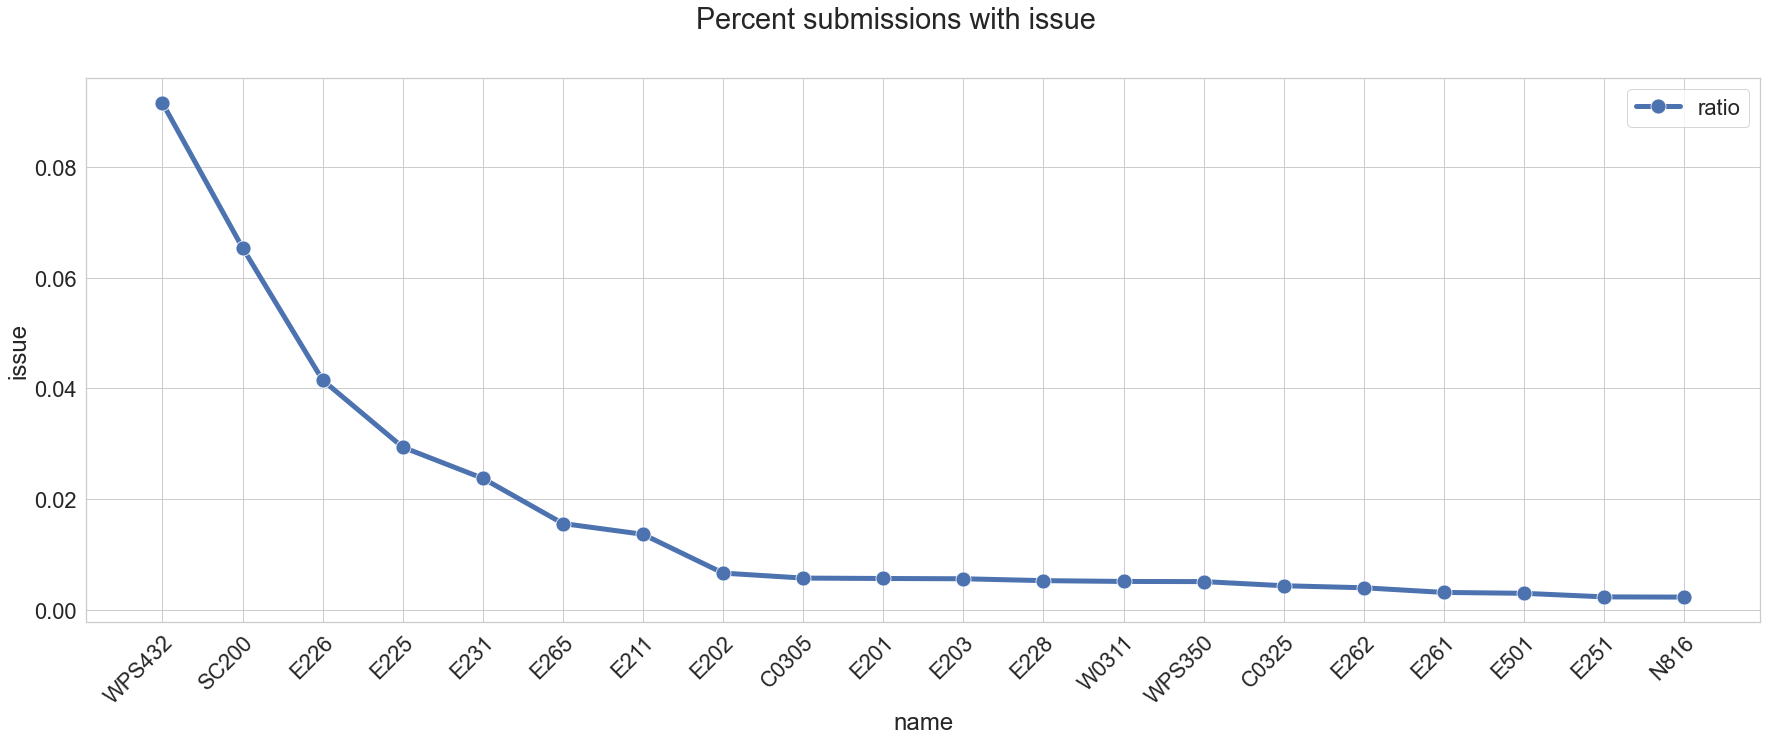

In [90]:
draw_compare(df_hyperstyle_ignore_issues_top, 'name', ['ratio', ['ratio']], 
             y_label='issue', 
             title='Percent submissions with issue', 
             save_path=os.path.join(IGNORE_ISSUES_STATS_PATH, f'top_issues.pdf'))

### Persent of submissions which contains each code quality `ignored` issue 

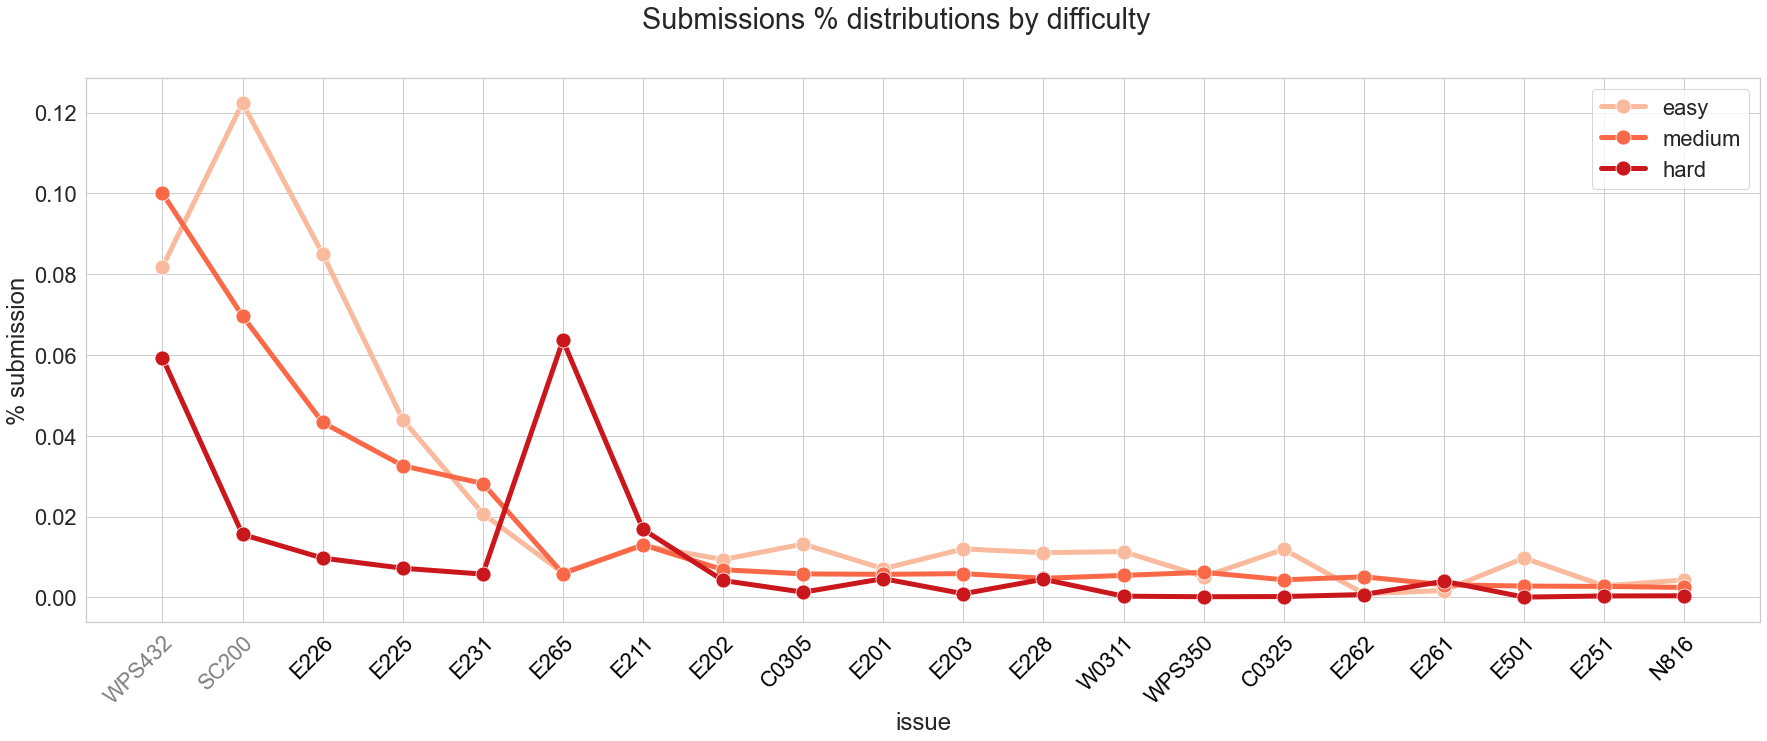

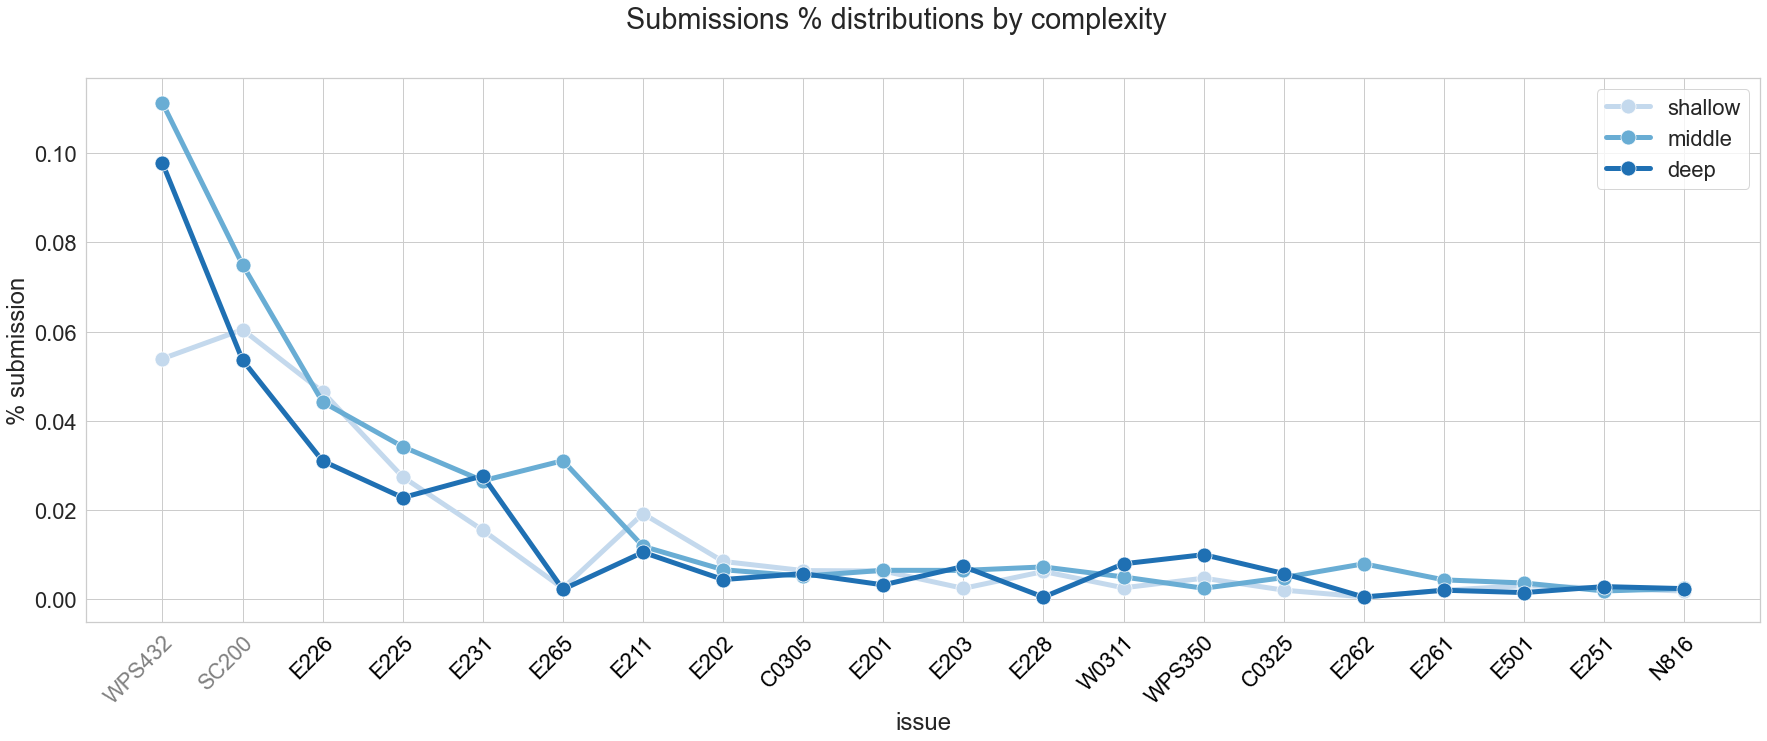

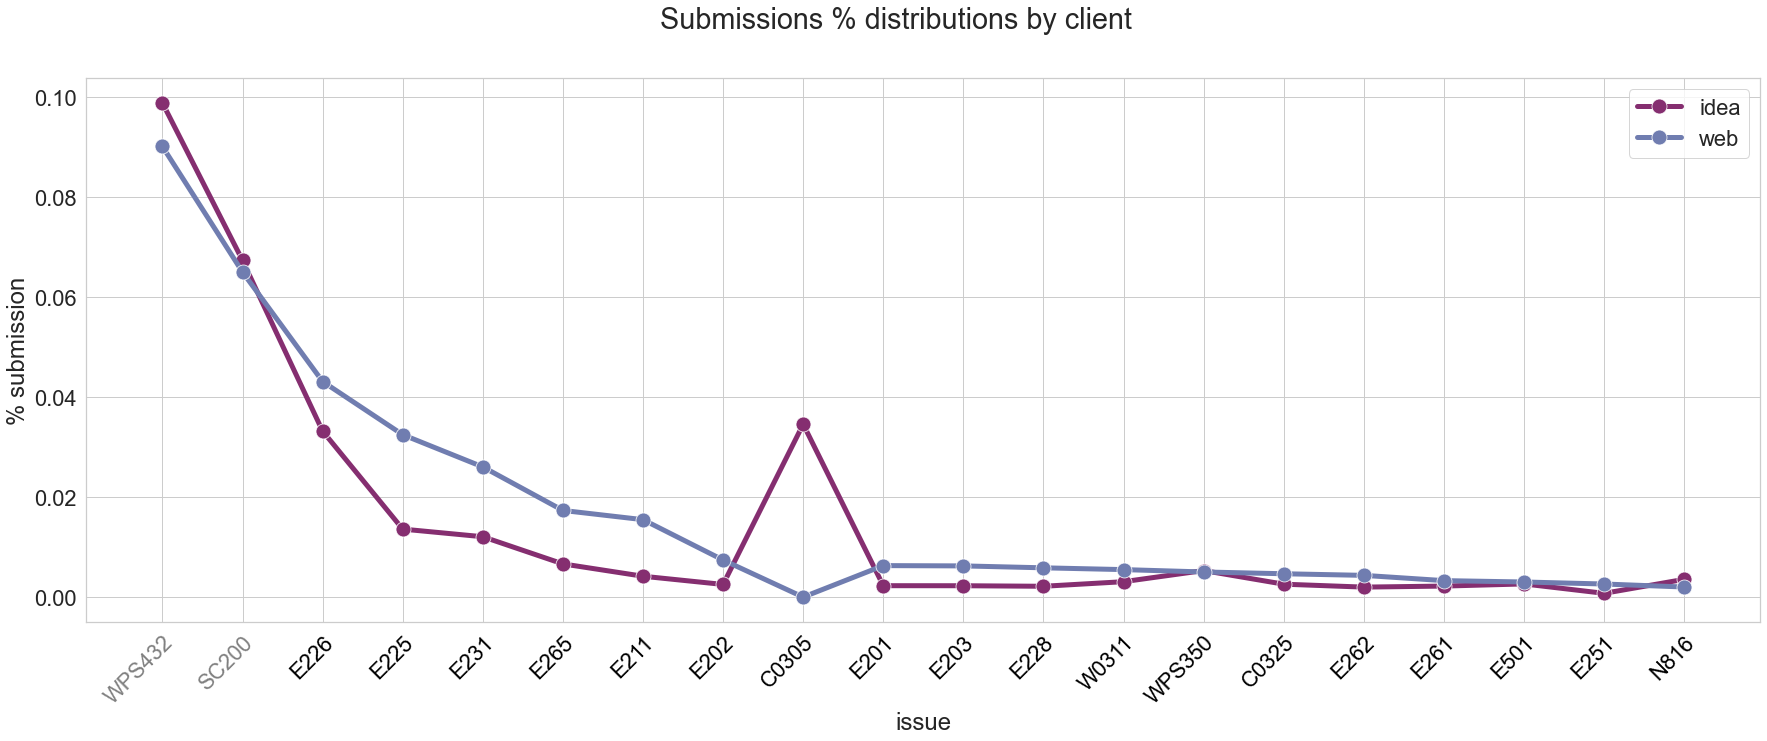

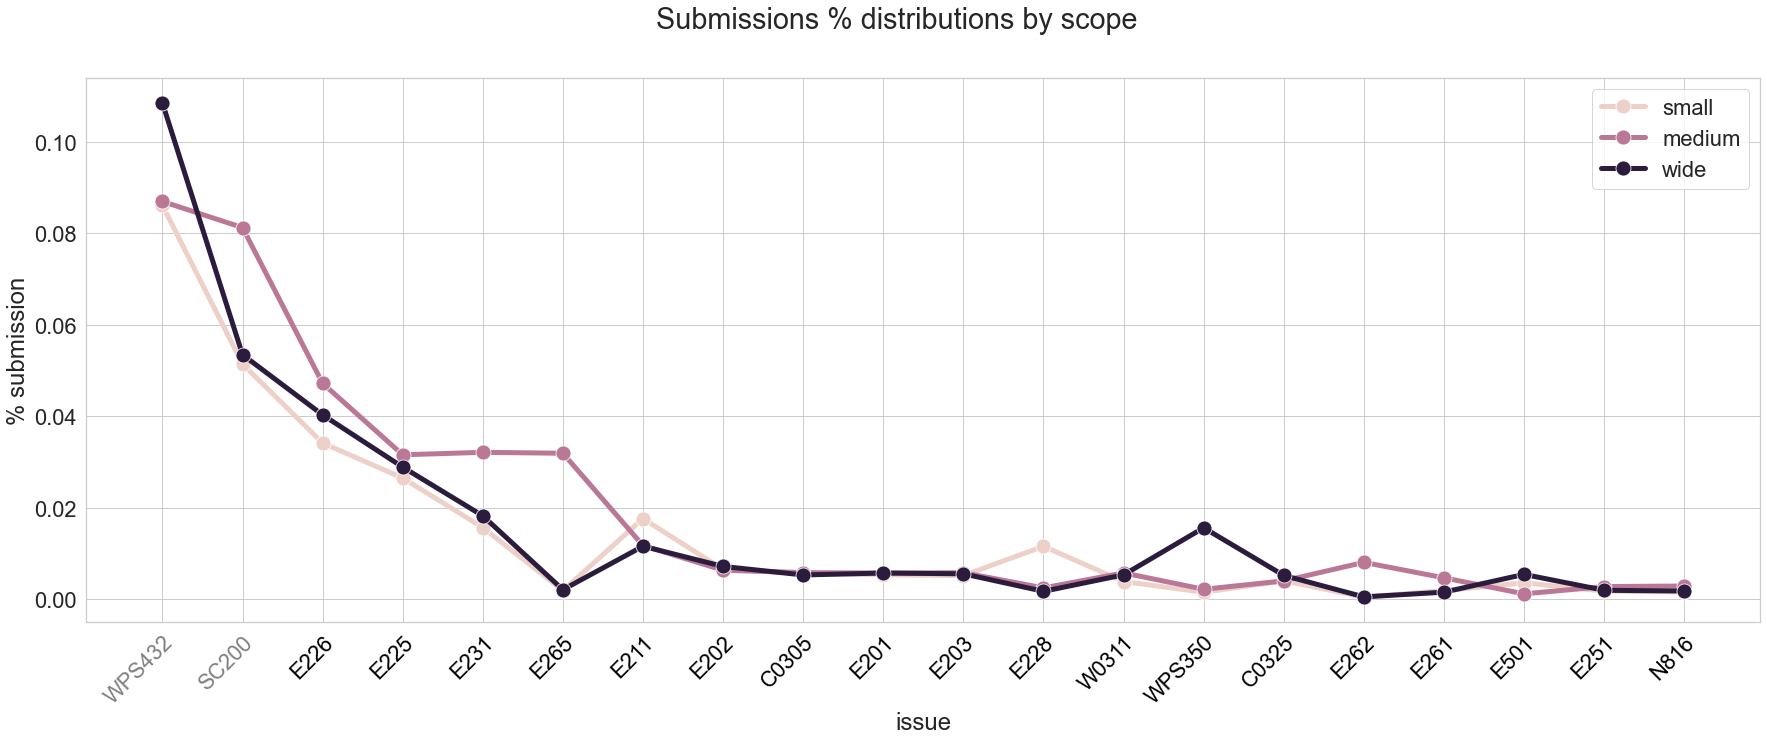

In [91]:
draw_issues(df_hyperstyle_issues_stats_unique, 
            df_hyperstyle_ignore_issues_top, 
            hyperstyle_issues_info_names,
            base_dir=IGNORE_ISSUES_STATS_PATH)

### List and analysis of interesting issues (ERROR_PRONE and BEST_PRACTICES categories)
In further analysis we will consider only top 20 issues with only `ERROR_PRONE` and `BEST_PRACTICES` catecories, other issues are ignored

In [92]:
df_hyperstyle_issues_top = get_top_issues(df_hyperstyle_issues_stats_unique, 
                                          df_hyperstyle_issues, 
                                          20, 
                                          hyperstyle_issues_ignore_names)

df_hyperstyle_issues_top.to_csv(os.path.join(ISSUES_STATS_PATH, f'top_issues.csv'), index=False)
df_hyperstyle_issues_top

name  count        category  \
5   WPS336  32062  BEST_PRACTICES   
10  WPS446  17202  BEST_PRACTICES   
9   WPS223  16584      COMPLEXITY   
11  WPS462  15740  BEST_PRACTICES   
17    B007  10546  BEST_PRACTICES   
16    A001   9885     ERROR_PRONE   
13   R1716   8927  BEST_PRACTICES   
21  WPS345   8188  BEST_PRACTICES   
15  WPS237   8063      COMPLEXITY   
24  WPS519   7914  BEST_PRACTICES   
27  WPS504   5983  BEST_PRACTICES   
31  WPS440   5185     ERROR_PRONE   
35  WPS342   5153  BEST_PRACTICES   
33   C0200   4830  BEST_PRACTICES   
38    C901   4210      COMPLEXITY   
30   W0621   3543  BEST_PRACTICES   
25  WPS459   3106  BEST_PRACTICES   
39  WPS507   3037  BEST_PRACTICES   
46  WPS530   3022  BEST_PRACTICES   
57  WPS447   2710  BEST_PRACTICES   

                                                 text difficulty  \
5                 Found explicit string concatenation     MEDIUM   
10                   Found approximate constant: 2.71     MEDIUM   
9               Found too many `elif` branches: 7 > 3       HARD   
11                       Wrong multiline string usage     MEDIUM   
17  Loop control variable 'i' not used within the ...     MEDIUM   
16       variable "str" is shadowing a python builtin       HARD   
13   Simplify chained comparison between the operands     MEDIUM   
21                 Found meaningless number operation     MEDIUM   
15                     Found a too complex `f` string       HARD   
24                        Found implicit `sum()` call     MEDIUM   
27                            Found negated condition     MEDIUM   
31                   Found block variables overlap: i       HARD   
35                  Found implicit raw string: "\\\\"     MEDIUM   
33  Consider using enumerate instead of iterating ...     MEDIUM   
38  Too complex function. You can figure out how t...       HARD   
30  Redefining name 'title' from outer scope (line 9)     MEDIUM   
25      Found comparison with float or complex number     MEDIUM   
39                      Found useless `len()` compare     MEDIUM   
46                      Found implicit negative index     MEDIUM   
57  Found alphabet as strings: abcdefghijklmnopqrs...     MEDIUM   

                                          code_sample     ratio  
5   name = input()\nprint("Hello, " + name) # WPS3...  0.023832  
10  print(type("int"))\nprint(type(394))\nprint(ty...  0.012786  
9   num1, num2, op = float(input()), float(input()...  0.012327  
11  print("""' '' ''' # WPS462 line=1 offset=6\n' ...  0.011700  
17  n = int(input())\n\nfor i in range(n): # B007 ...  0.007839  
16  # put your python code here\nstr = input() # A...  0.007348  
13  num = float(input())\n\nif num < 2:\n    print...  0.006636  
21              print(1*2*3) # WPS345 line=1 offset=7  0.006086  
15  word = input()\nprint(f"{word} has {len(word)}...  0.005993  
24  # put your code here\nn = input()\nresult = 0\...  0.005883  
27  A =eval(input(""))\nB = eval(input(""))\nres =...  0.004447  
31  n = int(input())\n\nmy_stack = []\nmy_stack2 =...  0.003854  
35             print("\\\\") # WPS342 line=1 offset=7  0.003830  
33  inp = input()\nfor i in range(len(inp)): # C02...  0.003590  
38  string = input()\nfor c in string: # C901 line...  0.003129  
30  class Painting:\n    musuem = "Louvre"\n    \n...  0.002634  
25  def compare(numerator, denominator):\n    retu...  0.002309  
39  numbers = input().split()\nnumber = input()\np...  0.002257  
46  sentence = input()\nprint(sentence[len(sentenc...  0.002246  
57  alphabet = 'abcdefghijklmnopqrstuvwxyz' # WPS4...  0.002014

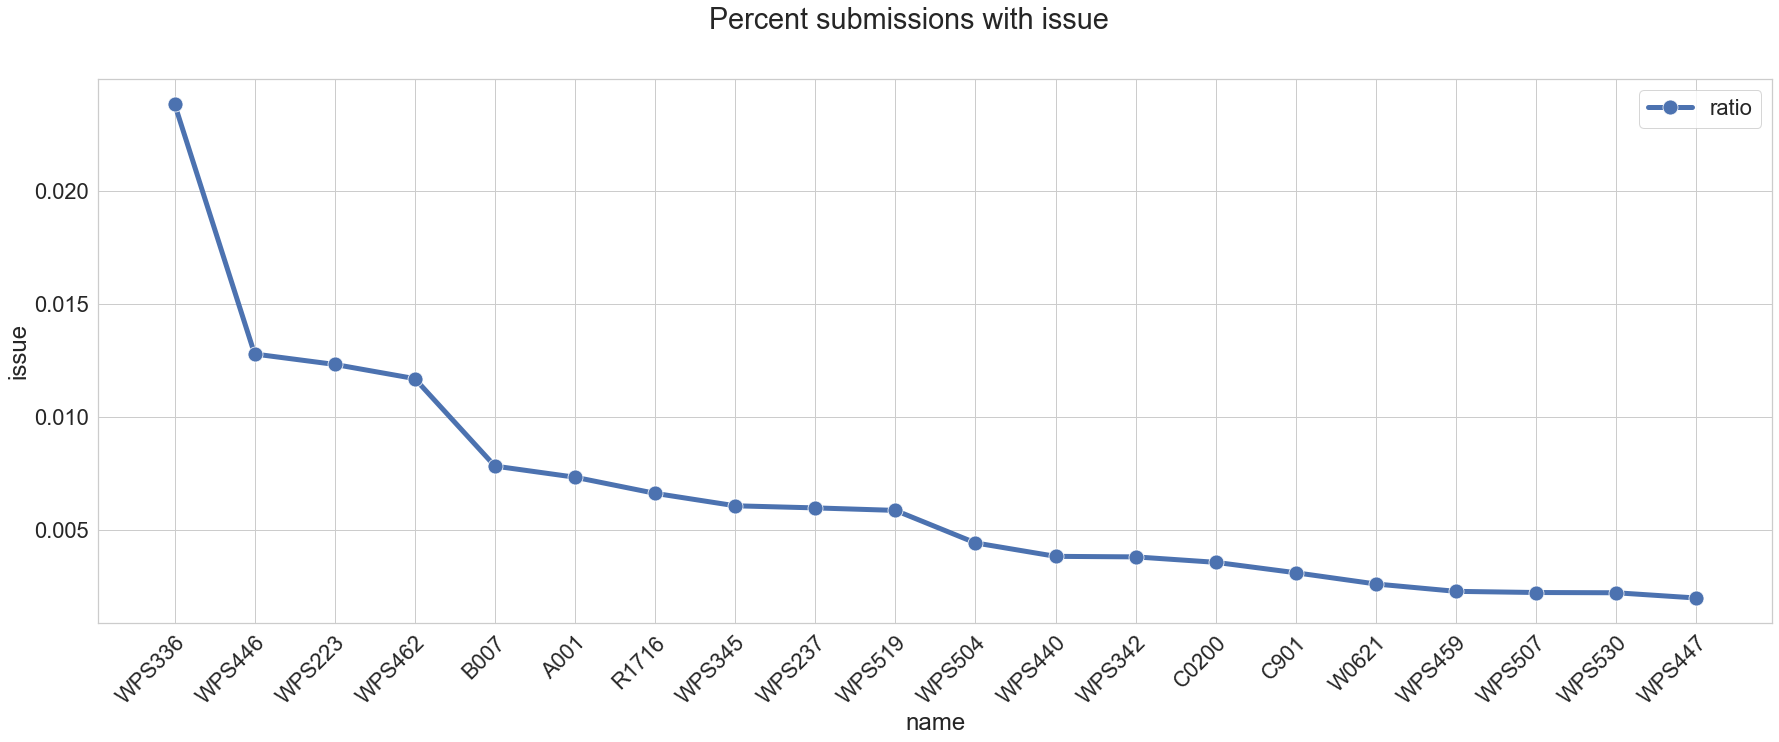

In [93]:
draw_compare(df_hyperstyle_issues_top, 'name', ['ratio', ['ratio']], 
             y_label='issue', 
             title='Percent submissions with issue', 
             save_path=os.path.join(ISSUES_STATS_PATH, f'top_issues.pdf'))

### Percent of all submissions which contain each hyperstyle issue

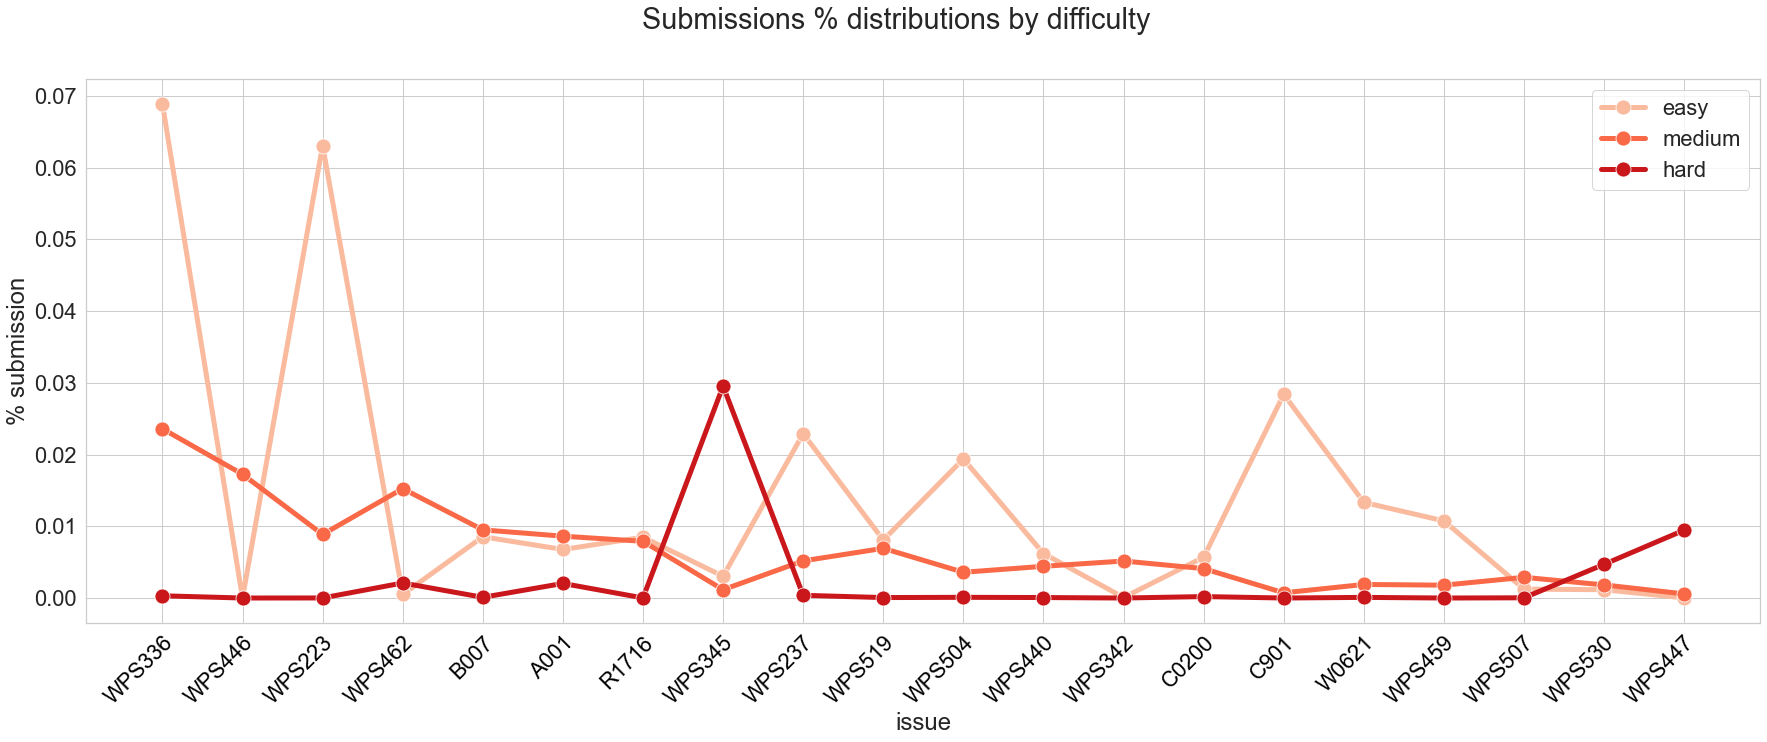

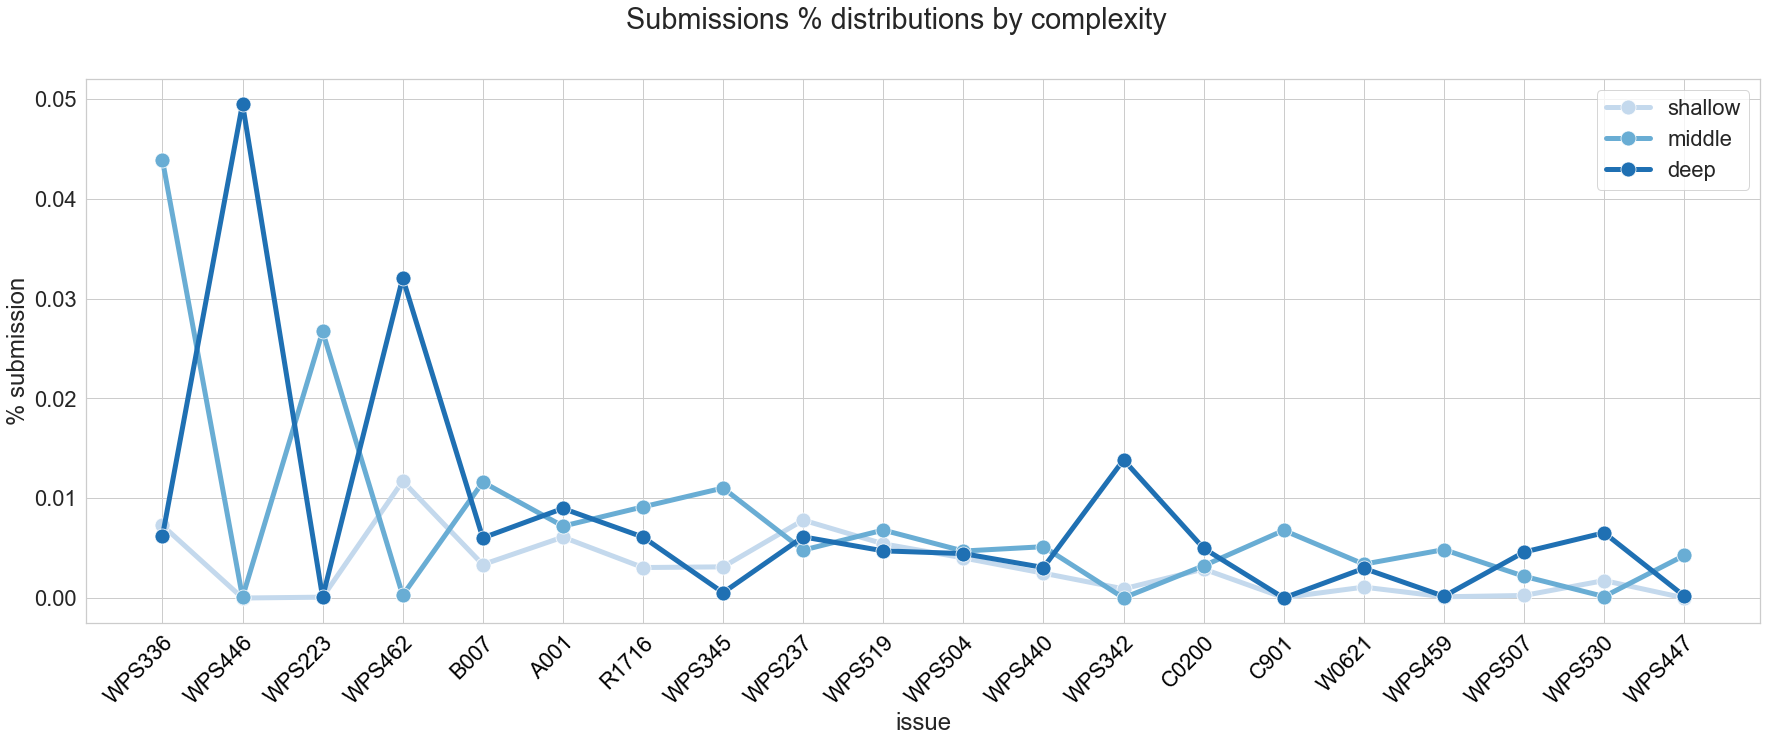

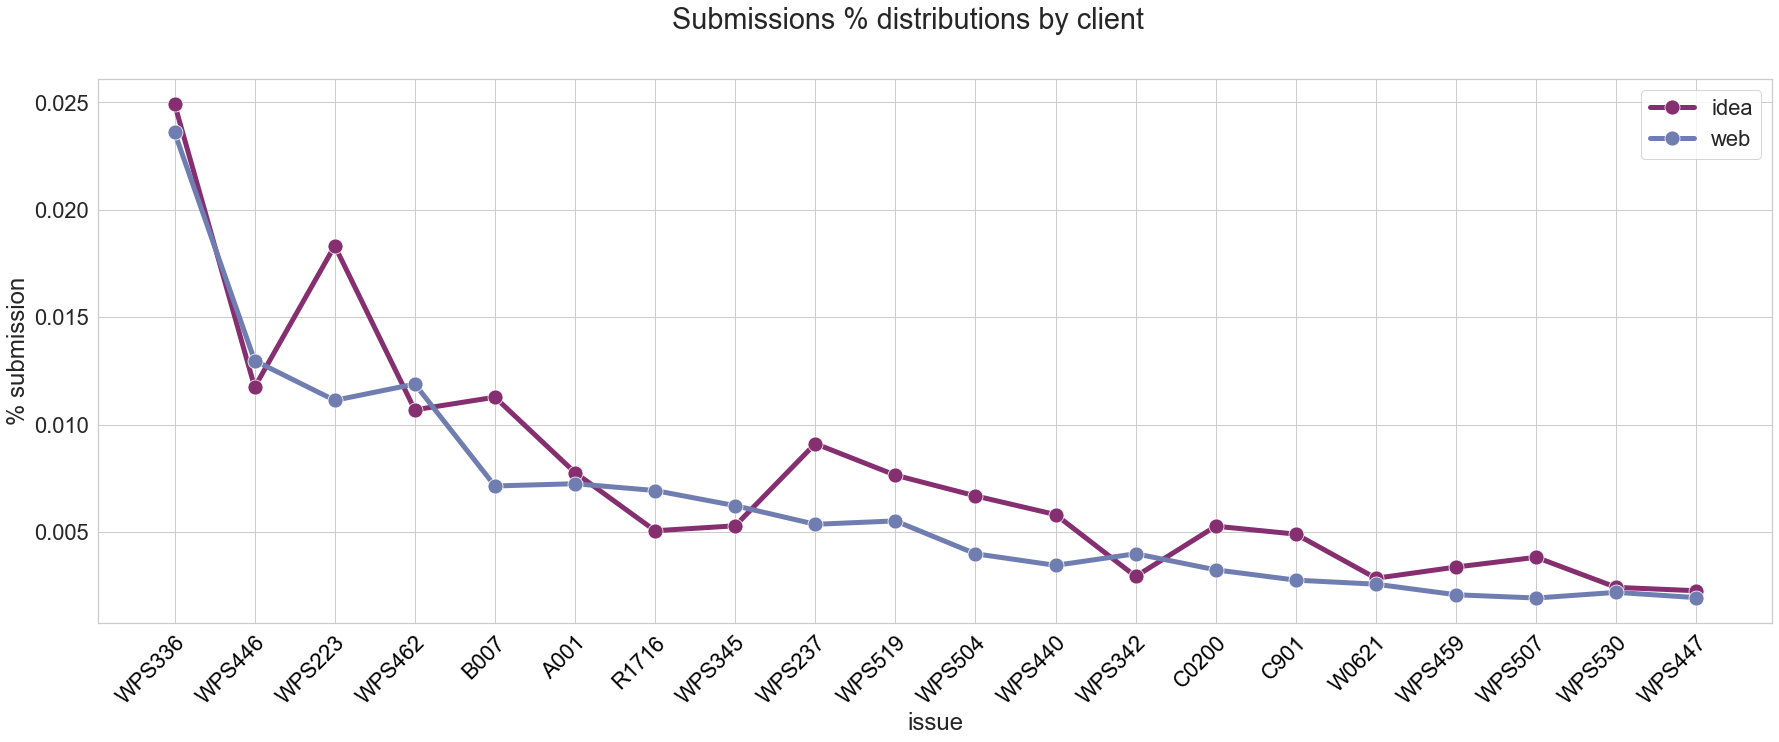

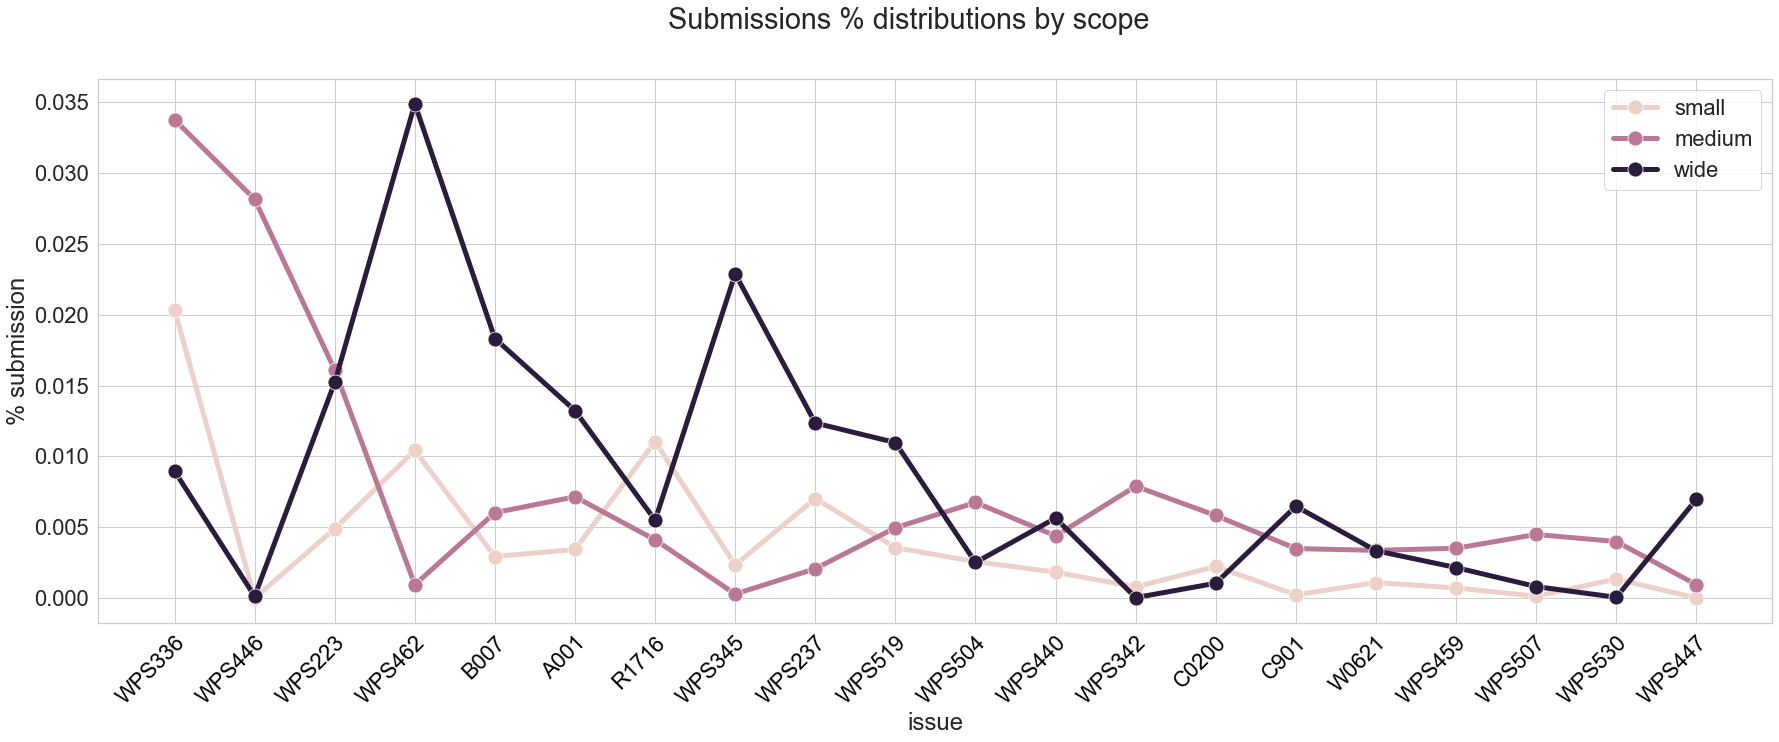

In [94]:
draw_issues(df_hyperstyle_issues_stats_unique, 
            df_hyperstyle_issues_top, 
            hyperstyle_issues_info_names,
            base_dir=ISSUES_STATS_PATH)

# First attempt stats
First attempt submissions is when **attempt** == 1. This is the most interesting case as student do not see code quality feedback before so 1-st attempt shows the exact level of sudent code quality without any hints.

In [95]:
df_first_attempt_stats = df_submissions_stats[df_submissions_stats['attempt'] == 1]
df_first_attempt_stats.describe()

id  code_lines_count  code_symbols_count       step_id  \
count  1.152571e+06      1.152571e+06        1.152571e+06  1.152571e+06   
mean   4.293496e+07      5.043828e+00        1.127612e+02  7.059959e+03   
std    7.678092e+06      4.248719e+00        1.112675e+02  1.465047e+03   
min    2.938133e+07      1.000000e+00        8.000000e+00  5.205000e+03   
25%    3.633995e+07      2.000000e+00        4.400000e+01  6.261000e+03   
50%    4.294084e+07      4.000000e+00        7.900000e+01  6.733000e+03   
75%    4.968335e+07      7.000000e+00        1.440000e+02  7.199000e+03   
max    5.639778e+07      1.280000e+02        4.948000e+03  1.518800e+04   

       sync_counter       user_id         group    attempt  total_attempts  
count  1.152571e+06  1.152571e+06  1.152571e+06  1152571.0    1.152571e+06  
mean   4.772035e+00  5.055958e+04  8.404356e+05        1.0    1.167244e+00  
std    1.022150e+00  1.620300e+04  4.716168e+05        0.0    5.076292e-01  
min    2.000000e+00  3.000000e+00  2.000000e+00        1.0    1.000000e+00  
25%    4.000000e+00  4.333300e+04  4.402585e+05        1.0    1.000000e+00  
50%    5.000000e+00  5.238600e+04  8.403140e+05        1.0    1.000000e+00  
75%    5.000000e+00  6.080600e+04  1.227026e+06        1.0    1.000000e+00  
max    1.900000e+01  8.240000e+04  1.722704e+06        1.0    5.000000e+00

### First attempt statistics

In [96]:
df_first_attempt_hyperstyle_issues_stats = \
    merge_dfs(df_first_attempt_stats, df_hyperstyle_issues_stats, left_on='id', right_on='id')
df_first_attempt_hyperstyle_issues_stats_unique = \
    merge_dfs(df_first_attempt_stats, df_hyperstyle_issues_stats_unique, left_on='id', right_on='id')

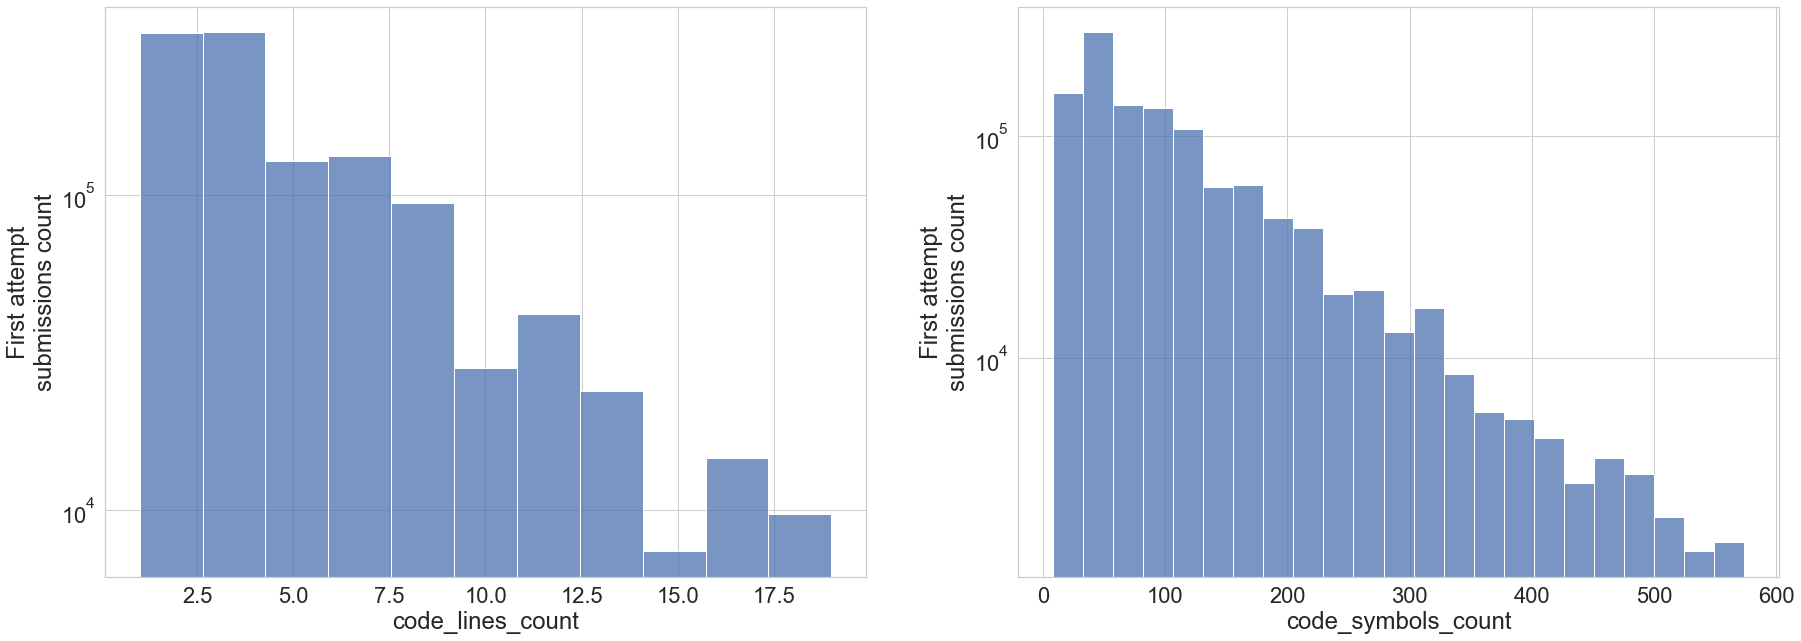

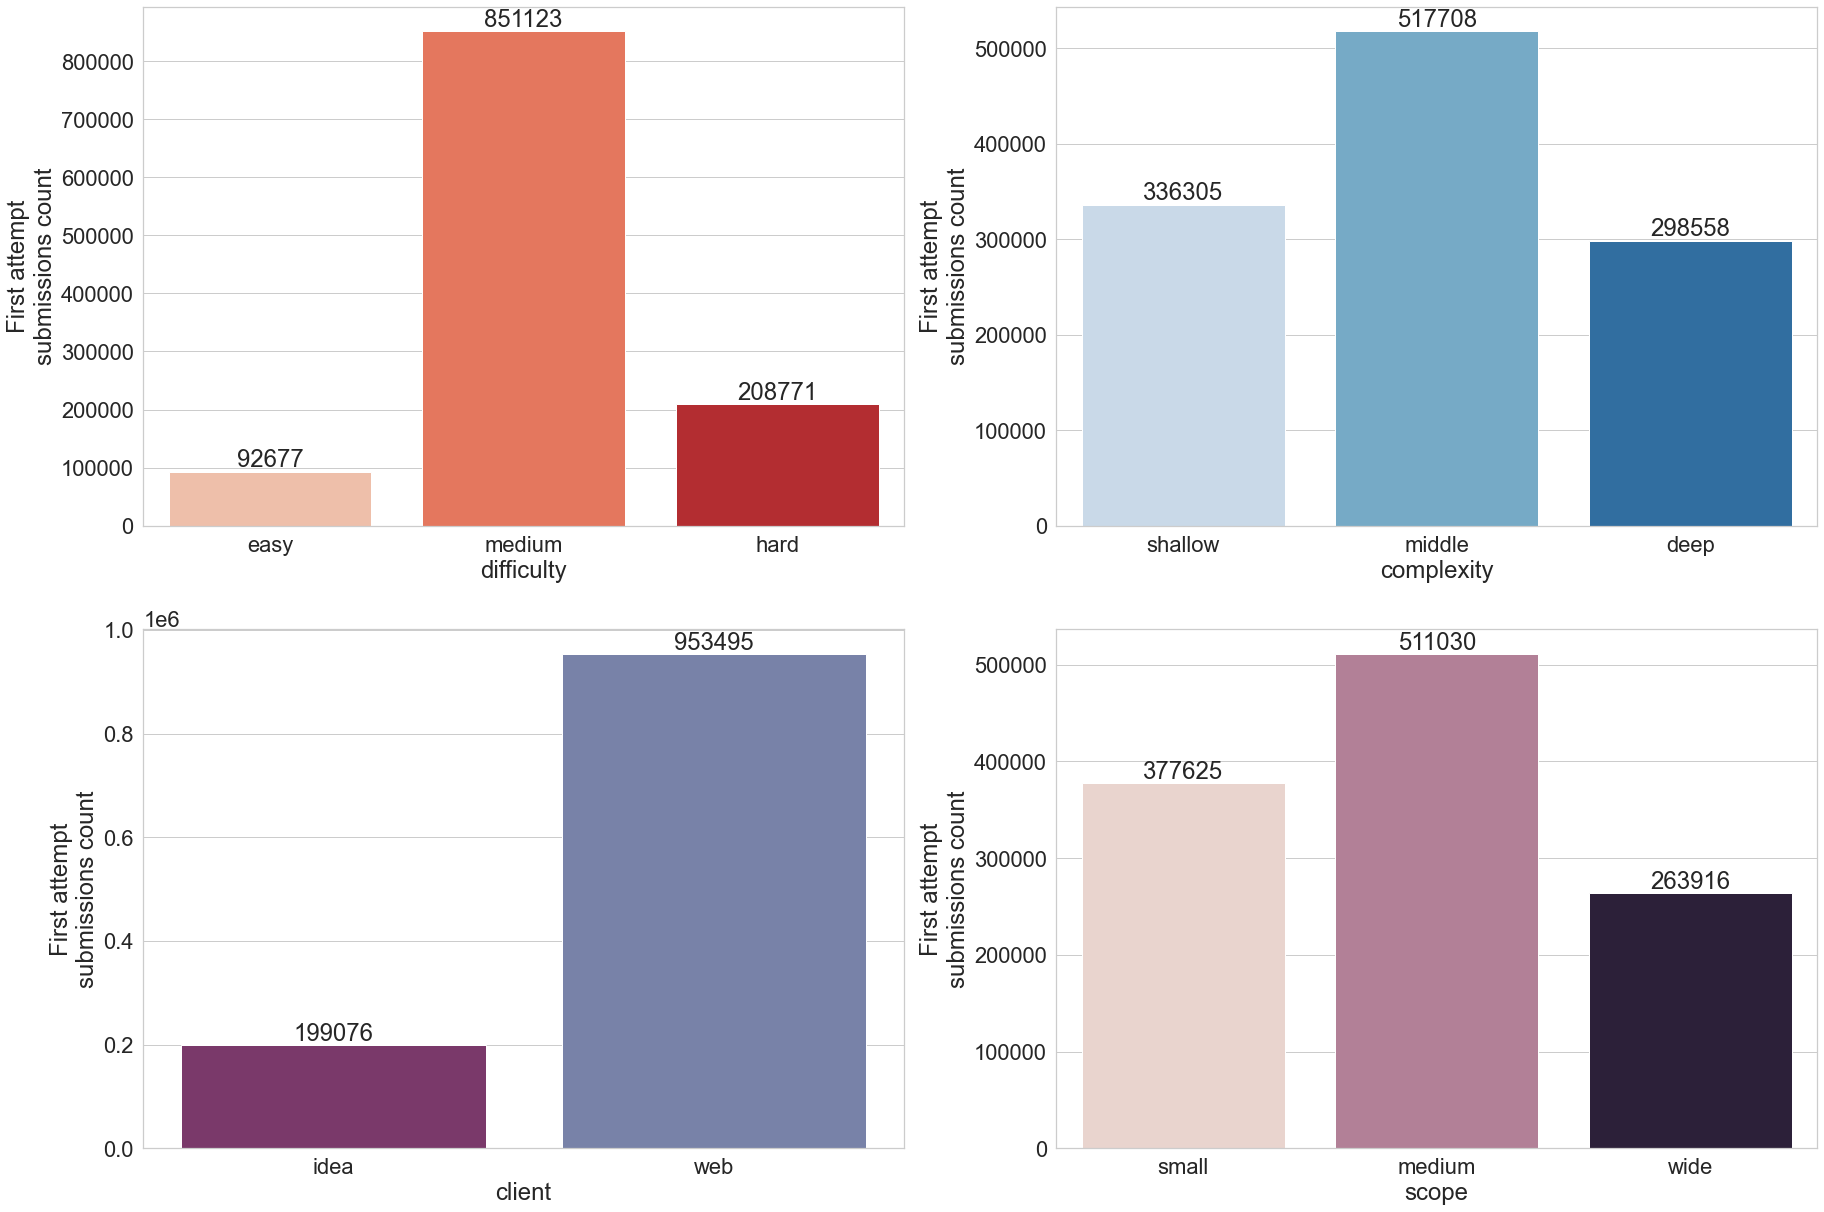

In [97]:
draw_hist_plots(df_first_attempt_hyperstyle_issues_stats, ['code_lines_count', 'code_symbols_count'], 
                log_scale=(False, True), y_label='First attempt\nsubmissions count')

draw_count_plots(df_first_attempt_hyperstyle_issues_stats, ['difficulty', 'complexity', 'client', 'scope'], 
                 y_label='First attempt\nsubmissions count')

In [98]:
df_first_attempt_hyperstyle_issues_top = get_top_issues(df_first_attempt_hyperstyle_issues_stats_unique, 
                                          df_hyperstyle_issues, 
                                          20, 
                                          hyperstyle_issues_ignore_names)

df_first_attempt_hyperstyle_issues_top.to_csv(os.path.join(FIRST_ATTEMPT_STATS_PATH, f'top_issues.csv'), index=False)
df_first_attempt_hyperstyle_issues_top

name  count        category  \
5   WPS336  25061  BEST_PRACTICES   
10  WPS446  16650  BEST_PRACTICES   
11  WPS462  14905  BEST_PRACTICES   
9   WPS223  11579      COMPLEXITY   
17    B007   8333  BEST_PRACTICES   
16    A001   7881     ERROR_PRONE   
21  WPS345   6832  BEST_PRACTICES   
13   R1716   6811  BEST_PRACTICES   
15  WPS237   6462      COMPLEXITY   
24  WPS519   5400  BEST_PRACTICES   
35  WPS342   4750  BEST_PRACTICES   
27  WPS504   4361  BEST_PRACTICES   
31  WPS440   3715     ERROR_PRONE   
33   C0200   3655  BEST_PRACTICES   
38    C901   2947      COMPLEXITY   
30   W0621   2742  BEST_PRACTICES   
57  WPS447   2416  BEST_PRACTICES   
25  WPS459   2238  BEST_PRACTICES   
46  WPS530   2231  BEST_PRACTICES   
39  WPS507   2165  BEST_PRACTICES   

                                                 text difficulty  \
5                 Found explicit string concatenation     MEDIUM   
10                   Found approximate constant: 2.71     MEDIUM   
11                       Wrong multiline string usage     MEDIUM   
9               Found too many `elif` branches: 7 > 3       HARD   
17  Loop control variable 'i' not used within the ...     MEDIUM   
16       variable "str" is shadowing a python builtin       HARD   
21                 Found meaningless number operation     MEDIUM   
13   Simplify chained comparison between the operands     MEDIUM   
15                     Found a too complex `f` string       HARD   
24                        Found implicit `sum()` call     MEDIUM   
35                  Found implicit raw string: "\\\\"     MEDIUM   
27                            Found negated condition     MEDIUM   
31                   Found block variables overlap: i       HARD   
33  Consider using enumerate instead of iterating ...     MEDIUM   
38  Too complex function. You can figure out how t...       HARD   
30  Redefining name 'title' from outer scope (line 9)     MEDIUM   
57  Found alphabet as strings: abcdefghijklmnopqrs...     MEDIUM   
25      Found comparison with float or complex number     MEDIUM   
46                      Found implicit negative index     MEDIUM   
39                      Found useless `len()` compare     MEDIUM   

                                          code_sample     ratio  
5   name = input()\nprint("Hello, " + name) # WPS3...  0.021744  
10  print(type("int"))\nprint(type(394))\nprint(ty...  0.014446  
11  print("""' '' ''' # WPS462 line=1 offset=6\n' ...  0.012932  
9   num1, num2, op = float(input()), float(input()...  0.010046  
17  n = int(input())\n\nfor i in range(n): # B007 ...  0.007230  
16  # put your python code here\nstr = input() # A...  0.006838  
21              print(1*2*3) # WPS345 line=1 offset=7  0.005928  
13  num = float(input())\n\nif num < 2:\n    print...  0.005909  
15  word = input()\nprint(f"{word} has {len(word)}...  0.005607  
24  # put your code here\nn = input()\nresult = 0\...  0.004685  
35             print("\\\\") # WPS342 line=1 offset=7  0.004121  
27  A =eval(input(""))\nB = eval(input(""))\nres =...  0.003784  
31  n = int(input())\n\nmy_stack = []\nmy_stack2 =...  0.003223  
33  inp = input()\nfor i in range(len(inp)): # C02...  0.003171  
38  string = input()\nfor c in string: # C901 line...  0.002557  
30  class Painting:\n    musuem = "Louvre"\n    \n...  0.002379  
57  alphabet = 'abcdefghijklmnopqrstuvwxyz' # WPS4...  0.002096  
25  def compare(numerator, denominator):\n    retu...  0.001942  
46  sentence = input()\nprint(sentence[len(sentenc...  0.001936  
39  numbers = input().split()\nnumber = input()\np...  0.001878

In [99]:
df_first_attempt_hyperstyle_issues_stats['hyperstyle_issues_count'] = \
    df_first_attempt_hyperstyle_issues_stats[df_first_attempt_hyperstyle_issues_top['name'].values].sum(axis=1)

df_first_attempt_hyperstyle_issues_stats['hyperstyle_issues_count_by_code_lines'] = \
    df_first_attempt_hyperstyle_issues_stats['hyperstyle_issues_count'] / \
    df_first_attempt_hyperstyle_issues_stats['code_lines_count']

df_first_attempt_hyperstyle_issues_stats_unique['hyperstyle_issues_count'] = \
    df_first_attempt_hyperstyle_issues_stats_unique[df_first_attempt_hyperstyle_issues_top['name'].values].sum(axis=1)

df_first_attempt_hyperstyle_issues_stats_unique['hyperstyle_issues_count_by_code_lines'] = \
    df_first_attempt_hyperstyle_issues_stats_unique['hyperstyle_issues_count'] / \
    df_first_attempt_hyperstyle_issues_stats_unique['code_lines_count']

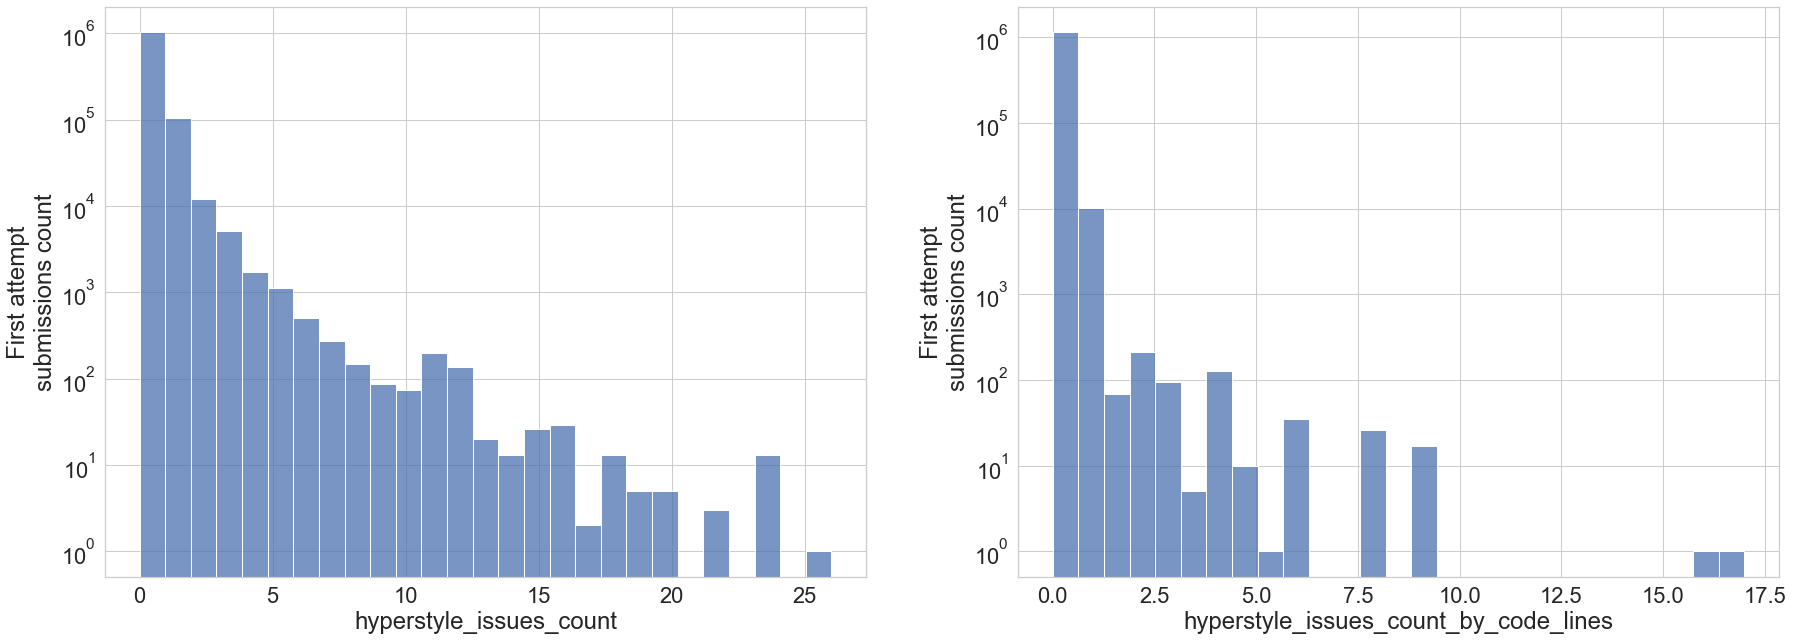

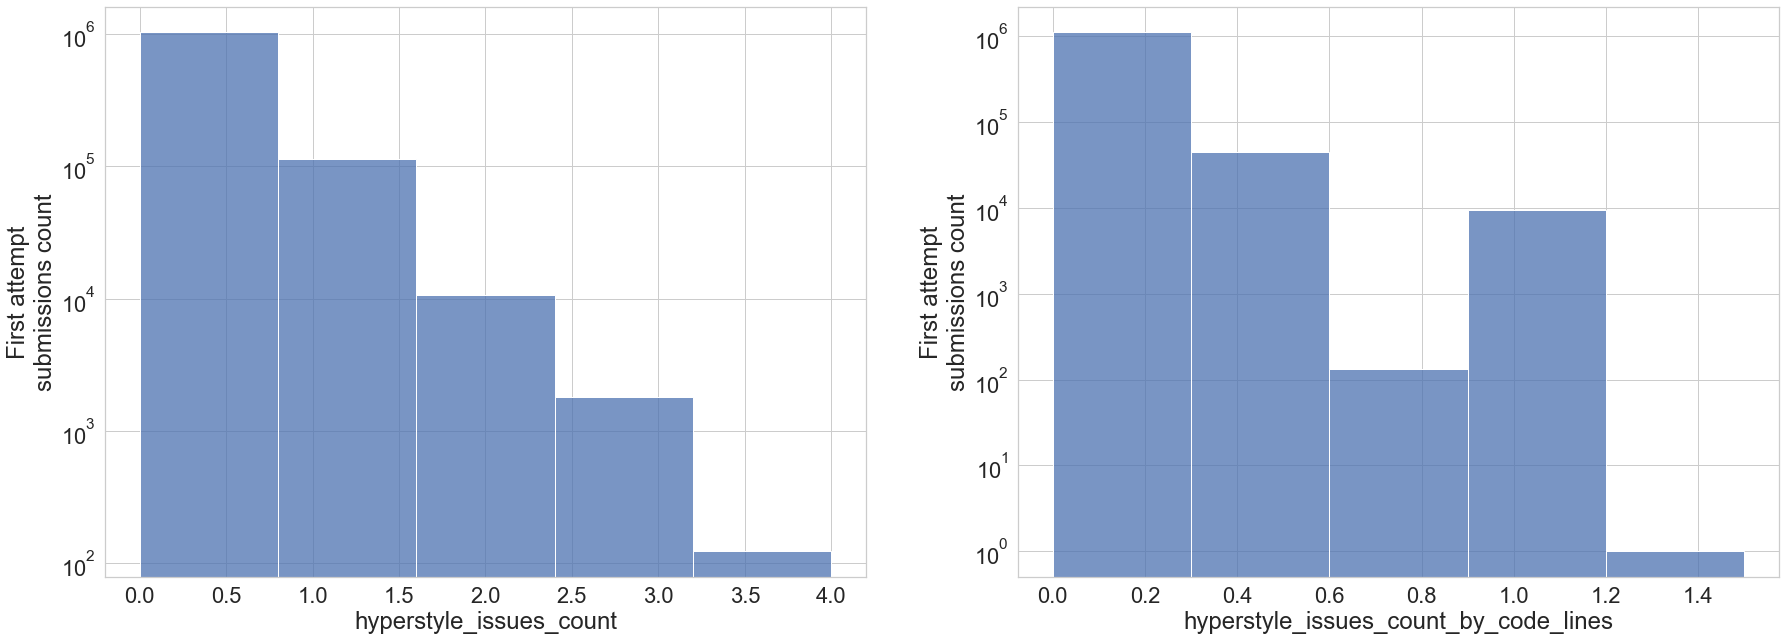

In [100]:
draw_hist_plots(df_first_attempt_hyperstyle_issues_stats, 
                ['hyperstyle_issues_count', 'hyperstyle_issues_count_by_code_lines'], q=1, 
                bins=df_first_attempt_hyperstyle_issues_stats['hyperstyle_issues_count'].max(), 
                log_scale=(False, True),
                y_label='First attempt\nsubmissions count')

draw_hist_plots(df_first_attempt_hyperstyle_issues_stats_unique, 
                ['hyperstyle_issues_count', 'hyperstyle_issues_count_by_code_lines'], q=1, 
                bins=df_first_attempt_hyperstyle_issues_stats_unique['hyperstyle_issues_count'].max(), 
                log_scale=(False, True),
                y_label='First attempt\nsubmissions count')

### Hyperstyle issues analysis in first attempt. Percent of submissions with each issue.

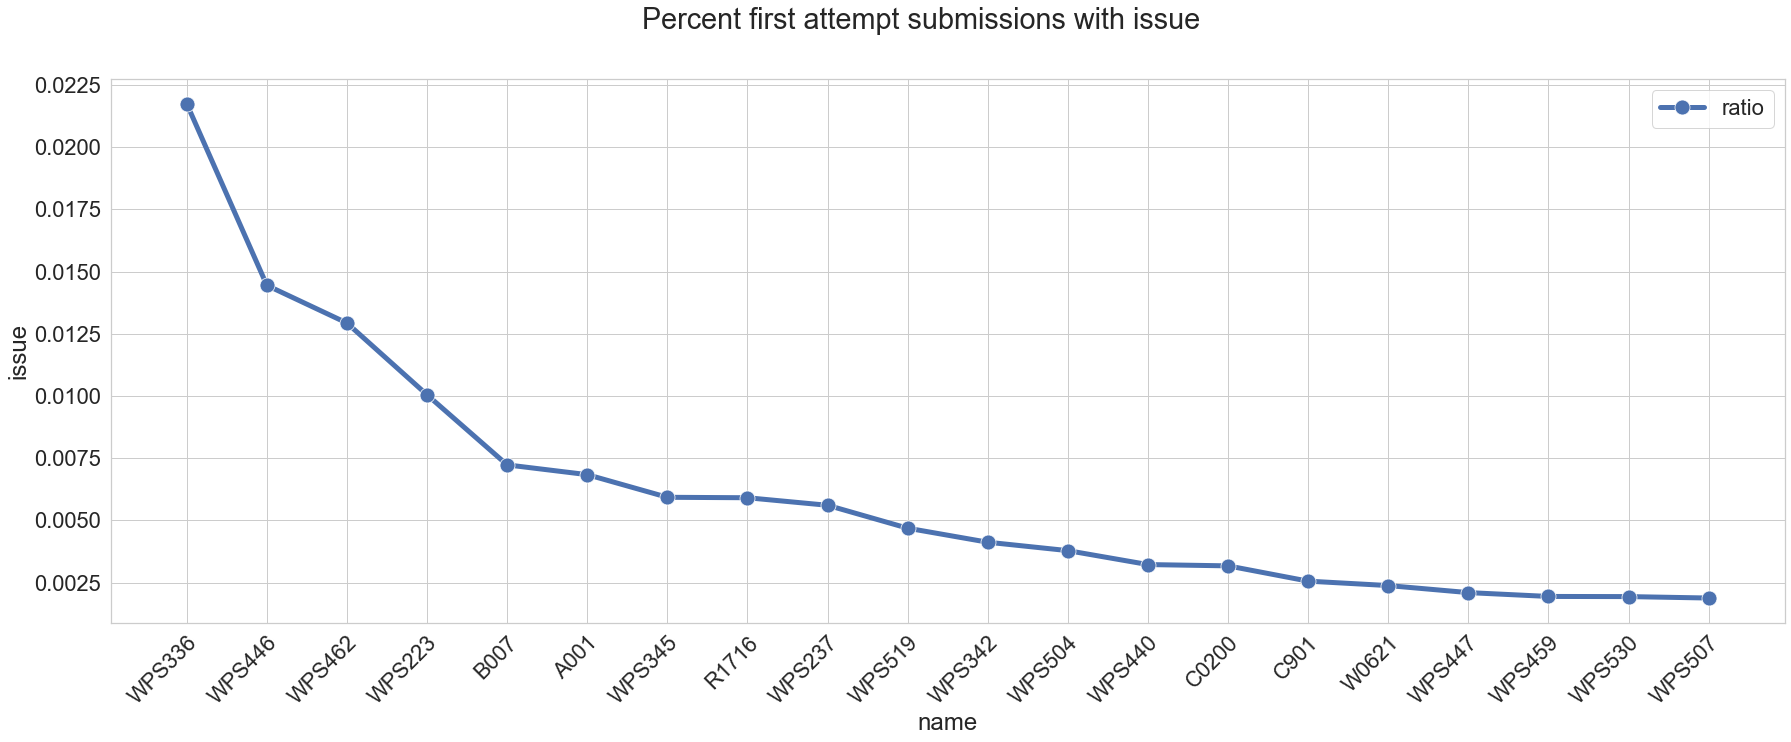

In [101]:
draw_compare(df_first_attempt_hyperstyle_issues_top, 'name', ['ratio', ['ratio']], 
             y_label='issue', 
             title='Percent first attempt submissions with issue', 
             save_path=os.path.join(FIRST_ATTEMPT_STATS_PATH, f'top_issues.pdf'))

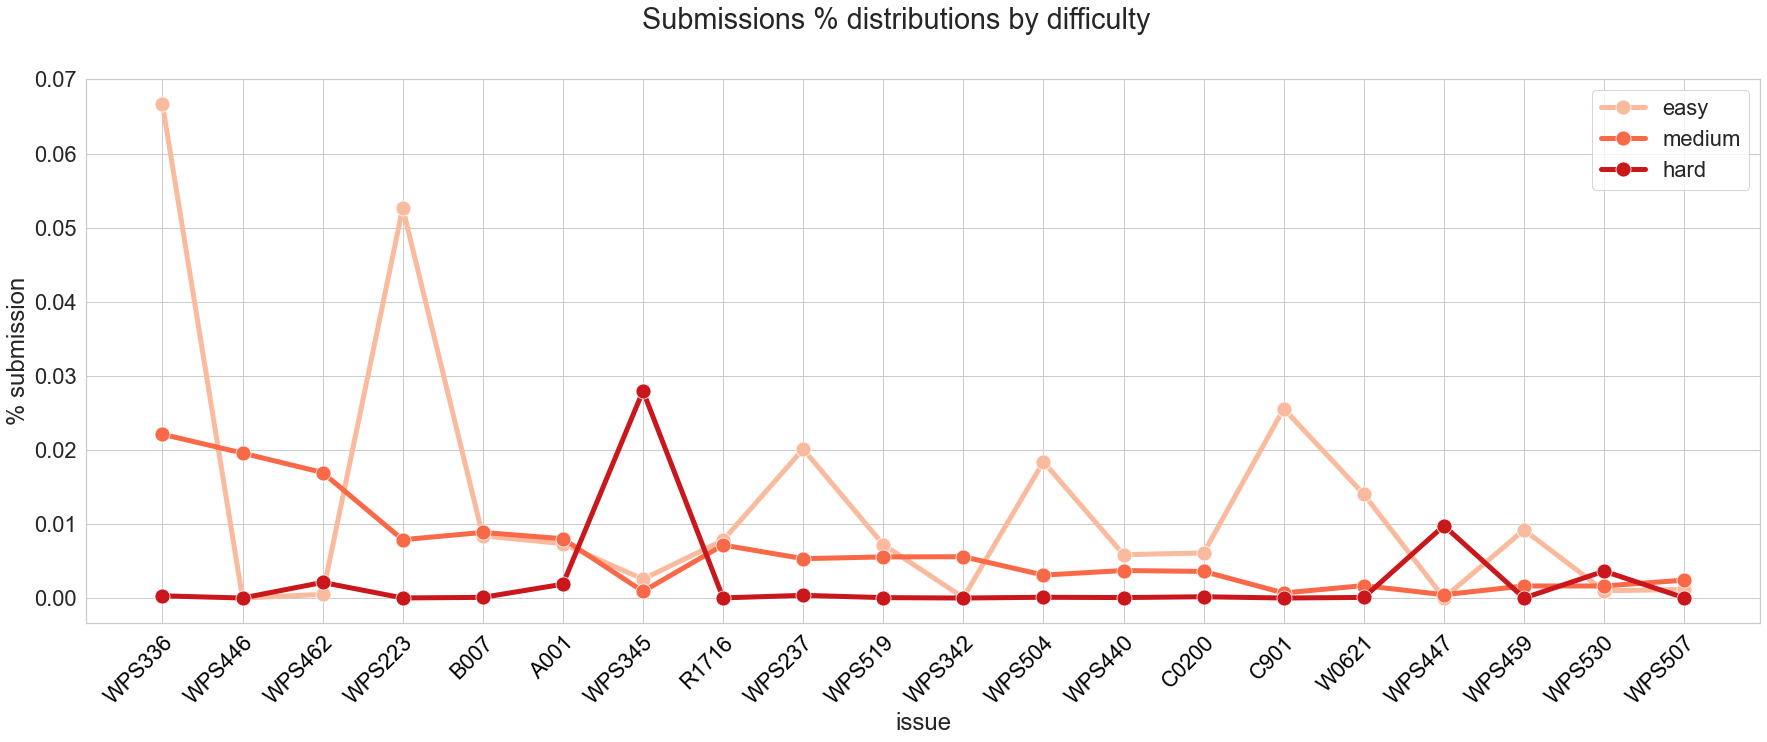

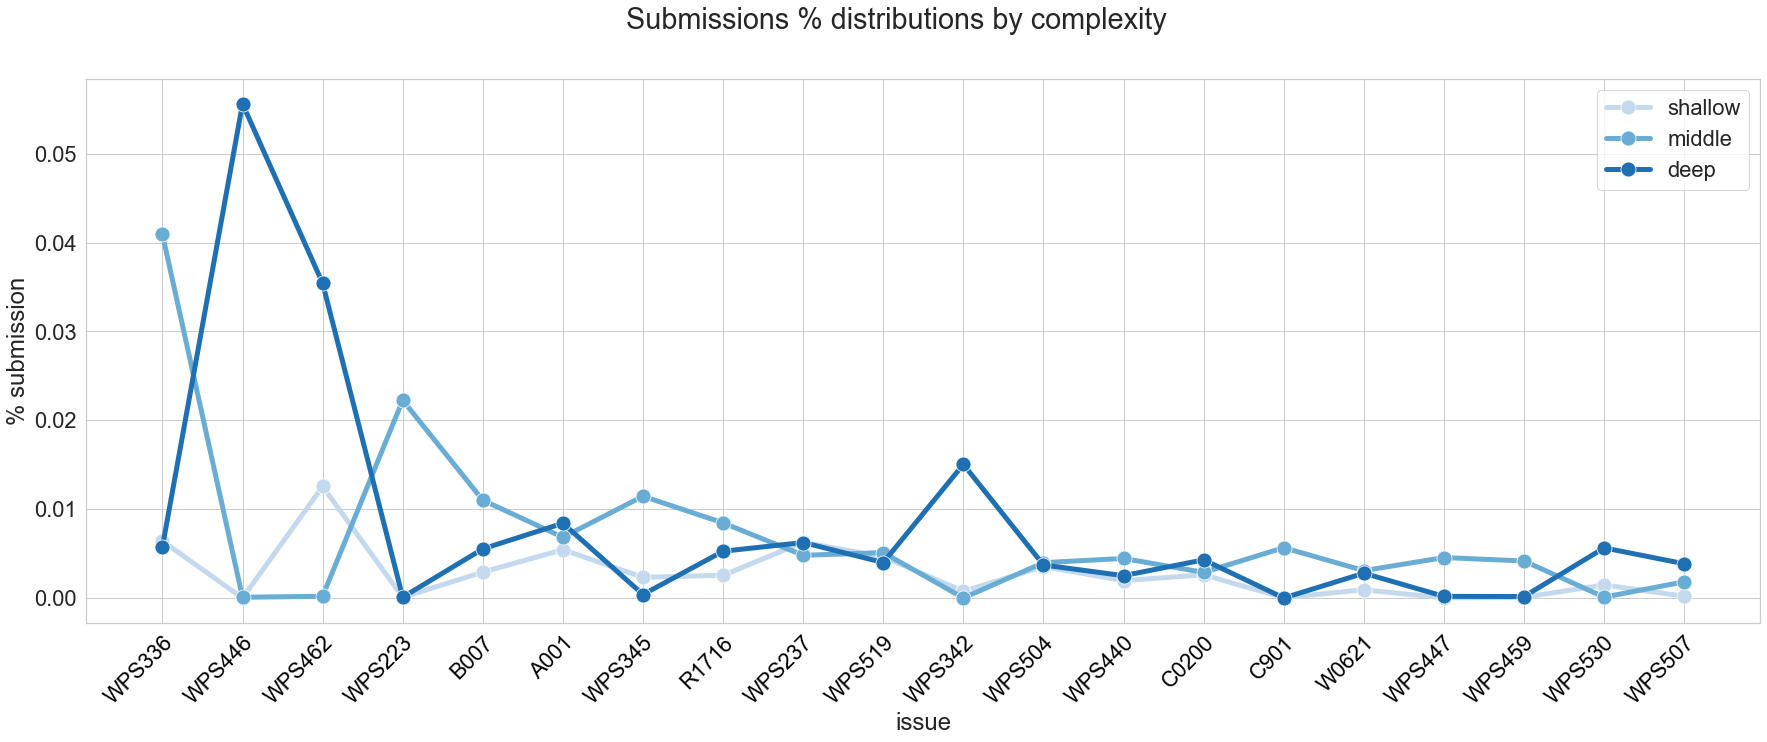

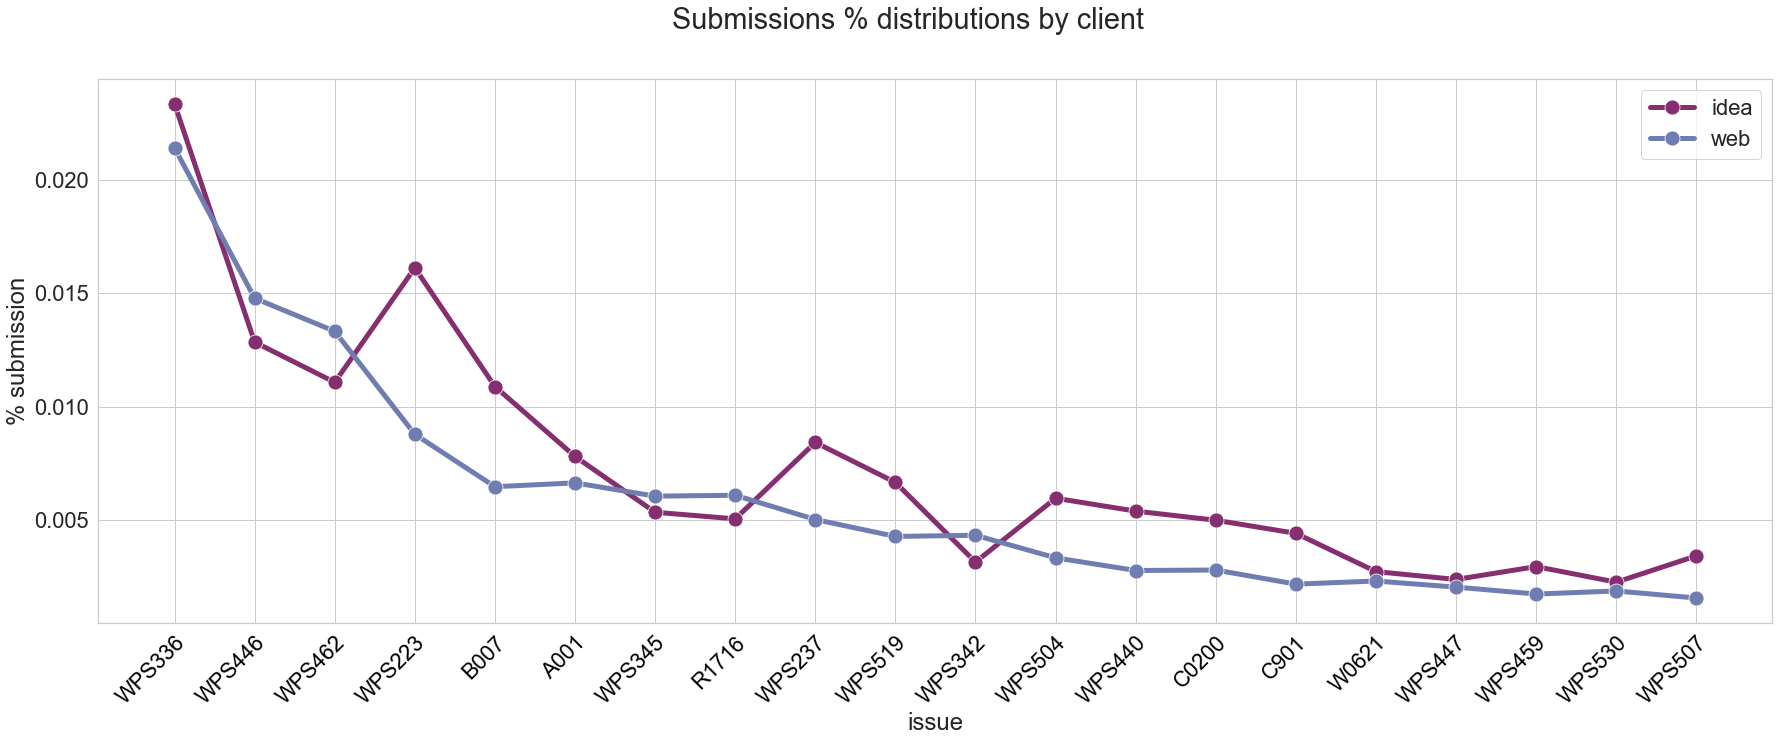

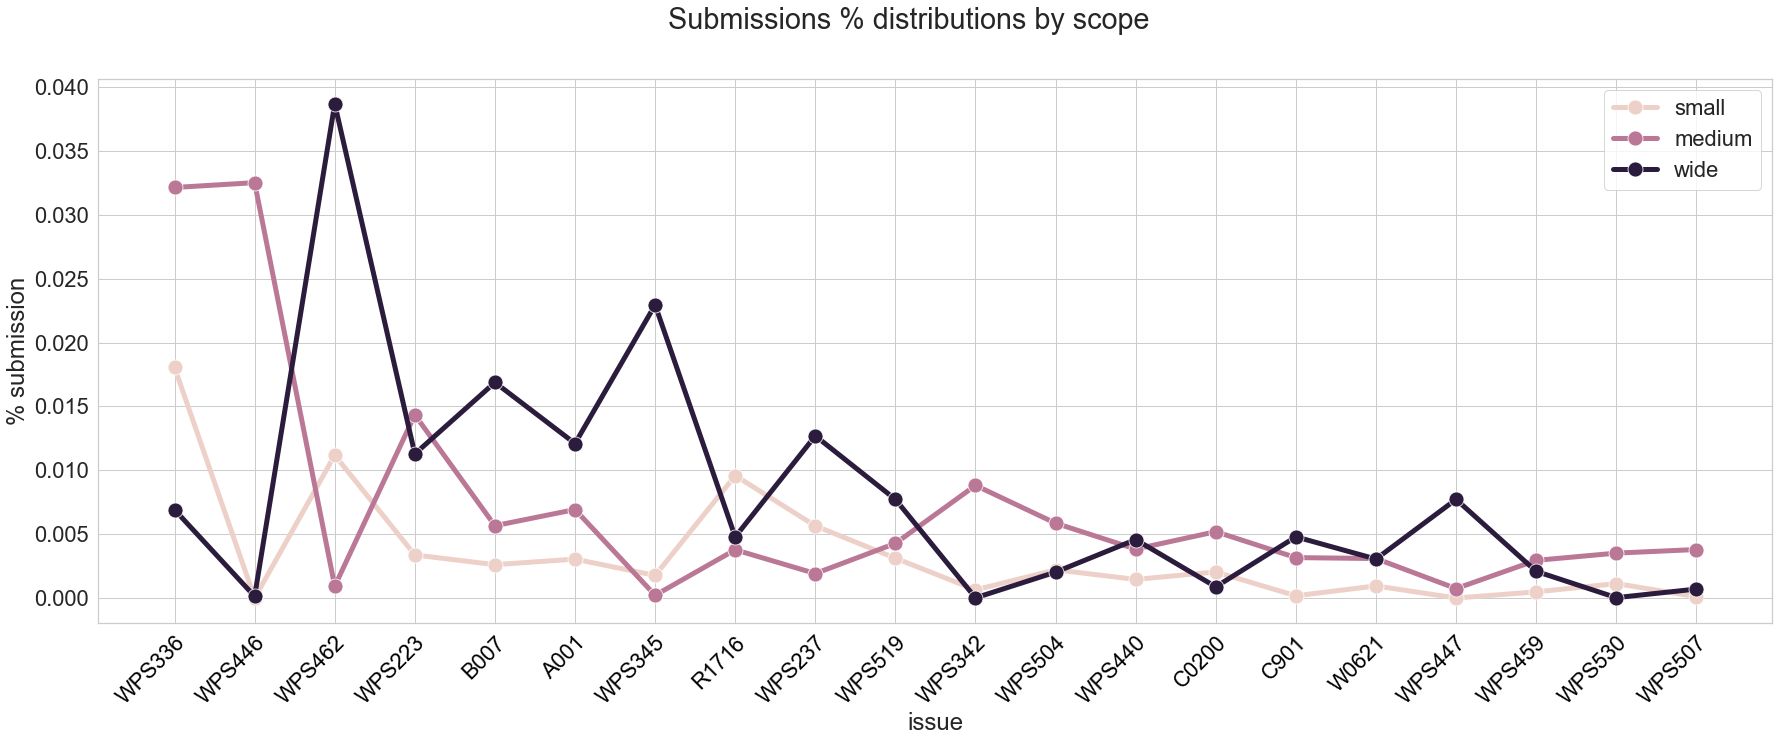

In [102]:
draw_issues(df_first_attempt_hyperstyle_issues_stats_unique, 
            df_first_attempt_hyperstyle_issues_top, 
            hyperstyle_issues_info_names,
            base_dir=FIRST_ATTEMPT_STATS_PATH)

## How many attempts student do depending on number of issues in first submission

In [103]:
df_first_attempt_hyperstyle_issues_stats_unique['total_attempts'].value_counts()

1    1010454
2     105914
3      24917
4       8131
5       3155
Name: total_attempts, dtype: int64

In [104]:
df_first_attempt_hyperstyle_issues_stats_unique['hyperstyle_issues_count'].value_counts()

0    1026160
1     113766
2      10698
3       1820
4        123
5          4
Name: hyperstyle_issues_count, dtype: int64

In [105]:
df_first_attempt_hyperstyle_issues_stats_unique.groupby('hyperstyle_issues_count')['total_attempts'].mean()

hyperstyle_issues_count
0    1.144474
1    1.304195
2    1.760983
3    1.916484
4    1.747967
5    1.000000
Name: total_attempts, dtype: float64

In [106]:
df_first_attempt_hyperstyle_issues_stats.groupby('hyperstyle_issues_count')['total_attempts'].mean()

hyperstyle_issues_count
0     1.144474
1     1.286707
2     1.691528
3     1.660908
4     1.502006
5     1.716216
6     1.562624
7     1.761905
8     1.489796
9     1.436782
10    1.648649
11    1.825000
12    1.511111
13    1.850000
14    1.384615
15    2.000000
16    1.620690
17    2.500000
18    1.846154
19    1.400000
20    1.000000
22    3.666667
24    1.461538
26    1.000000
27    1.000000
Name: total_attempts, dtype: float64

## Number of total attempts if issues presents in first submission

In [107]:
print('issue', 'average_attempts')
for issue in df_first_attempt_hyperstyle_issues_top['name'].values:
    average_attempts = \
        df_first_attempt_hyperstyle_issues_stats_unique[df_first_attempt_hyperstyle_issues_stats_unique[issue] > 0]['total_attempts'].mean()
    print(issue, average_attempts)

issue average_attempts
WPS336 1.2877778221140417
WPS446 1.037837837837838
WPS462 1.0533378061053338
WPS223 1.4806114517661284
B007 1.9368774750990039
A001 1.949498794569217
WPS345 1.225702576112412
R1716 1.844369402437234
WPS237 1.2434230888269886
WPS519 1.501111111111111
WPS342 1.0781052631578947
WPS504 1.3948635634028892
WPS440 1.6129205921938088
C0200 1.7986320109439125
C901 1.8459450288428911
W0621 1.8172866520787747
WPS447 1.1481788079470199
WPS459 1.4079535299374442
WPS530 1.4383684446436575
WPS507 1.4272517321016167


## Issues/steps correlation

In [108]:
df_step_issues_correlation = df_first_attempt_hyperstyle_issues_stats_unique \
    .groupby('step_id')[df_first_attempt_hyperstyle_issues_top['name'].values] \
    .mean() \
    .reset_index()

df_step_issues_correlation

step_id    WPS336  WPS446    WPS462  WPS223      B007      A001  WPS345  \
0       5205  0.000000     0.0  0.000083     0.0  0.000000  0.000000     0.0   
1       5209  0.023337     0.0  0.000181     0.0  0.000060  0.000484     0.0   
2       5212  0.003723     0.0  0.000324     0.0  0.000000  0.000809     0.0   
3       5235  0.003536     0.0  0.068262     0.0  0.000000  0.000576     0.0   
4       5237  0.001956     0.0  0.027696     0.0  0.000061  0.000367     0.0   
..       ...       ...     ...       ...     ...       ...       ...     ...   
359    15150  0.153846     0.0  0.000000     0.0  0.000000  0.000000     0.0   
360    15185  0.000000     0.0  0.000000     0.0  0.000000  0.000000     0.0   
361    15186  0.000000     0.0  0.000000     0.0  0.000000  0.000000     0.0   
362    15187  0.000000     0.0  0.000000     0.0  0.000000  0.000000     0.0   
363    15188  0.000000     0.0  0.000000     0.0  0.000000  0.000000     0.0   

     R1716    WPS237  ...  WPS342    WPS504  WPS440     C0200  C901     W0621  \
0      0.0  0.000042  ...     0.0  0.000000     0.0  0.000000   0.0  0.000000   
1      0.0  0.001935  ...     0.0  0.000000     0.0  0.000000   0.0  0.000000   
2      0.0  0.004168  ...     0.0  0.000000     0.0  0.000000   0.0  0.000081   
3      0.0  0.002056  ...     0.0  0.000000     0.0  0.000000   0.0  0.000000   
4      0.0  0.000795  ...     0.0  0.000000     0.0  0.000183   0.0  0.000000   
..     ...       ...  ...     ...       ...     ...       ...   ...       ...   
359    0.0  0.461538  ...     0.0  0.076923     0.0  0.000000   0.0  0.000000   
360    0.0  0.000000  ...     0.0  0.000000     0.0  0.000000   0.0  0.000000   
361    0.0  0.000000  ...     0.0  0.000000     0.0  0.000000   0.0  0.000000   
362    0.0  0.000000  ...     0.0  0.000000     0.0  0.000000   0.0  0.000000   
363    0.0  0.000000  ...     0.0  0.000000     0.0  0.000000   0.0  0.000000   

     WPS447  WPS459  WPS530  WPS507  
0       0.0     0.0     0.0     0.0  
1       0.0     0.0     0.0     0.0  
2       0.0     0.0     0.0     0.0  
3       0.0     0.0     0.0     0.0  
4       0.0     0.0     0.0     0.0  
..      ...     ...     ...     ...  
359     0.0     0.0     0.0     0.0  
360     0.0     0.0     0.0     0.0  
361     0.0     0.0     0.0     0.0  
362     0.0     0.0     0.0     0.0  
363     0.0     0.0     0.0     0.0  

[364 rows x 21 columns]

In [109]:
step_issues_dict = {'step_id': [],
                    'issue': [],
                    'ratio': [],
                   }

issues_steps_corr_path = os.path.join(FIRST_ATTEMPT_STATS_PATH, 'issues_steps_corr')
os.makedirs(issues_steps_corr_path, exist_ok=True)

for issue in df_first_attempt_hyperstyle_issues_top['name'].values:
    df = df_step_issues_correlation[['step_id', issue]].sort_values(by=issue, ascending=False)
    
    df.to_csv(os.path.join(issues_steps_corr_path, f'{issue}.csv'), index=False)
        
    for _, row in df.iterrows():
        step_issues_dict['step_id'].append(int(row['step_id']))
        step_issues_dict['issue'].append(issue)
        step_issues_dict['ratio'].append(row[issue])

df_step_issues_top = pd.DataFrame.from_dict(step_issues_dict)
df_step_issues_top.to_csv(os.path.join(FIRST_ATTEMPT_STATS_PATH, f'top_steps_issues.csv'), index=False)
df_step_issues_top

step_id   issue     ratio
0        8439  WPS336  0.933021
1        6808  WPS336  0.741289
2        9476  WPS336  0.734406
3        7173  WPS336  0.369510
4        6534  WPS336  0.344280
...       ...     ...       ...
7275     7076  WPS507  0.000000
7276     7029  WPS507  0.000000
7277     7003  WPS507  0.000000
7278     6980  WPS507  0.000000
7279    15188  WPS507  0.000000

[7280 rows x 3 columns]

In [110]:
issues_steps_dist_path = os.path.join(FIRST_ATTEMPT_STATS_PATH, 'issues_steps_dist')
os.makedirs(issues_steps_dist_path, exist_ok=True)

for issue in df_first_attempt_hyperstyle_issues_top['name'].values:
    df = df_first_attempt_hyperstyle_issues_stats_unique[['step_id', issue]] \
            .groupby('step_id') \
            .sum() / df_first_attempt_hyperstyle_issues_stats_unique[issue].sum()
    
    df = df.reset_index()
    df = df[df[issue] > 0].sort_values(by=issue, ascending=False)
    df.to_csv(os.path.join(issues_steps_dist_path, f'{issue}.csv'), index=False)
        
    display(df.T)

98           180          135          218          68   \
step_id  6808.000000  8439.000000  7173.000000  9476.000000  6534.000000   
WPS336      0.315789     0.182874     0.128247     0.116516     0.037229   

                127          149          1            118          220  ...  \
step_id  6979.00000  7458.000000  5209.000000  6935.000000  9478.000000  ...   
WPS336      0.02059     0.018475     0.015402     0.008619     0.008499  ...   

                222         27          123         11          167  \
step_id  9480.00000  6071.00000  6968.00000  5870.00000  8076.00000   
WPS336      0.00004     0.00004     0.00004     0.00004     0.00004   

                212         7           182         186         104  
step_id  9156.00000  5856.00000  8441.00000  8495.00000  6818.00000  
WPS336      0.00004     0.00004     0.00004     0.00004     0.00004  

[2 rows x 132 columns]

92           117         31          40          43   \
step_id  6732.000000  6900.000000  6261.00000  6345.00000  6348.00000   
WPS446      0.997297     0.002042     0.00048     0.00006     0.00006   

                114  
step_id  6894.00000  
WPS446      0.00006

121          3            177          5            89   \
step_id  6962.000000  5235.000000  8311.000000  5238.000000  6715.000000   
WPS462      0.560081     0.111372     0.078296     0.066689     0.065616   

                 4            134          113          108          109  ...  \
step_id  5237.000000  7137.000000  6892.000000  6881.000000  6882.000000  ...   
WPS462      0.030392     0.023818     0.022878     0.011607     0.008655  ...   

                 64           146          149          151          156  \
step_id  6524.000000  7323.000000  7458.000000  7461.000000  7927.000000   
WPS462      0.000067     0.000067     0.000067     0.000067     0.000067   

                 60           164          97           172           349  
step_id  6518.000000  8068.000000  6791.000000  8212.000000  14616.000000  
WPS462      0.000067     0.000067     0.000067     0.000067      0.000067  

[2 rows x 116 columns]

78           21          68           184          63   \
step_id  6555.000000  5938.000000  6534.00000  8443.000000  6521.000000   
WPS223      0.240694     0.225408     0.19259     0.092754     0.074445   

                 160          64           179         182           328  ...  \
step_id  8001.000000  6524.000000  8438.000000  8441.00000  13808.000000  ...   
WPS223      0.056395     0.053632     0.037309     0.01235      0.004664  ...   

                 107          114          101          77           52   \
step_id  6851.000000  6894.000000  6811.000000  6554.000000  6463.000000   
WPS223      0.000086     0.000086     0.000086     0.000086     0.000086   

                 183          27           220          229          23   
step_id  8442.000000  6071.000000  9478.000000  9504.000000  5959.000000  
WPS223      0.000086     0.000086     0.000086     0.000086     0.000086  

[2 rows x 33 columns]

104          74           222          76           194  \
step_id  6818.000000  6549.000000  9480.000000  6553.000000  8922.000000   
B007        0.178567     0.177727     0.094564     0.084363     0.051962   

                 175          120          220           287          192  \
step_id  8215.000000  6942.000000  9478.000000  11104.000000  8920.000000   
B007        0.045722     0.039362     0.033841      0.025561     0.022561   

         ...          238         91          84          83          80   \
step_id  ...  10082.00000  6719.00000  6673.00000  6668.00000  6559.00000   
B007     ...      0.00012     0.00012     0.00012     0.00012     0.00012   

                160         71          227         64          1    
step_id  8001.00000  6542.00000  9502.00000  6524.00000  5209.00000  
B007        0.00012     0.00012     0.00012     0.00012     0.00012  

[2 rows x 145 columns]

185        100          104          14           58   \
step_id  8444.000000  6810.0000  6818.000000  5918.000000  6469.000000   
A001        0.117752     0.0538     0.052658     0.047456     0.044918   

                 27           218          95           9            146  ...  \
step_id  6071.000000  9476.000000  6739.000000  5858.000000  7323.000000  ...   
A001        0.035909     0.030834     0.026266     0.024616     0.022967  ...   

                 85           28           26           136           235  \
step_id  6676.000000  6077.000000  6062.000000  7174.000000  10062.000000   
A001        0.000127     0.000127     0.000127     0.000127      0.000127   

                  236          140           239           247          35   
step_id  10063.000000  7178.000000  10083.000000  10177.000000  6275.000000  
A001         0.000127     0.000127      0.000127      0.000127     0.000127  

[2 rows x 222 columns]

79           52           61           58           73   \
step_id  6558.000000  6463.000000  6519.000000  6469.000000  6544.000000   
WPS345      0.853191     0.063817     0.024883     0.018296     0.005708   

                 51           19           85           232          60   ...  \
step_id  6462.000000  5931.000000  6676.000000  9887.000000  6518.000000  ...   
WPS345      0.004537     0.002927     0.002049     0.001756     0.001756  ...   

                 216          184          125          65           67   \
step_id  9466.000000  8443.000000  6977.000000  6525.000000  6533.000000   
WPS345      0.000146     0.000146     0.000146     0.000146     0.000146   

                 69           157          75           134          6    
step_id  6540.000000  7993.000000  6551.000000  7137.000000  5850.000000  
WPS345      0.000146     0.000146     0.000146     0.000146     0.000146  

[2 rows x 62 columns]

184          77           46           61           160  \
step_id  8443.000000  6554.000000  6381.000000  6519.000000  8001.000000   
R1716       0.229041     0.162384     0.118632     0.086918     0.057994   

                78           67           18           163          146  ...  \
step_id  6555.00000  6533.000000  5930.000000  8067.000000  7323.000000  ...   
R1716       0.05403     0.043459     0.040376     0.036265     0.030539  ...   

                 40           19           185          69            273  \
step_id  6345.000000  5931.000000  8444.000000  6540.000000  10792.000000   
R1716       0.000294     0.000294     0.000294     0.000147      0.000147   

                 221          51           65           89            287  
step_id  9479.000000  6462.000000  6525.000000  6715.000000  11104.000000  
R1716       0.000147     0.000147     0.000147     0.000147      0.000147  

[2 rows x 40 columns]

61           117          116          68           41   \
step_id  6519.000000  6900.000000  6896.000000  6534.000000  6346.000000   
WPS237      0.231198     0.221603     0.181523     0.032807     0.032188   

                 114          85            277          2             237  \
step_id  6894.000000  6676.000000  10968.000000  5212.000000  10064.000000   
WPS237      0.028474     0.023832      0.018106     0.015939      0.014547   

         ...          157          159          160          96           172  \
step_id  ...  7993.000000  7998.000000  8001.000000  6790.000000  8212.000000   
WPS237   ...     0.000155     0.000155     0.000155     0.000155     0.000155   

                 173          49           48           190          0    
step_id  8213.000000  6404.000000  6403.000000  8832.000000  5205.000000  
WPS237      0.000155     0.000155     0.000155     0.000155     0.000155  

[2 rows x 170 columns]

104      76           6            219          167  \
step_id  6818.000000  6553.00  5850.000000  9477.000000  8076.000000   
WPS519      0.177222     0.07     0.068889     0.065556     0.060556   

                 58           185          164          228          145  ...  \
step_id  6469.000000  8444.000000  8068.000000  9503.000000  7199.000000  ...   
WPS519      0.056667     0.053704     0.048889     0.045741     0.039815  ...   

                 152          194          49           59           206  \
step_id  7468.000000  8922.000000  6404.000000  6487.000000  9150.000000   
WPS519      0.000185     0.000185     0.000185     0.000185     0.000185   

                 147          54           89           81            350  
step_id  7456.000000  6465.000000  6715.000000  6607.000000  14617.000000  
WPS519      0.000185     0.000185     0.000185     0.000185      0.000185  

[2 rows x 95 columns]

133           306          132          189          126  \
step_id  7136.000000  12130.000000  7135.000000  8597.000000  6978.000000   
WPS342      0.920842      0.049895     0.024421     0.002105     0.000632   

                 105          37           81           204          206  \
step_id  6849.000000  6308.000000  6607.000000  9148.000000  9150.000000   
WPS342      0.000421     0.000211     0.000211     0.000211     0.000211   

                  253           257           316           339  
step_id  10216.000000  10369.000000  12683.000000  14249.000000  
WPS342       0.000211      0.000211      0.000211      0.000211

180          45           203          21           204  \
step_id  8439.000000  6380.000000  9147.000000  5938.000000  9148.000000   
WPS504      0.083008     0.082321     0.071314     0.068333     0.056409   

                 218          206          85           81           30   ...  \
step_id  9476.000000  9150.000000  6676.000000  6607.000000  6212.000000  ...   
WPS504      0.052052     0.052052     0.051594     0.050906     0.041504  ...   

                 93           213          104          107          109  \
step_id  6733.000000  9278.000000  6818.000000  6851.000000  6882.000000   
WPS504      0.000229     0.000229     0.000229     0.000229     0.000229   

                 112          113          160          185           359  
step_id  6886.000000  6892.000000  8001.000000  8444.000000  15150.000000  
WPS504      0.000229     0.000229     0.000229     0.000229      0.000229  

[2 rows x 104 columns]

74           194          59          104          287  \
step_id  6549.000000  8922.000000  6487.000000  6818.00000  11104.00000   
WPS440      0.119785     0.076985     0.066756     0.05249      0.04926   

                 76           222         192         75          197  ...  \
step_id  6553.000000  9480.000000  8920.00000  6551.00000  8932.00000  ...   
WPS440      0.043607     0.030148     0.02961     0.02961     0.02638  ...   

                 200          211          86           85           79   \
step_id  8997.000000  9155.000000  6684.000000  6676.000000  6558.000000   
WPS440      0.000269     0.000269     0.000269     0.000269     0.000269   

                 63           54           231           233          5    
step_id  6521.000000  6465.000000  9570.000000  10019.000000  5238.000000  
WPS440      0.000269     0.000269     0.000269      0.000269     0.000269  

[2 rows x 147 columns]

30         218          229          179           287  \
step_id  6212.000000  9476.0000  9504.000000  8438.000000  11104.000000   
C0200       0.131327     0.1171     0.062927     0.060465      0.032285   

                 215          60           82           125          146  ...  \
step_id  9465.000000  6518.000000  6609.000000  6977.000000  7323.000000  ...   
C0200       0.032011     0.030643     0.026539     0.024624     0.024077  ...   

                 231          230          224          219          168  \
step_id  9570.000000  9505.000000  9489.000000  9477.000000  8086.000000   
C0200       0.000274     0.000274     0.000274     0.000274     0.000274   

                 171          177          182          213           350  
step_id  8132.000000  8311.000000  8441.000000  9278.000000  14617.000000  
C0200       0.000274     0.000274     0.000274     0.000274      0.000274  

[2 rows x 124 columns]

68          21           179          182          184  \
step_id  6534.000000  5938.00000  8438.000000  8441.000000  8443.000000   
C901        0.426535     0.36851     0.176111     0.009501     0.005429   

                 62            287           321          195          76   \
step_id  6520.000000  11104.000000  13066.000000  8923.000000  6553.000000   
C901        0.003393      0.002375      0.001018     0.001018     0.001018   

         ...          19           126          78           66           65   \
step_id  ...  5931.000000  6978.000000  6555.000000  6526.000000  6525.000000   
C901     ...     0.000339     0.000339     0.000339     0.000339     0.000339   

                 64           63           61           46           125  
step_id  6524.000000  6521.000000  6519.000000  6381.000000  6977.000000  
C901        0.000339     0.000339     0.000339     0.000339     0.000339  

[2 rows x 24 columns]

86           119         218          135          61   \
step_id  6684.000000  6936.000000  9476.00000  7173.000000  6519.000000   
W0621       0.189278     0.158643     0.08388     0.064187     0.032093   

                 19           68           60           144          118  ...  \
step_id  5931.000000  6534.000000  6518.000000  7192.000000  6935.000000  ...   
W0621       0.021152     0.020788     0.014953     0.014588     0.014588  ...   

                 203          134          222          130          117  \
step_id  9147.000000  7137.000000  9480.000000  7029.000000  6900.000000   
W0621       0.000365     0.000365     0.000365     0.000365     0.000365   

                 115          104          98           221           358  
step_id  6895.000000  6818.000000  6808.000000  9479.000000  15080.000000  
W0621       0.000365     0.000365     0.000365     0.000365      0.000365  

[2 rows x 158 columns]

91           218          81           25           179  \
step_id  6719.000000  9476.000000  6607.000000  6024.000000  8438.000000   
WPS447      0.843543     0.130381     0.019454     0.003311     0.001656   

                 205          204          221  
step_id  9149.000000  9148.000000  9479.000000  
WPS447      0.000828     0.000414     0.000414

21           64         67           66           184  \
step_id  5938.000000  6524.000000  6533.0000  6526.000000  8443.000000   
WPS459      0.358356     0.293566     0.0916     0.087578     0.065684   

                  254          73           61           45           18   \
step_id  10333.000000  6544.000000  6519.000000  6380.000000  5930.000000   
WPS459       0.045576     0.014298     0.011171     0.005362     0.005362   

         ...          63           72           74           78           23   \
step_id  ...  6521.000000  6543.000000  6549.000000  6555.000000  5959.000000   
WPS459   ...     0.000447     0.000447     0.000447     0.000447     0.000447   

                 182          20           221          228          19   
step_id  8441.000000  5937.000000  9479.000000  9503.000000  5931.000000  
WPS459      0.000447     0.000447     0.000447     0.000447     0.000447  

[2 rows x 30 columns]

187          153          309          57           156  \
step_id  8496.000000  7471.000000  12368.00000  6468.000000  7927.000000   
WPS530      0.338861     0.211564      0.15688     0.150157     0.035858   

                125         165          195          60           229  ...  \
step_id  6977.00000  8074.00000  8923.000000  6518.000000  9504.000000  ...   
WPS530      0.03541     0.03048     0.008516     0.006723     0.004482  ...   

                 27           203          194          37           186  \
step_id  6071.000000  9147.000000  8922.000000  6308.000000  8495.000000   
WPS530      0.000448     0.000448     0.000448     0.000448     0.000448   

                 159          122          107          105          192  
step_id  7998.000000  6967.000000  6851.000000  6849.000000  8920.000000  
WPS530      0.000448     0.000448     0.000448     0.000448     0.000448  

[2 rows x 32 columns]

30          75           195          192          218  \
step_id  6212.000000  6551.00000  8923.000000  8920.000000  9476.000000   
WPS507      0.252194     0.22448     0.196767     0.037875     0.037413   

                 196          194          197          37           229  ...  \
step_id  8930.000000  8922.000000  8932.000000  6308.000000  9504.000000  ...   
WPS507      0.035104     0.033718     0.028637     0.015242     0.012933  ...   

                 116          126          153          223          159  \
step_id  6896.000000  6978.000000  7471.000000  9488.000000  7998.000000   
WPS507      0.000462     0.000462     0.000462     0.000462     0.000462   

                 187          59           216          58           204  
step_id  8496.000000  6487.000000  9466.000000  6469.000000  9148.000000  
WPS507      0.000462     0.000462     0.000462     0.000462     0.000462  

[2 rows x 63 columns]

# Last attempt stats

Last attempt submissions is when **attempt** == **total_attemps** - final result of all attemps. This shows what issues student do not fix and leave in their final solutions.

In [111]:
df_last_attempt_stats = df_submissions_stats[df_submissions_stats['attempt'] == df_submissions_stats['total_attempts']]
df_last_attempt_stats.describe()

id  code_lines_count  code_symbols_count       step_id  \
count  1.152571e+06      1.152571e+06        1.152571e+06  1.152571e+06   
mean   4.294077e+07      5.000907e+00        1.120217e+02  7.059959e+03   
std    7.677263e+06      4.185091e+00        1.098318e+02  1.465047e+03   
min    2.938133e+07      1.000000e+00        8.000000e+00  5.205000e+03   
25%    3.634844e+07      2.000000e+00        4.300000e+01  6.261000e+03   
50%    4.294990e+07      4.000000e+00        7.800000e+01  6.733000e+03   
75%    4.968958e+07      7.000000e+00        1.440000e+02  7.199000e+03   
max    5.639778e+07      1.280000e+02        4.948000e+03  1.518800e+04   

       sync_counter       user_id         group       attempt  total_attempts  
count  1.152571e+06  1.152571e+06  1.152571e+06  1.152571e+06    1.152571e+06  
mean   4.772072e+00  5.055958e+04  8.404356e+05  1.167244e+00    1.167244e+00  
std    1.021301e+00  1.620300e+04  4.716168e+05  5.076292e-01    5.076292e-01  
min    2.000000e+00  3.000000e+00  2.000000e+00  1.000000e+00    1.000000e+00  
25%    4.000000e+00  4.333300e+04  4.402585e+05  1.000000e+00    1.000000e+00  
50%    5.000000e+00  5.238600e+04  8.403140e+05  1.000000e+00    1.000000e+00  
75%    5.000000e+00  6.080600e+04  1.227026e+06  1.000000e+00    1.000000e+00  
max    1.900000e+01  8.240000e+04  1.722704e+06  5.000000e+00    5.000000e+00

In [112]:
print(df_last_attempt_stats.shape[0] == df_first_attempt_stats.shape[0])

True


### Last attempt statistics

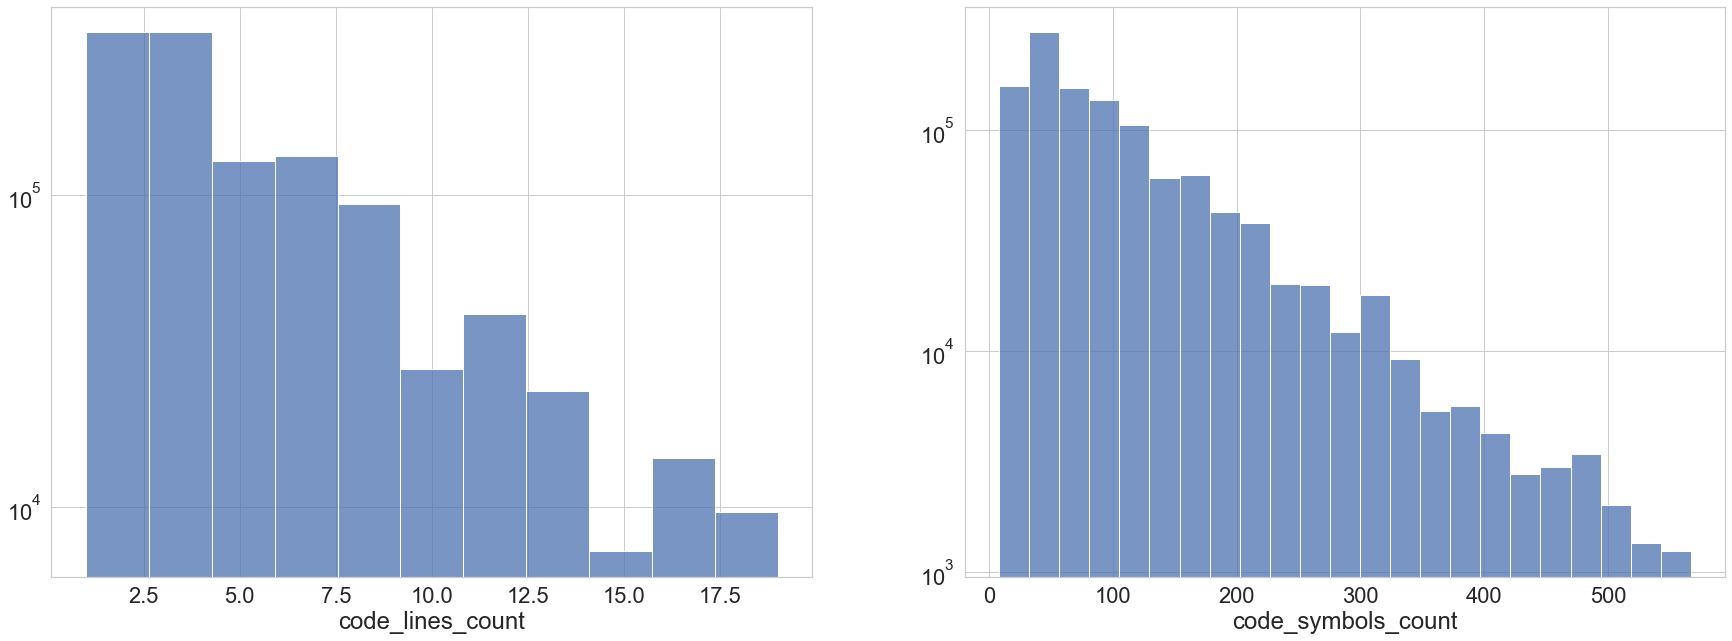

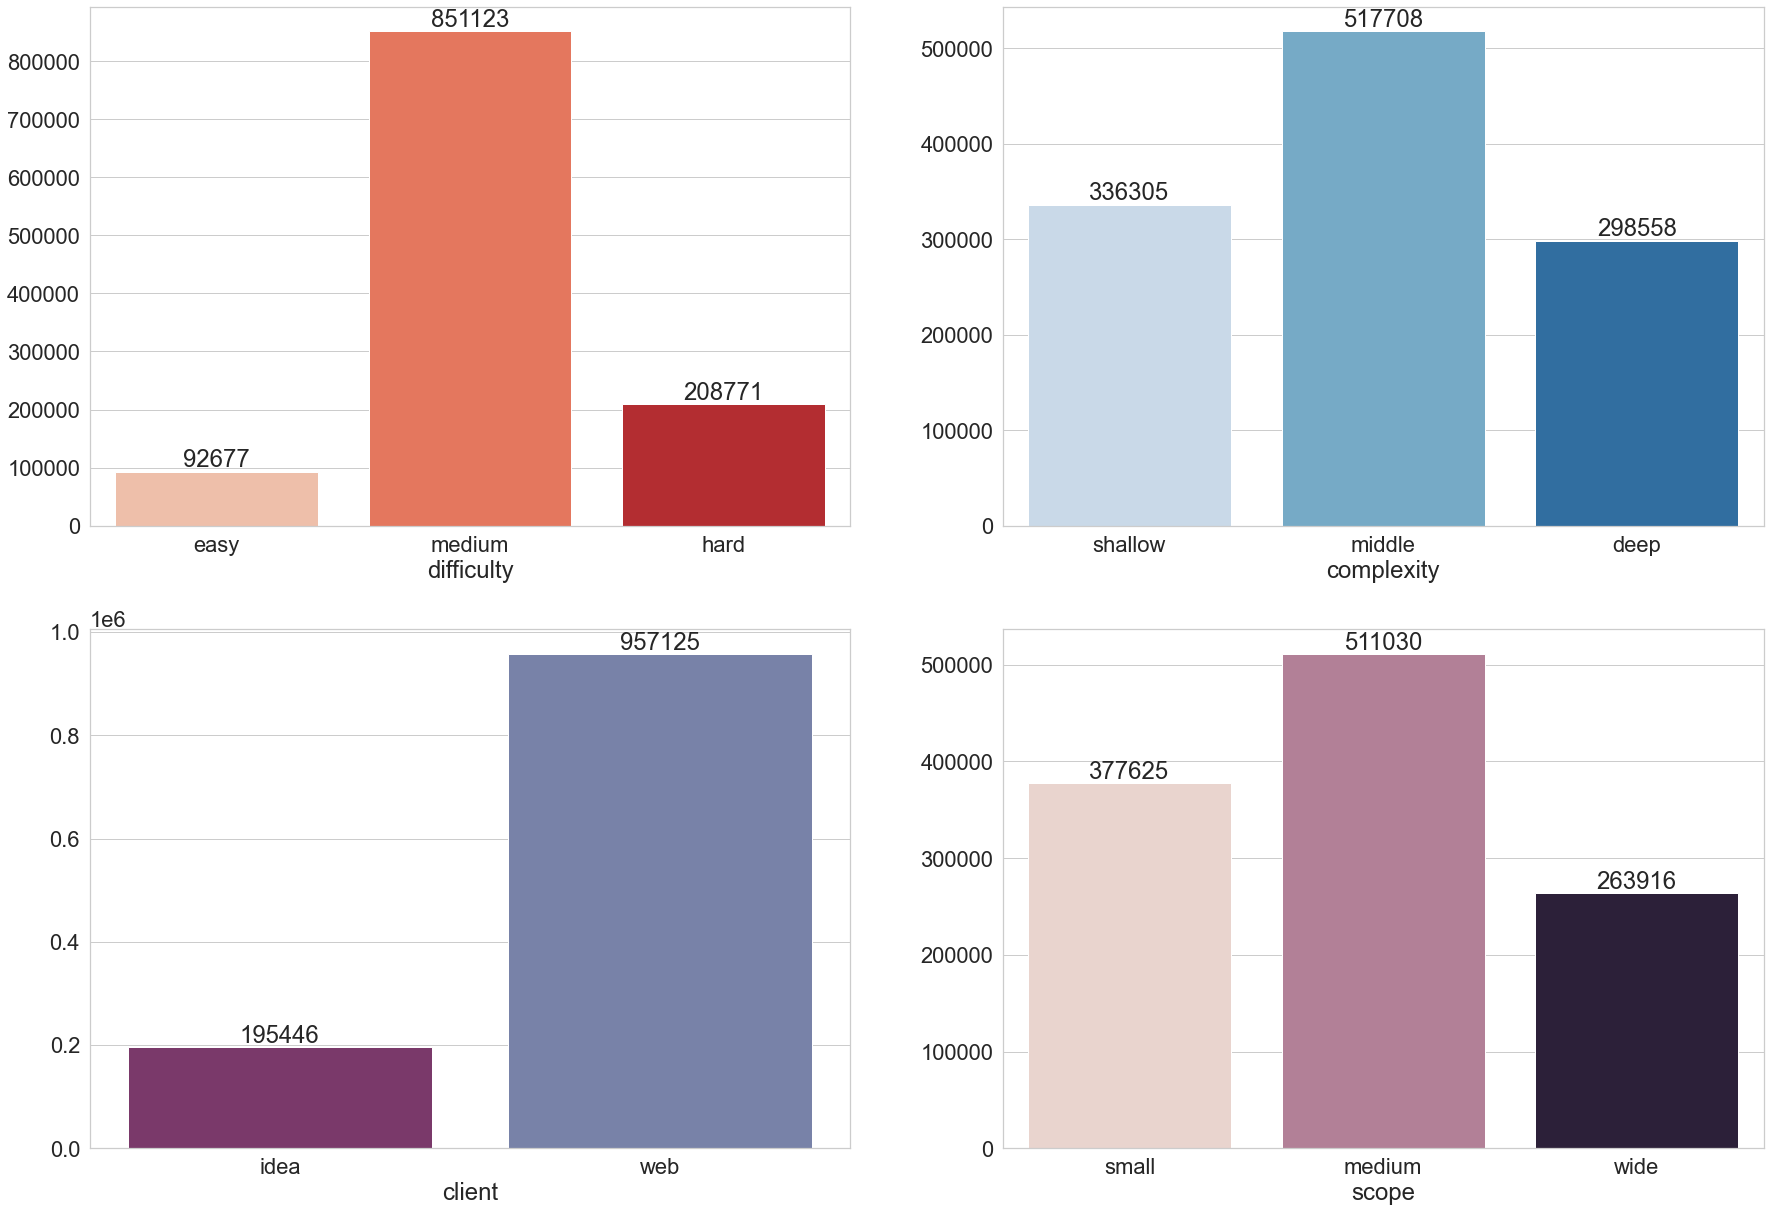

In [113]:
draw_hist_plots(df_last_attempt_stats, ['code_lines_count', 'code_symbols_count'], 
                log_scale=(False, True))
draw_count_plots(df_last_attempt_stats, ['difficulty', 'complexity', 'client', 'scope'])

In [114]:
df_last_attempt_hyperstyle_issues_stats = merge_dfs(df_last_attempt_stats, 
                                                    df_hyperstyle_issues_stats, 
                                                    left_on='id', right_on='id')

df_last_attempt_hyperstyle_issues_stats_unique = merge_dfs(df_last_attempt_stats, 
                                                           df_hyperstyle_issues_stats_unique, 
                                                           left_on='id', right_on='id')

### Hyperstyle issues analysis in last attempt. Percent of submissions with each issue.

In [115]:
def sort_by_order(df: pd.DataFrame, column: str, order: List[str]) -> pd.DataFrame:
    df_order = pd.DataFrame.from_dict({'order': order})
    return merge_dfs(df_order, df, left_on='order', right_on=column).drop(columns=['order'])

In [116]:
df_last_attempt_hyperstyle_issues_top = get_top_issues(df_last_attempt_hyperstyle_issues_stats_unique, 
                                          df_hyperstyle_issues, 
                                          len(df_hyperstyle_issues), 
                                          hyperstyle_issues_ignore_names)

df_last_attempt_hyperstyle_issues_top = sort_by_order(df_last_attempt_hyperstyle_issues_top,
                                                      'name',
                                                      df_first_attempt_hyperstyle_issues_top['name'].values)
                                                       
df_last_attempt_hyperstyle_issues_top.to_csv(os.path.join(LAST_ATTEMPT_STATS_PATH, f'top_issues.csv'), index=False)
df_last_attempt_hyperstyle_issues_top

name  count        category  \
0   WPS336  24792  BEST_PRACTICES   
1   WPS446  16596  BEST_PRACTICES   
2   WPS462  14926  BEST_PRACTICES   
3   WPS223  11121      COMPLEXITY   
4     B007   3522  BEST_PRACTICES   
5     A001   3455     ERROR_PRONE   
6   WPS345   6674  BEST_PRACTICES   
7    R1716   3737  BEST_PRACTICES   
8   WPS237   6468      COMPLEXITY   
9   WPS519   5195  BEST_PRACTICES   
10  WPS342   4794  BEST_PRACTICES   
11  WPS504   4269  BEST_PRACTICES   
12  WPS440   3108     ERROR_PRONE   
13   C0200   2307  BEST_PRACTICES   
14    C901   1994      COMPLEXITY   
15   W0621   1590  BEST_PRACTICES   
16  WPS447   2362  BEST_PRACTICES   
17  WPS459   2196  BEST_PRACTICES   
18  WPS530   2045  BEST_PRACTICES   
19  WPS507   2131  BEST_PRACTICES   

                                                 text difficulty  \
0                 Found explicit string concatenation     MEDIUM   
1                    Found approximate constant: 2.71     MEDIUM   
2                        Wrong multiline string usage     MEDIUM   
3               Found too many `elif` branches: 7 > 3       HARD   
4   Loop control variable 'i' not used within the ...     MEDIUM   
5        variable "str" is shadowing a python builtin       HARD   
6                  Found meaningless number operation     MEDIUM   
7    Simplify chained comparison between the operands     MEDIUM   
8                      Found a too complex `f` string       HARD   
9                         Found implicit `sum()` call     MEDIUM   
10                  Found implicit raw string: "\\\\"     MEDIUM   
11                            Found negated condition     MEDIUM   
12                   Found block variables overlap: i       HARD   
13  Consider using enumerate instead of iterating ...     MEDIUM   
14  Too complex function. You can figure out how t...       HARD   
15  Redefining name 'title' from outer scope (line 9)     MEDIUM   
16  Found alphabet as strings: abcdefghijklmnopqrs...     MEDIUM   
17      Found comparison with float or complex number     MEDIUM   
18                      Found implicit negative index     MEDIUM   
19                      Found useless `len()` compare     MEDIUM   

                                          code_sample     ratio  
0   name = input()\nprint("Hello, " + name) # WPS3...  0.021510  
1   print(type("int"))\nprint(type(394))\nprint(ty...  0.014399  
2   print("""' '' ''' # WPS462 line=1 offset=6\n' ...  0.012950  
3   num1, num2, op = float(input()), float(input()...  0.009649  
4   n = int(input())\n\nfor i in range(n): # B007 ...  0.003056  
5   # put your python code here\nstr = input() # A...  0.002998  
6               print(1*2*3) # WPS345 line=1 offset=7  0.005791  
7   num = float(input())\n\nif num < 2:\n    print...  0.003242  
8   word = input()\nprint(f"{word} has {len(word)}...  0.005612  
9   # put your code here\nn = input()\nresult = 0\...  0.004507  
10             print("\\\\") # WPS342 line=1 offset=7  0.004159  
11  A =eval(input(""))\nB = eval(input(""))\nres =...  0.003704  
12  n = int(input())\n\nmy_stack = []\nmy_stack2 =...  0.002697  
13  inp = input()\nfor i in range(len(inp)): # C02...  0.002002  
14  string = input()\nfor c in string: # C901 line...  0.001730  
15  class Painting:\n    musuem = "Louvre"\n    \n...  0.001380  
16  alphabet = 'abcdefghijklmnopqrstuvwxyz' # WPS4...  0.002049  
17  def compare(numerator, denominator):\n    retu...  0.001905  
18  sentence = input()\nprint(sentence[len(sentenc...  0.001774  
19  numbers = input().split()\nnumber = input()\np...  0.001849

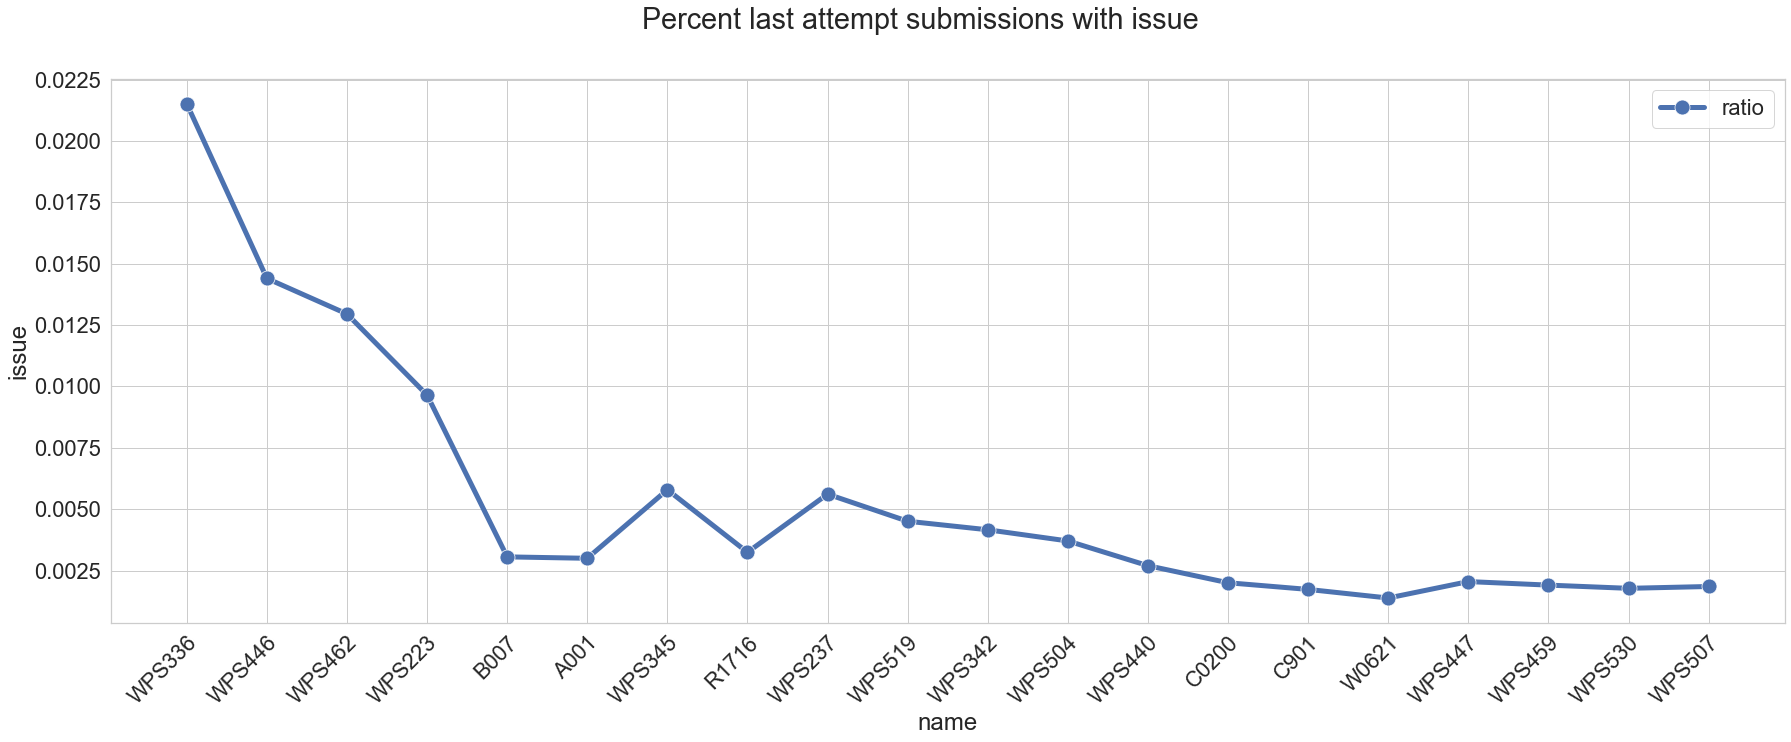

In [117]:
draw_compare(df_last_attempt_hyperstyle_issues_top, 'name', ['ratio', ['ratio']], 
             y_label='issue', 
             title='Percent last attempt submissions with issue', 
             save_path=os.path.join(LAST_ATTEMPT_STATS_PATH, f'top_issues.pdf'))

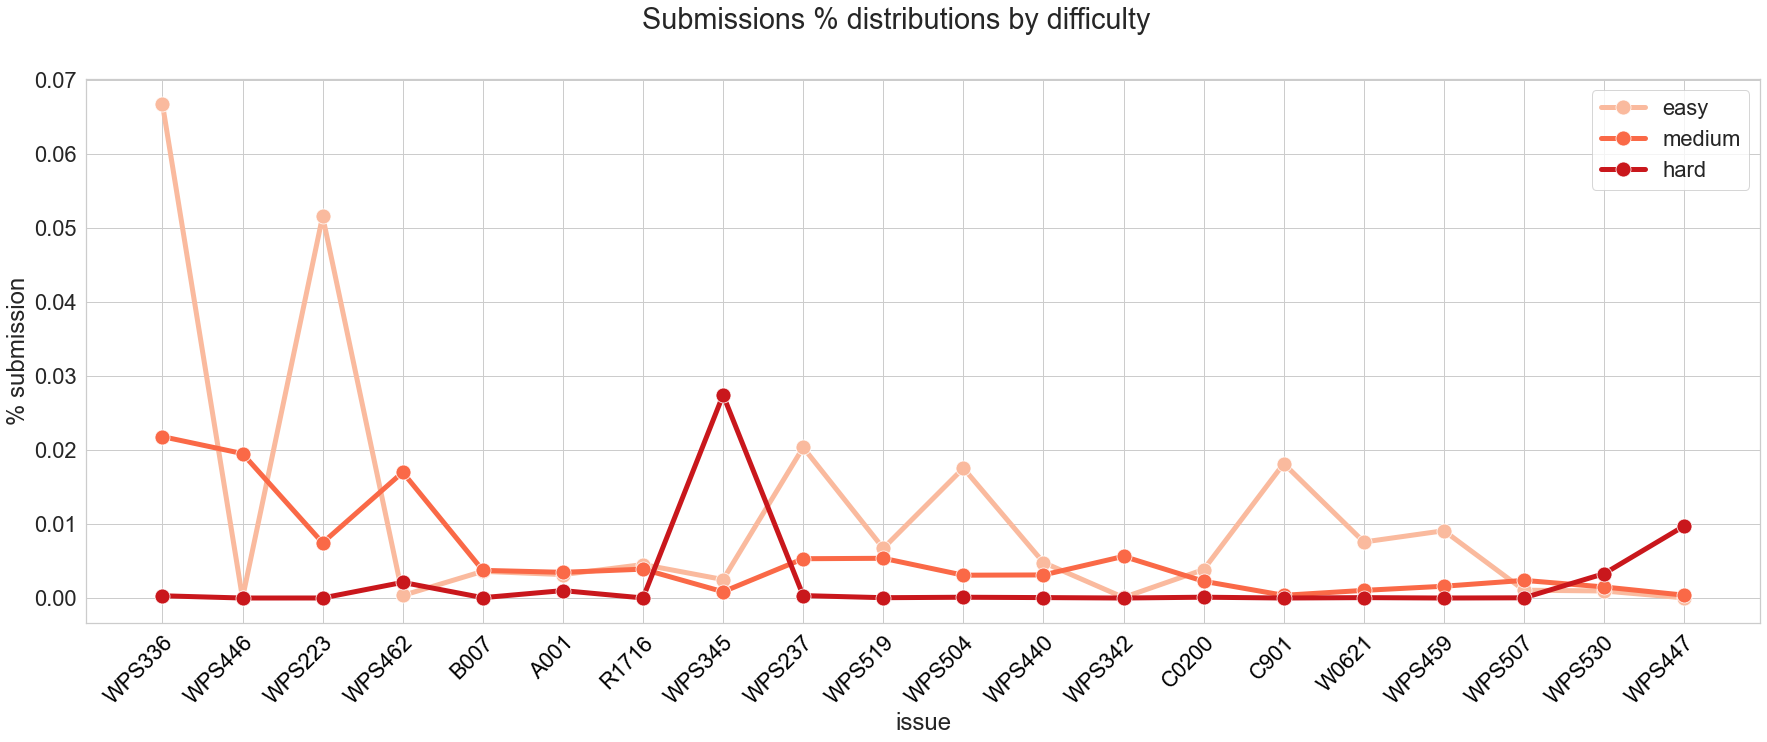

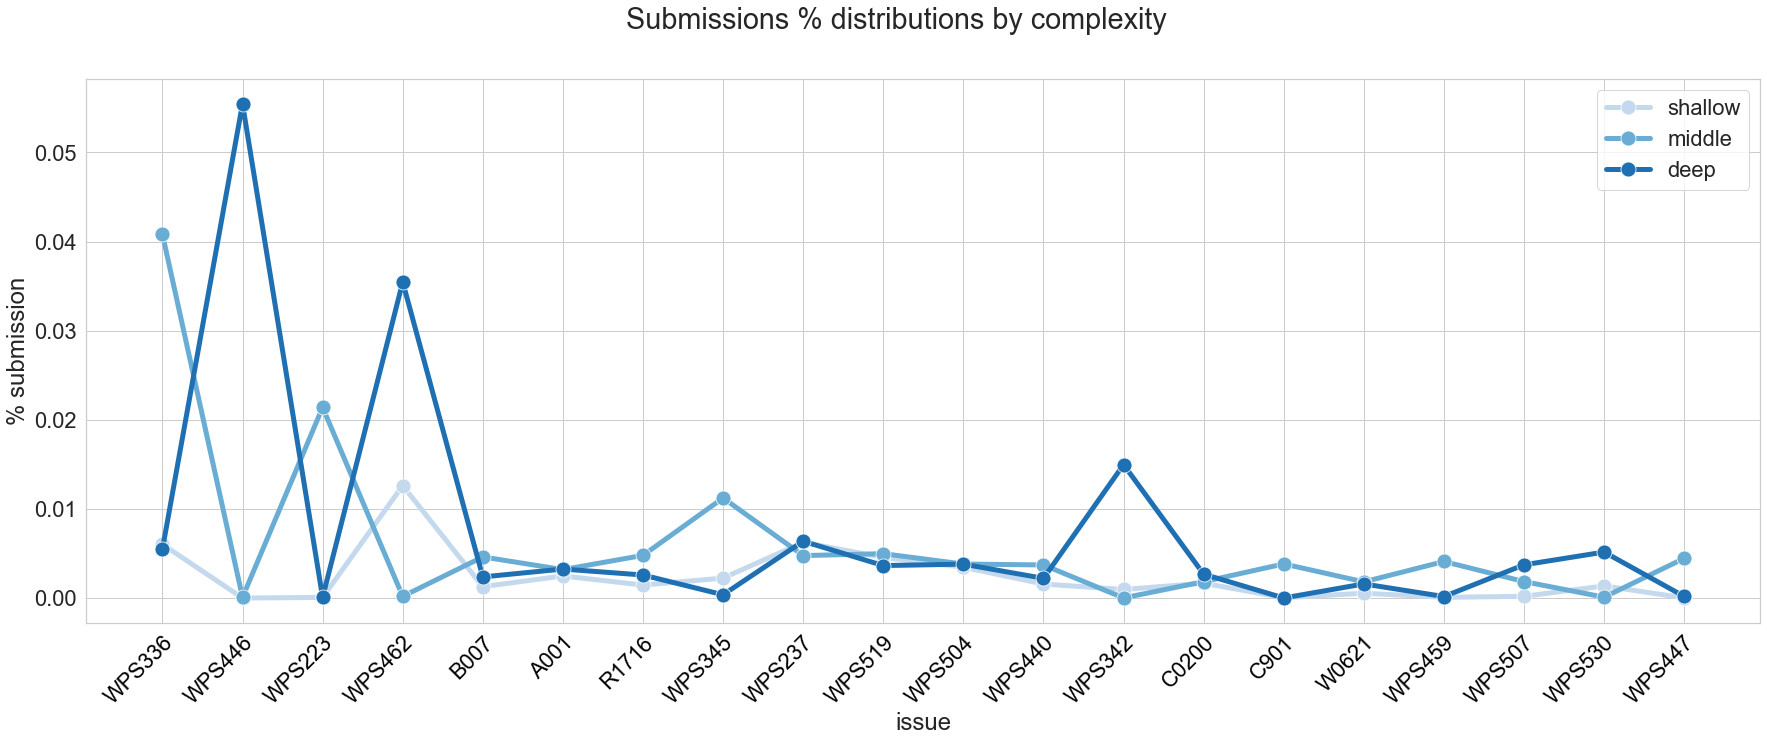

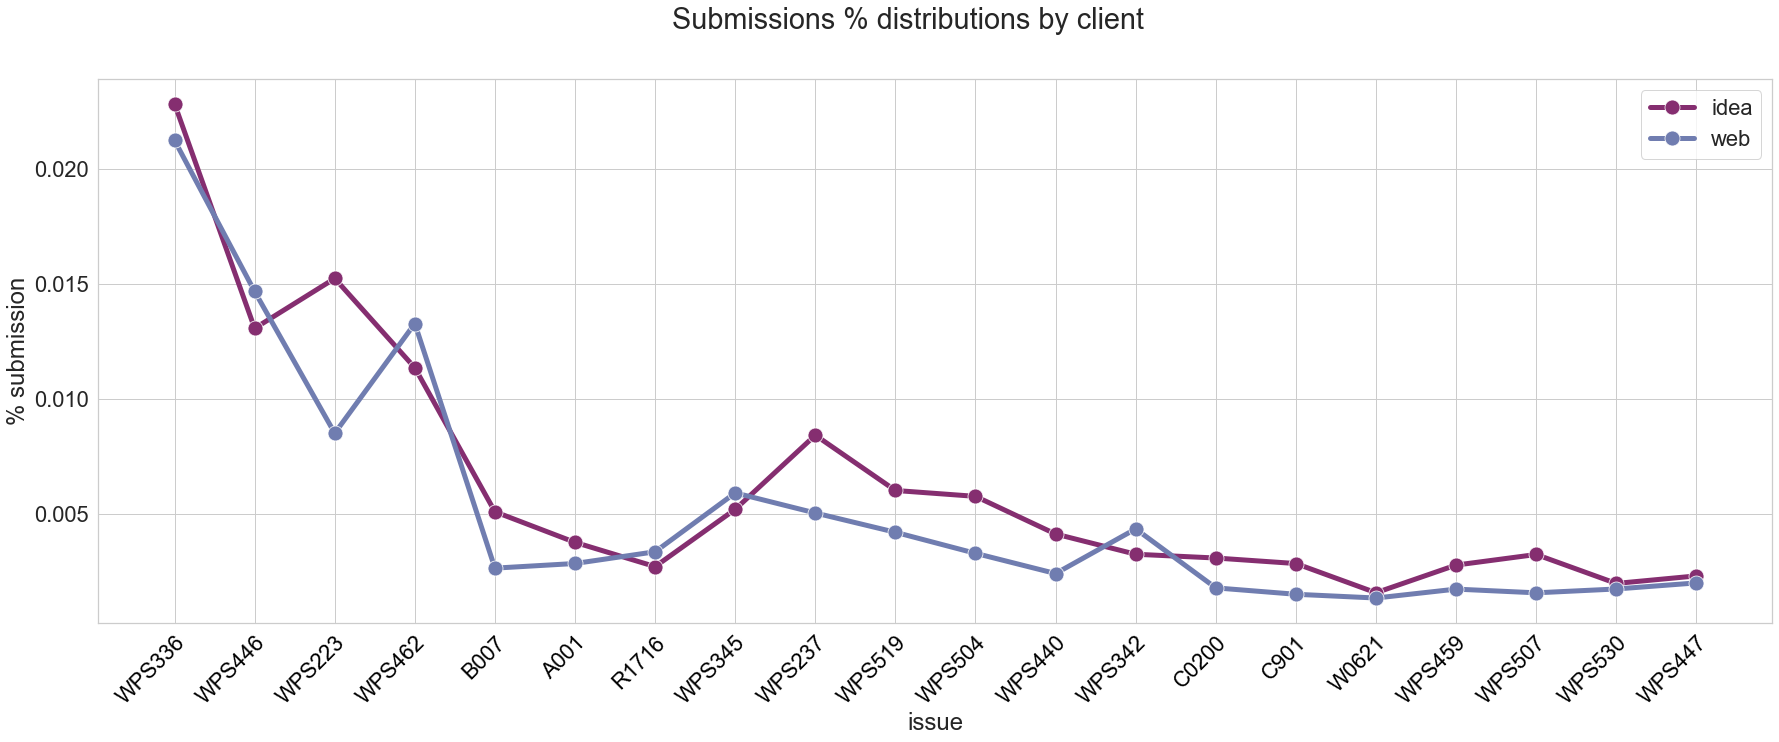

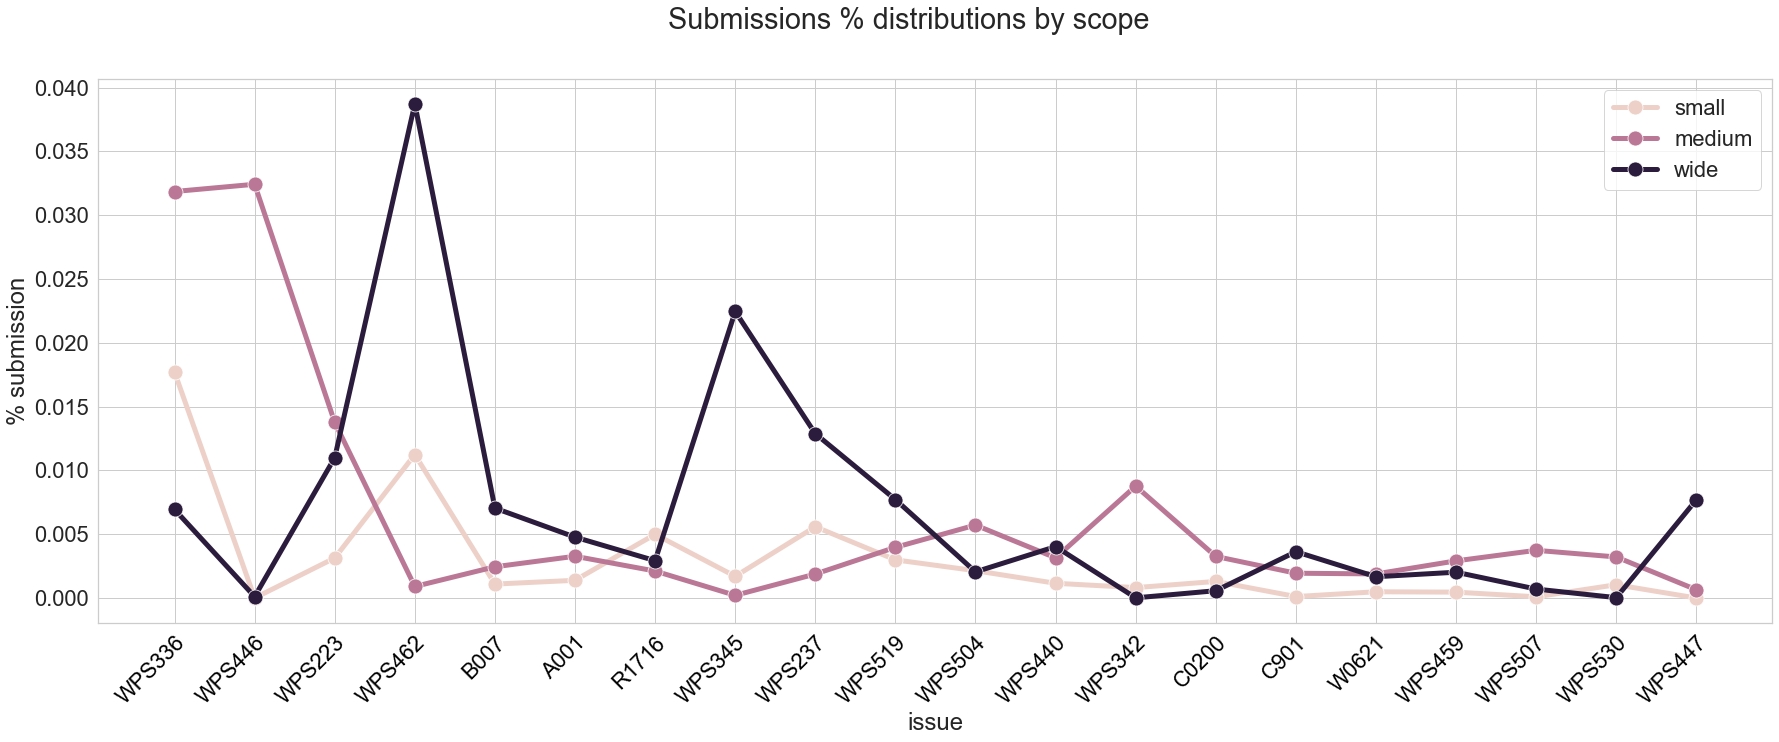

In [118]:
draw_issues(df_last_attempt_hyperstyle_issues_stats_unique, 
            df_hyperstyle_issues_top, 
            hyperstyle_issues_info_names,
            base_dir=LAST_ATTEMPT_STATS_PATH)

In [119]:
df_single_attempt_hyperstyle_issues_top = get_top_issues(
    df_first_attempt_hyperstyle_issues_stats_unique[df_first_attempt_hyperstyle_issues_stats_unique['total_attempts'] == 1],
    df_hyperstyle_issues, 
    len(df_first_attempt_hyperstyle_issues_top), 
    hyperstyle_issues_ignore_names)

df_single_attempt_hyperstyle_issues_top = sort_by_order(df_single_attempt_hyperstyle_issues_top,
                                                      'name',
                                                      df_first_attempt_hyperstyle_issues_top['name'].values)
                                                       
df_single_attempt_hyperstyle_issues_top.to_csv(os.path.join(FIRST_LAST_ATTEMPT_STATS_PATH, 
                                                            f'single_attempt_top_issues.csv'), index=False)
df_single_attempt_hyperstyle_issues_top

name  count        category  \
0   WPS336  20062  BEST_PRACTICES   
1   WPS446  16238  BEST_PRACTICES   
2   WPS462  14314  BEST_PRACTICES   
3   WPS223   7925      COMPLEXITY   
4     B007   3030  BEST_PRACTICES   
5     A001   3011     ERROR_PRONE   
6   WPS345   5660  BEST_PRACTICES   
7    R1716   3118  BEST_PRACTICES   
8   WPS237   5347      COMPLEXITY   
9   WPS519   3468  BEST_PRACTICES   
10  WPS342   4455  BEST_PRACTICES   
11  WPS504   3172  BEST_PRACTICES   
12  WPS440   2210     ERROR_PRONE   
13   C0200   1816  BEST_PRACTICES   
14    C901   1446      COMPLEXITY   
15   W0621   1340  BEST_PRACTICES   
16  WPS447   2171  BEST_PRACTICES   
17  WPS459   1623  BEST_PRACTICES   
18  WPS530   1434  BEST_PRACTICES   
19  WPS507   1528  BEST_PRACTICES   

                                                 text difficulty  \
0                 Found explicit string concatenation     MEDIUM   
1                    Found approximate constant: 2.71     MEDIUM   
2                        Wrong multiline string usage     MEDIUM   
3               Found too many `elif` branches: 7 > 3       HARD   
4   Loop control variable 'i' not used within the ...     MEDIUM   
5        variable "str" is shadowing a python builtin       HARD   
6                  Found meaningless number operation     MEDIUM   
7    Simplify chained comparison between the operands     MEDIUM   
8                      Found a too complex `f` string       HARD   
9                         Found implicit `sum()` call     MEDIUM   
10                  Found implicit raw string: "\\\\"     MEDIUM   
11                            Found negated condition     MEDIUM   
12                   Found block variables overlap: i       HARD   
13  Consider using enumerate instead of iterating ...     MEDIUM   
14  Too complex function. You can figure out how t...       HARD   
15  Redefining name 'title' from outer scope (line 9)     MEDIUM   
16  Found alphabet as strings: abcdefghijklmnopqrs...     MEDIUM   
17      Found comparison with float or complex number     MEDIUM   
18                      Found implicit negative index     MEDIUM   
19                      Found useless `len()` compare     MEDIUM   

                                          code_sample     ratio  
0   name = input()\nprint("Hello, " + name) # WPS3...  0.019854  
1   print(type("int"))\nprint(type(394))\nprint(ty...  0.016070  
2   print("""' '' ''' # WPS462 line=1 offset=6\n' ...  0.014166  
3   num1, num2, op = float(input()), float(input()...  0.007843  
4   n = int(input())\n\nfor i in range(n): # B007 ...  0.002999  
5   # put your python code here\nstr = input() # A...  0.002980  
6               print(1*2*3) # WPS345 line=1 offset=7  0.005601  
7   num = float(input())\n\nif num < 2:\n    print...  0.003086  
8   word = input()\nprint(f"{word} has {len(word)}...  0.005292  
9   # put your code here\nn = input()\nresult = 0\...  0.003432  
10             print("\\\\") # WPS342 line=1 offset=7  0.004409  
11  A =eval(input(""))\nB = eval(input(""))\nres =...  0.003139  
12  n = int(input())\n\nmy_stack = []\nmy_stack2 =...  0.002187  
13  inp = input()\nfor i in range(len(inp)): # C02...  0.001797  
14  string = input()\nfor c in string: # C901 line...  0.001431  
15  class Painting:\n    musuem = "Louvre"\n    \n...  0.001326  
16  alphabet = 'abcdefghijklmnopqrstuvwxyz' # WPS4...  0.002149  
17  def compare(numerator, denominator):\n    retu...  0.001606  
18  sentence = input()\nprint(sentence[len(sentenc...  0.001419  
19  numbers = input().split()\nnumber = input()\np...  0.001512

In [120]:
df_first_last_attempt_hyperstyle_issues_top = pd.merge(
    df_first_attempt_hyperstyle_issues_top[['name', 'count', 'category']], 
    df_last_attempt_hyperstyle_issues_top[['name', 'count', 'category']], 
    left_on=['name', 'category'], right_on=['name', 'category'], suffixes=('_first', '_last'))

df_first_last_attempt_hyperstyle_issues_top = pd.merge(
    df_first_last_attempt_hyperstyle_issues_top, 
    df_single_attempt_hyperstyle_issues_top[['name', 'count', 'category']].rename(
        columns={'count': 'count_single_attempt', 'ratio': 'ratio_single_attempt'}),
    left_on=['name', 'category'], right_on=['name', 'category'])

df_first_last_attempt_hyperstyle_issues_top

name  count_first        category  count_last  count_single_attempt
0   WPS336        25061  BEST_PRACTICES       24792                 20062
1   WPS446        16650  BEST_PRACTICES       16596                 16238
2   WPS462        14905  BEST_PRACTICES       14926                 14314
3   WPS223        11579      COMPLEXITY       11121                  7925
4     B007         8333  BEST_PRACTICES        3522                  3030
5     A001         7881     ERROR_PRONE        3455                  3011
6   WPS345         6832  BEST_PRACTICES        6674                  5660
7    R1716         6811  BEST_PRACTICES        3737                  3118
8   WPS237         6462      COMPLEXITY        6468                  5347
9   WPS519         5400  BEST_PRACTICES        5195                  3468
10  WPS342         4750  BEST_PRACTICES        4794                  4455
11  WPS504         4361  BEST_PRACTICES        4269                  3172
12  WPS440         3715     ERROR_PRONE        3108                  2210
13   C0200         3655  BEST_PRACTICES        2307                  1816
14    C901         2947      COMPLEXITY        1994                  1446
15   W0621         2742  BEST_PRACTICES        1590                  1340
16  WPS447         2416  BEST_PRACTICES        2362                  2171
17  WPS459         2238  BEST_PRACTICES        2196                  1623
18  WPS530         2231  BEST_PRACTICES        2045                  1434
19  WPS507         2165  BEST_PRACTICES        2131                  1528

In [121]:
df_first_last_attempt_hyperstyle_issues_top['count_first_not_single'] = \
    df_first_last_attempt_hyperstyle_issues_top['count_first'] - \
    df_first_last_attempt_hyperstyle_issues_top['count_single_attempt']

df_first_last_attempt_hyperstyle_issues_top['count_last_not_single'] = \
    df_first_last_attempt_hyperstyle_issues_top['count_last'] - \
    df_first_last_attempt_hyperstyle_issues_top['count_single_attempt']
    
df_first_last_attempt_hyperstyle_issues_top['count_diff'] = \
    df_first_last_attempt_hyperstyle_issues_top['count_first_not_single'] - \
    df_first_last_attempt_hyperstyle_issues_top['count_last_not_single']

df_first_last_attempt_hyperstyle_issues_top['ratio_left'] = \
    df_first_last_attempt_hyperstyle_issues_top['count_last_not_single'] / \
    df_first_last_attempt_hyperstyle_issues_top['count_first_not_single']

df_first_last_attempt_hyperstyle_issues_top = df_first_last_attempt_hyperstyle_issues_top \
    .sort_values(by='ratio_left')

df_first_last_attempt_hyperstyle_issues_top.to_csv(os.path.join(FIRST_LAST_ATTEMPT_STATS_PATH, 
                                                                f'top_issues.csv'), index=False)
df_first_last_attempt_hyperstyle_issues_top

name  count_first        category  count_last  count_single_attempt  \
5     A001         7881     ERROR_PRONE        3455                  3011   
4     B007         8333  BEST_PRACTICES        3522                  3030   
7    R1716         6811  BEST_PRACTICES        3737                  3118   
15   W0621         2742  BEST_PRACTICES        1590                  1340   
13   C0200         3655  BEST_PRACTICES        2307                  1816   
14    C901         2947      COMPLEXITY        1994                  1446   
12  WPS440         3715     ERROR_PRONE        3108                  2210   
18  WPS530         2231  BEST_PRACTICES        2045                  1434   
16  WPS447         2416  BEST_PRACTICES        2362                  2171   
6   WPS345         6832  BEST_PRACTICES        6674                  5660   
1   WPS446        16650  BEST_PRACTICES       16596                 16238   
3   WPS223        11579      COMPLEXITY       11121                  7925   
9   WPS519         5400  BEST_PRACTICES        5195                  3468   
11  WPS504         4361  BEST_PRACTICES        4269                  3172   
17  WPS459         2238  BEST_PRACTICES        2196                  1623   
0   WPS336        25061  BEST_PRACTICES       24792                 20062   
19  WPS507         2165  BEST_PRACTICES        2131                  1528   
8   WPS237         6462      COMPLEXITY        6468                  5347   
2   WPS462        14905  BEST_PRACTICES       14926                 14314   
10  WPS342         4750  BEST_PRACTICES        4794                  4455   

    count_first_not_single  count_last_not_single  count_diff  ratio_left  
5                     4870                    444        4426    0.091170  
4                     5303                    492        4811    0.092778  
7                     3693                    619        3074    0.167614  
15                    1402                    250        1152    0.178317  
13                    1839                    491        1348    0.266993  
14                    1501                    548         953    0.365090  
12                    1505                    898         607    0.596678  
18                     797                    611         186    0.766625  
16                     245                    191          54    0.779592  
6                     1172                   1014         158    0.865188  
1                      412                    358          54    0.868932  
3                     3654                   3196         458    0.874658  
9                     1932                   1727         205    0.893892  
11                    1189                   1097          92    0.922624  
17                     615                    573          42    0.931707  
0                     4999                   4730         269    0.946189  
19                     637                    603          34    0.946625  
8                     1115                   1121          -6    1.005381  
2                      591                    612         -21    1.035533  
10                     295                    339         -44    1.149153

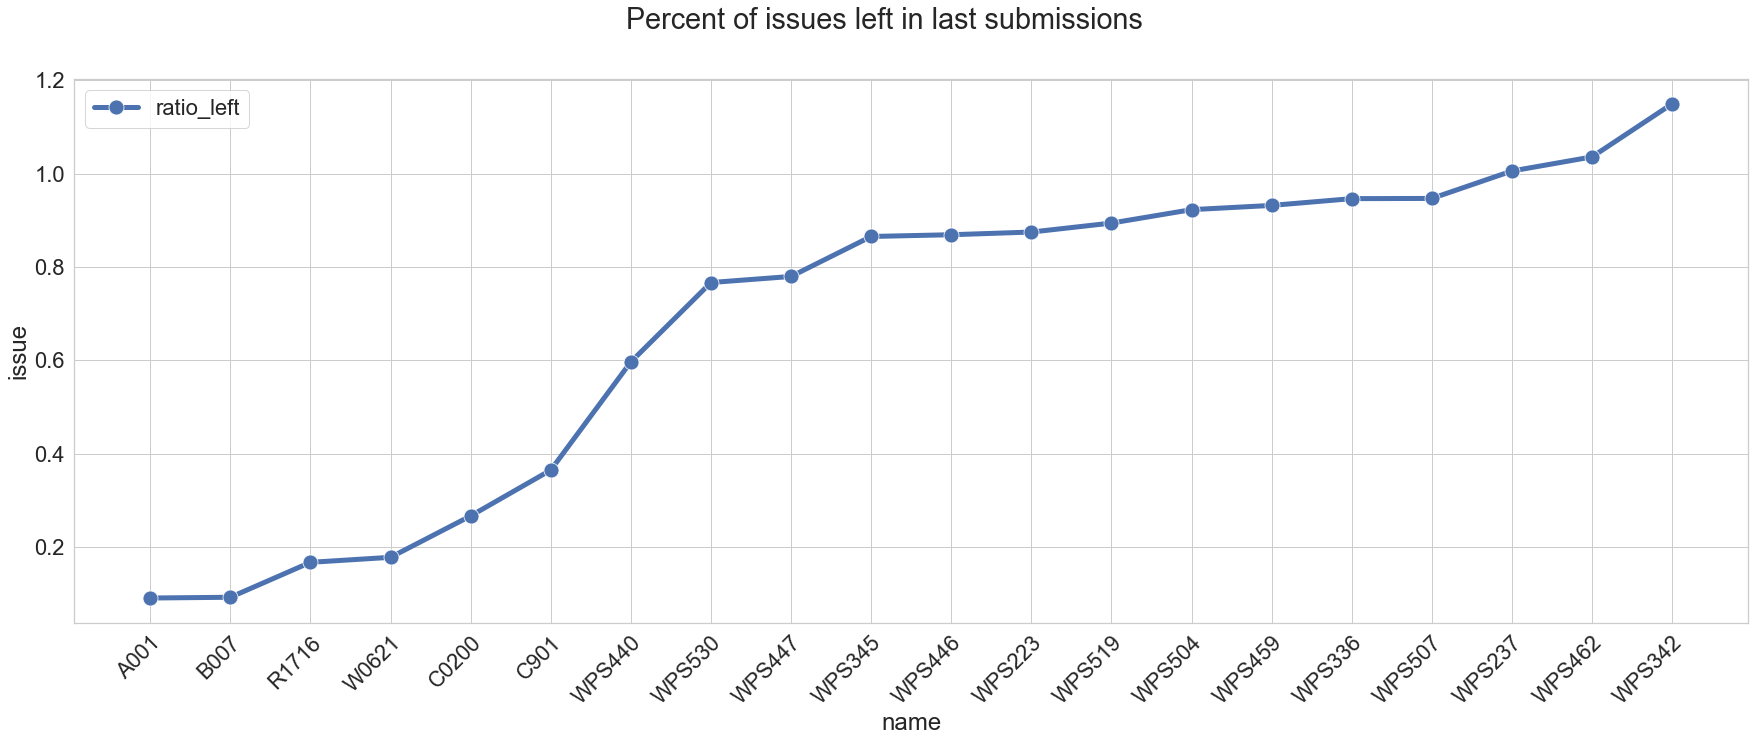

In [122]:
draw_compare(df_first_last_attempt_hyperstyle_issues_top, 
             'name', ['ratio', ['ratio_left']], 
             y_label='issue', 
             title='Percent of issues left in last submissions', 
             save_path=os.path.join(FIRST_LAST_ATTEMPT_STATS_PATH, f'top_issues.pdf'))

# Submission series (groups) analysis
To pass the step user can make several attemps. The ordered sequence of attemps in **submission series**. In this section you can find analysis of the student progess on code quality issues fixing. 

### Number of submission series by total number of attempts in series

In [123]:
df_last_attempt_stats['total_attempts'].value_counts()[:20]

1    1010454
2     105914
3      24917
4       8131
5       3155
Name: total_attempts, dtype: int64

In [124]:
def draw_feature_dynamic(feature: str, max_attempts: int = 5, exact_attempts: bool = False, is_mean=True):
    for attr in ['difficulty', 'complexity', 'client', 'scope']:
        df_dynamic = get_submissions_series_dynamic_by_feature(df_hyperstyle_issues_stats, feature, attr, 
                                                               max_attempts=max_attempts)
#         uncomment to save stats to csv
#         df_dynamic.to_csv(f'{feature}_dynamic_{attr}.csv', index=False)
        draw_compare(df_dynamic, 'attempt', attr, y_label=f'mean\n{feature}', title=f'{feature} dynamic by attemps')

## Average number of hyperstyle issues by each attempt
For all submission series, we calculate mean number of issues made on i-th attempt. The plots show that from attempt to attempt the number of issues in students’ solutions decreases, regardless of the parameters of the student, steps on environment.

`exact_attempts` - if True than only submissions with `total_attempt` == `max_attempts` (so the number of submission for each attempt is equal) are selected othwise `total_attempt` <= `max_attempts` (so the number of submission for each attempt is decreasing)

In [125]:
df_hyperstyle_issues_stats['hyperstyle_issues_count'] = \
    df_hyperstyle_issues_stats[df_hyperstyle_issues_top['name'].values].sum(axis=1)

df_hyperstyle_issues_stats['hyperstyle_issues_count'].value_counts()

0     1189841
1      126279
2       16664
3        6515
4        2323
5        1492
6         717
7         397
11        306
8         190
12        161
10        135
9         119
15         49
16         39
13         30
18         18
24         16
14         15
20         11
17          5
19          5
22          3
26          1
27          1
Name: hyperstyle_issues_count, dtype: int64

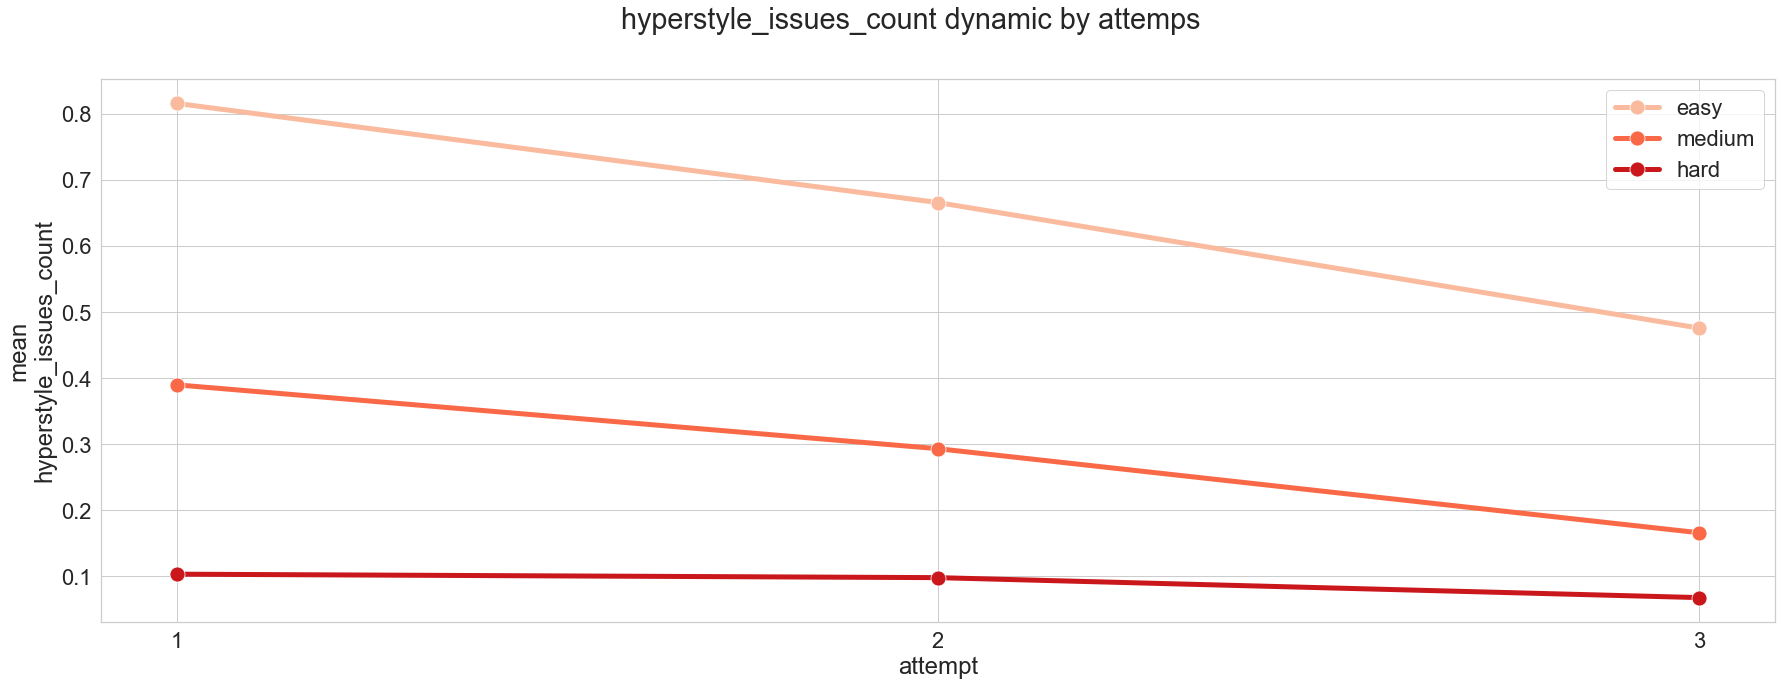

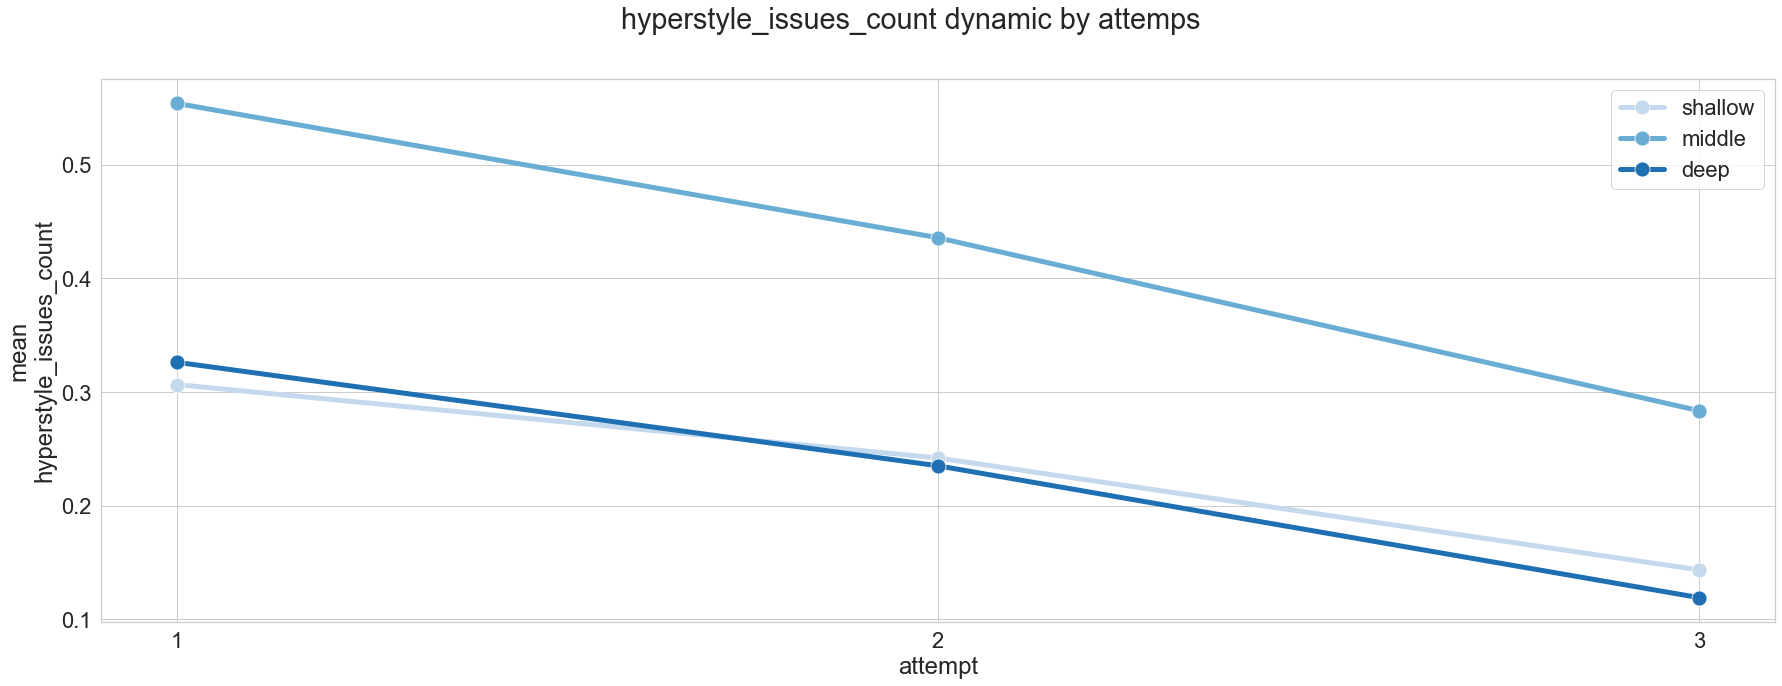

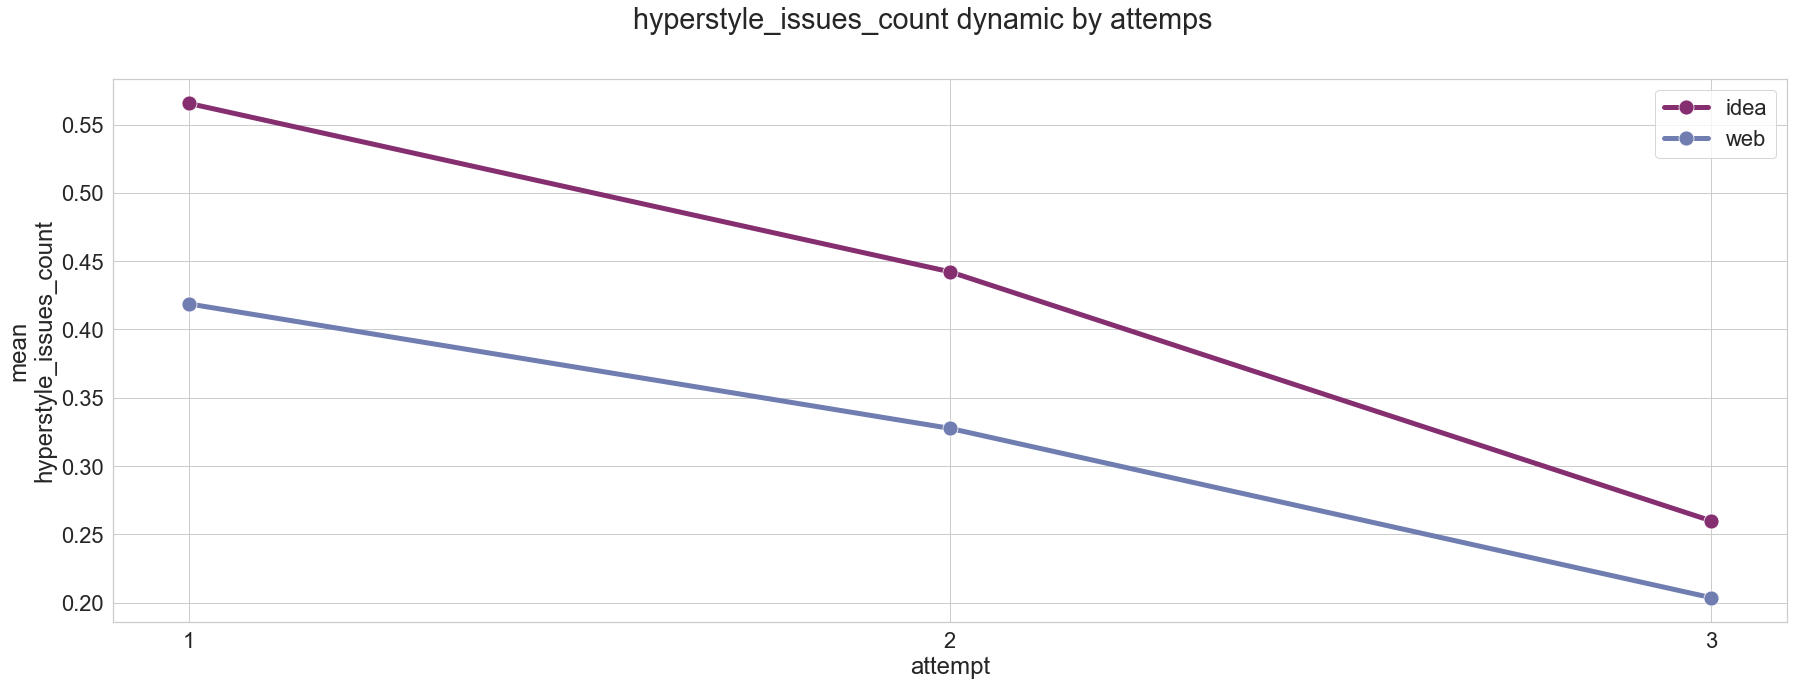

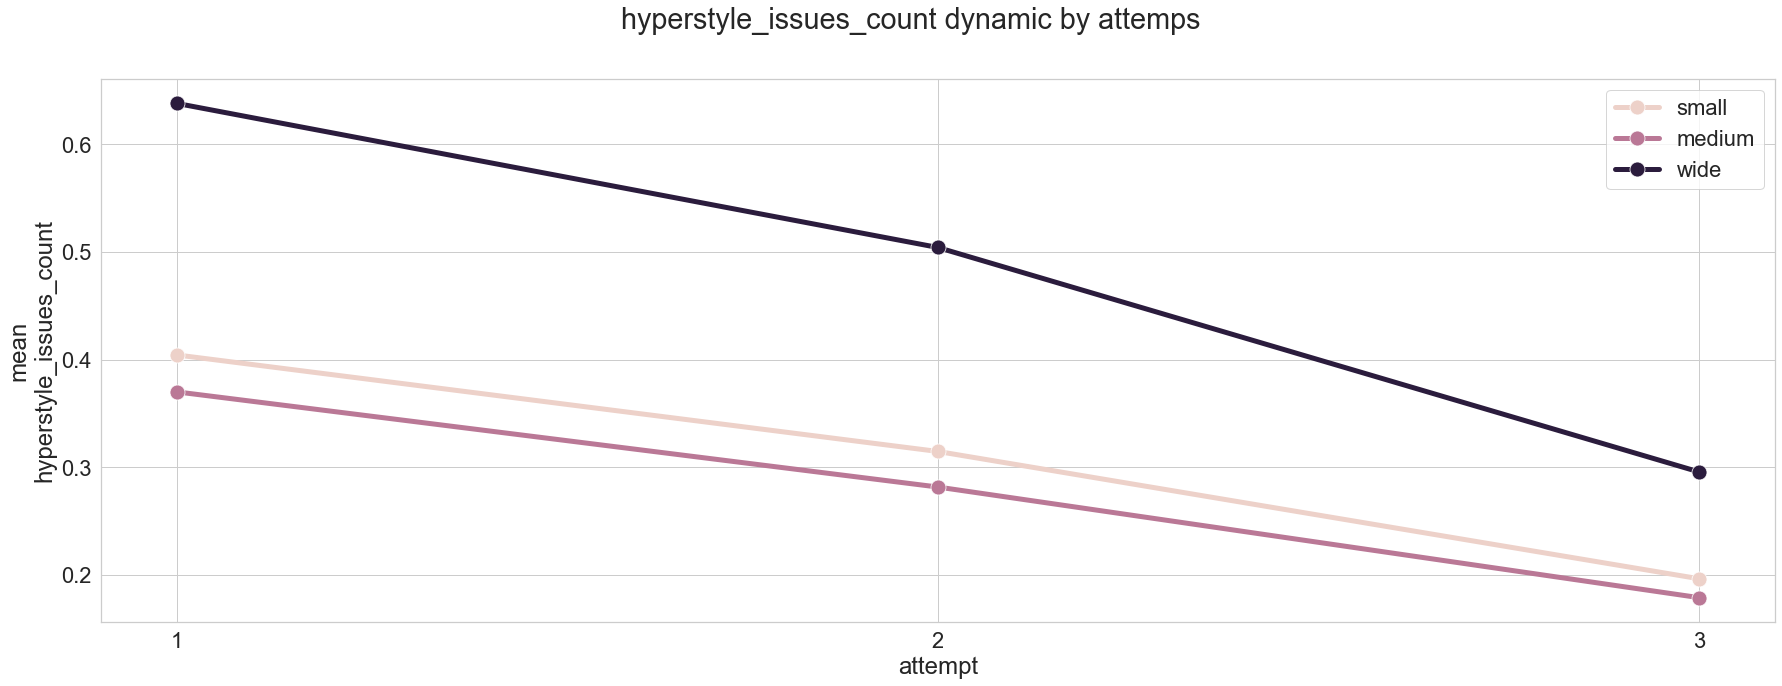

In [126]:
draw_feature_dynamic('hyperstyle_issues_count', max_attempts=3, exact_attempts=True)

## Submissions series dynamic
Plots show how average soution parameters change throught attemps 

### Dynamin for all sobmission series with total_attemps = 5

In [127]:
def draw_issues_dynamic(df: pd.DataFrame, df_issues: pd.DataFrame, max_attempts: int = 5,
                                          exact_attempts: bool = False, by_type=False, is_mean=True):
    df_issues_dynamic = get_submissions_series_issues_dynamic(df, df_issues, max_attempts, exact_attempts, 
                                                              by_type, is_mean)
    suffix = f'{max_attempts}' + ('_by_type' if by_type else '') + ('_exect' if exact_attempts else '')
    
    df_issues_dynamic.drop(columns=['attempt', 'count']).T \
        .to_csv(os.path.join(ISSUES_DYNAMIC_STATS_PATH, f'issues_dynamic_{suffix}.csv'), index=True)
    
    issues = df_issues['category' if by_type else 'name'].unique()
    draw_compare(df_issues_dynamic, 'attempt', ('issue', issues))
    return df_issues_dynamic.drop(columns=['attempt', 'count']).T

### Hypertyle issues dynamic by attempts (with issue names)
Percent of submission which contains each issue by attempts dynamic. The plot shows that in most cases all issues are decreras but it should be examined more precisely in csv file

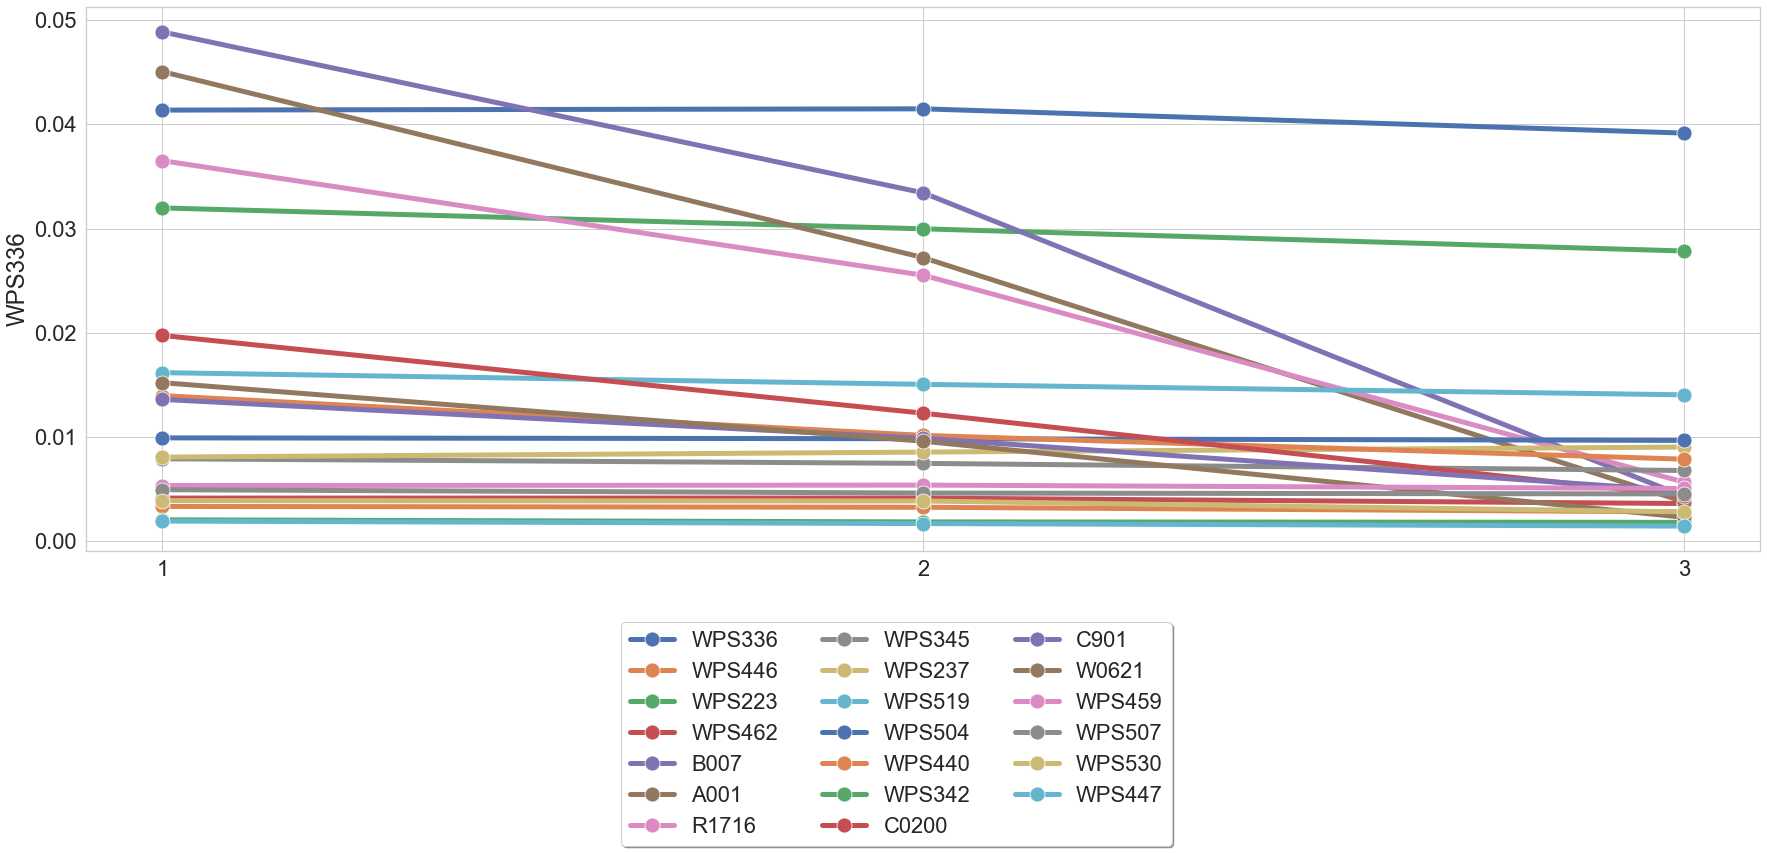

<Figure size 432x288 with 0 Axes>

0         1         2
WPS336  0.041377  0.041498  0.039170
WPS446  0.003331  0.003251  0.002809
WPS223  0.031986  0.029980  0.027852
WPS462  0.004134  0.004134  0.003612
B007    0.048882  0.033431  0.004294
A001    0.045070  0.027210  0.003773
R1716   0.036521  0.025525  0.005659
WPS345  0.007906  0.007465  0.006783
WPS237  0.008067  0.008548  0.009030
WPS519  0.016174  0.015050  0.014047
WPS504  0.009913  0.009833  0.009672
WPS440  0.013966  0.010154  0.007866
WPS342  0.002047  0.001846  0.001806
C0200   0.019746  0.012281  0.004334
C901    0.013605  0.009873  0.004816
W0621   0.015210  0.009592  0.002288
WPS459  0.005338  0.005378  0.005057
WPS507  0.004936  0.004615  0.004535
WPS530  0.003893  0.003853  0.002809
WPS447  0.001926  0.001686  0.001445

In [128]:
draw_issues_dynamic(df_hyperstyle_issues_stats_unique, 
                    df_hyperstyle_issues_top, 
                    max_attempts=3, 
                    exact_attempts=True)

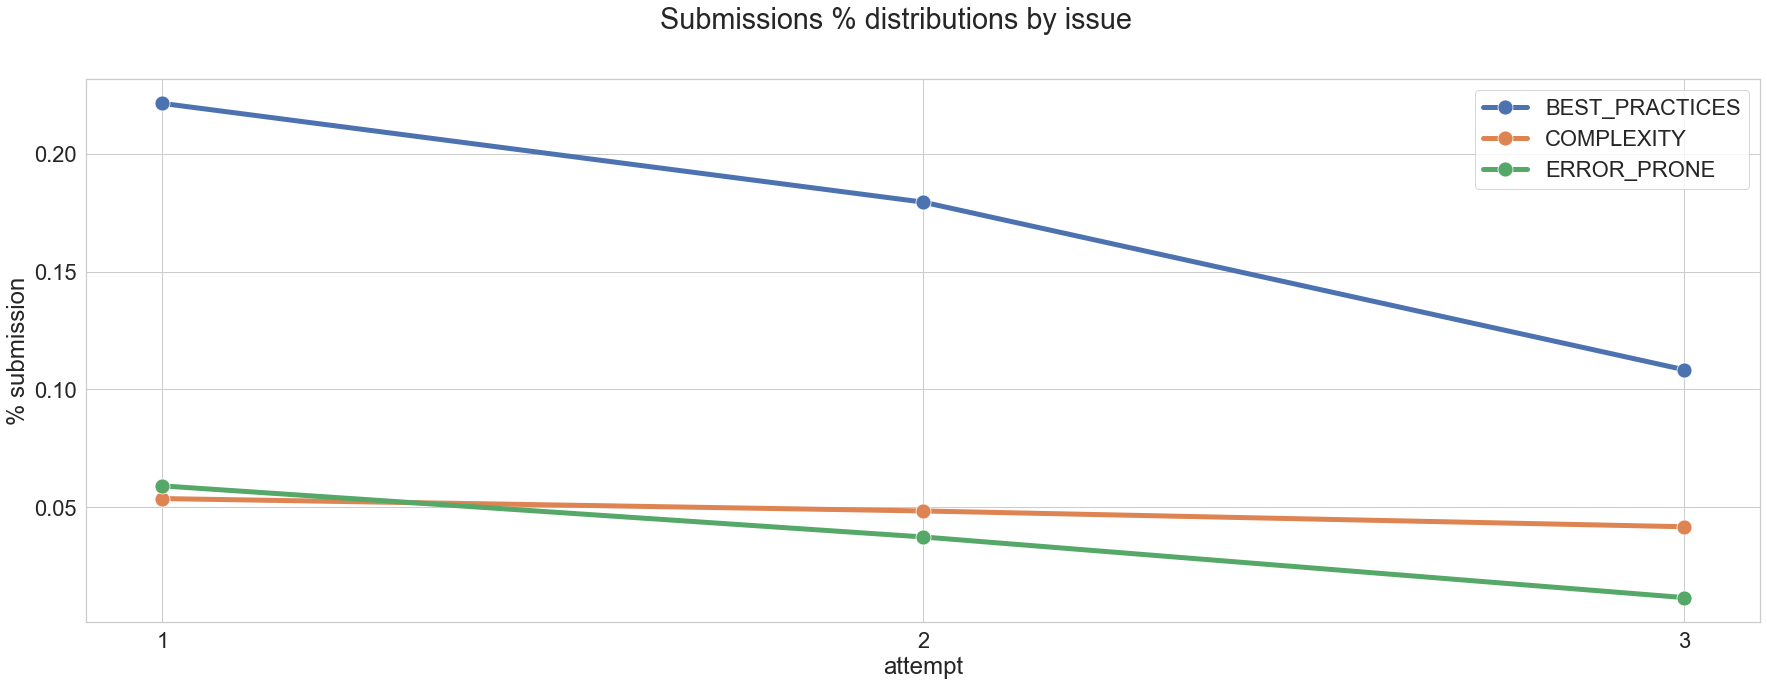

0         1         2
BEST_PRACTICES  0.221335  0.179436  0.108320
COMPLEXITY      0.053658  0.048401  0.041698
ERROR_PRONE     0.059036  0.037364  0.011639

In [129]:
draw_issues_dynamic(df_hyperstyle_issues_stats_unique, 
                    df_hyperstyle_issues_top, 
                    by_type=True, 
                    max_attempts=3, 
                    exact_attempts=True)

In [130]:
df_hyperstyle_issues_stats_unique['hypertysle_issues_count'] = \
    df_hyperstyle_issues_stats_unique[df_hyperstyle_issues_top['name'].values].sum(axis=1)

df_hyperstyle_issues_stats_unique['hypertysle_issues_count'].value_counts()

0    1189841
1     137957
2      14842
3       2523
4        165
5          4
Name: hypertysle_issues_count, dtype: int64

In [131]:
df_last_attempt_hyperstyle_issues_top = get_top_issues(df_last_attempt_hyperstyle_issues_stats_unique, 
                                          df_hyperstyle_issues, 
                                          len(df_hyperstyle_issues), 
                                          hyperstyle_issues_ignore_names)

df_last_attempt_hyperstyle_issues_top = sort_by_order(df_last_attempt_hyperstyle_issues_top,
                                                      'name',
                                                      df_first_attempt_hyperstyle_issues_top['name'].values)
                                                       
df_last_attempt_hyperstyle_issues_top.to_csv(os.path.join(LAST_ATTEMPT_STATS_PATH, f'top_issues.csv'), index=False)
df_last_attempt_hyperstyle_issues_top

name  count        category  \
0   WPS336  24792  BEST_PRACTICES   
1   WPS446  16596  BEST_PRACTICES   
2   WPS462  14926  BEST_PRACTICES   
3   WPS223  11121      COMPLEXITY   
4     B007   3522  BEST_PRACTICES   
5     A001   3455     ERROR_PRONE   
6   WPS345   6674  BEST_PRACTICES   
7    R1716   3737  BEST_PRACTICES   
8   WPS237   6468      COMPLEXITY   
9   WPS519   5195  BEST_PRACTICES   
10  WPS342   4794  BEST_PRACTICES   
11  WPS504   4269  BEST_PRACTICES   
12  WPS440   3108     ERROR_PRONE   
13   C0200   2307  BEST_PRACTICES   
14    C901   1994      COMPLEXITY   
15   W0621   1590  BEST_PRACTICES   
16  WPS447   2362  BEST_PRACTICES   
17  WPS459   2196  BEST_PRACTICES   
18  WPS530   2045  BEST_PRACTICES   
19  WPS507   2131  BEST_PRACTICES   

                                                 text difficulty  \
0                 Found explicit string concatenation     MEDIUM   
1                    Found approximate constant: 2.71     MEDIUM   
2                        Wrong multiline string usage     MEDIUM   
3               Found too many `elif` branches: 7 > 3       HARD   
4   Loop control variable 'i' not used within the ...     MEDIUM   
5        variable "str" is shadowing a python builtin       HARD   
6                  Found meaningless number operation     MEDIUM   
7    Simplify chained comparison between the operands     MEDIUM   
8                      Found a too complex `f` string       HARD   
9                         Found implicit `sum()` call     MEDIUM   
10                  Found implicit raw string: "\\\\"     MEDIUM   
11                            Found negated condition     MEDIUM   
12                   Found block variables overlap: i       HARD   
13  Consider using enumerate instead of iterating ...     MEDIUM   
14  Too complex function. You can figure out how t...       HARD   
15  Redefining name 'title' from outer scope (line 9)     MEDIUM   
16  Found alphabet as strings: abcdefghijklmnopqrs...     MEDIUM   
17      Found comparison with float or complex number     MEDIUM   
18                      Found implicit negative index     MEDIUM   
19                      Found useless `len()` compare     MEDIUM   

                                          code_sample     ratio  
0   name = input()\nprint("Hello, " + name) # WPS3...  0.021510  
1   print(type("int"))\nprint(type(394))\nprint(ty...  0.014399  
2   print("""' '' ''' # WPS462 line=1 offset=6\n' ...  0.012950  
3   num1, num2, op = float(input()), float(input()...  0.009649  
4   n = int(input())\n\nfor i in range(n): # B007 ...  0.003056  
5   # put your python code here\nstr = input() # A...  0.002998  
6               print(1*2*3) # WPS345 line=1 offset=7  0.005791  
7   num = float(input())\n\nif num < 2:\n    print...  0.003242  
8   word = input()\nprint(f"{word} has {len(word)}...  0.005612  
9   # put your code here\nn = input()\nresult = 0\...  0.004507  
10             print("\\\\") # WPS342 line=1 offset=7  0.004159  
11  A =eval(input(""))\nB = eval(input(""))\nres =...  0.003704  
12  n = int(input())\n\nmy_stack = []\nmy_stack2 =...  0.002697  
13  inp = input()\nfor i in range(len(inp)): # C02...  0.002002  
14  string = input()\nfor c in string: # C901 line...  0.001730  
15  class Painting:\n    musuem = "Louvre"\n    \n...  0.001380  
16  alphabet = 'abcdefghijklmnopqrstuvwxyz' # WPS4...  0.002049  
17  def compare(numerator, denominator):\n    retu...  0.001905  
18  sentence = input()\nprint(sentence[len(sentenc...  0.001774  
19  numbers = input().split()\nnumber = input()\np...  0.001849

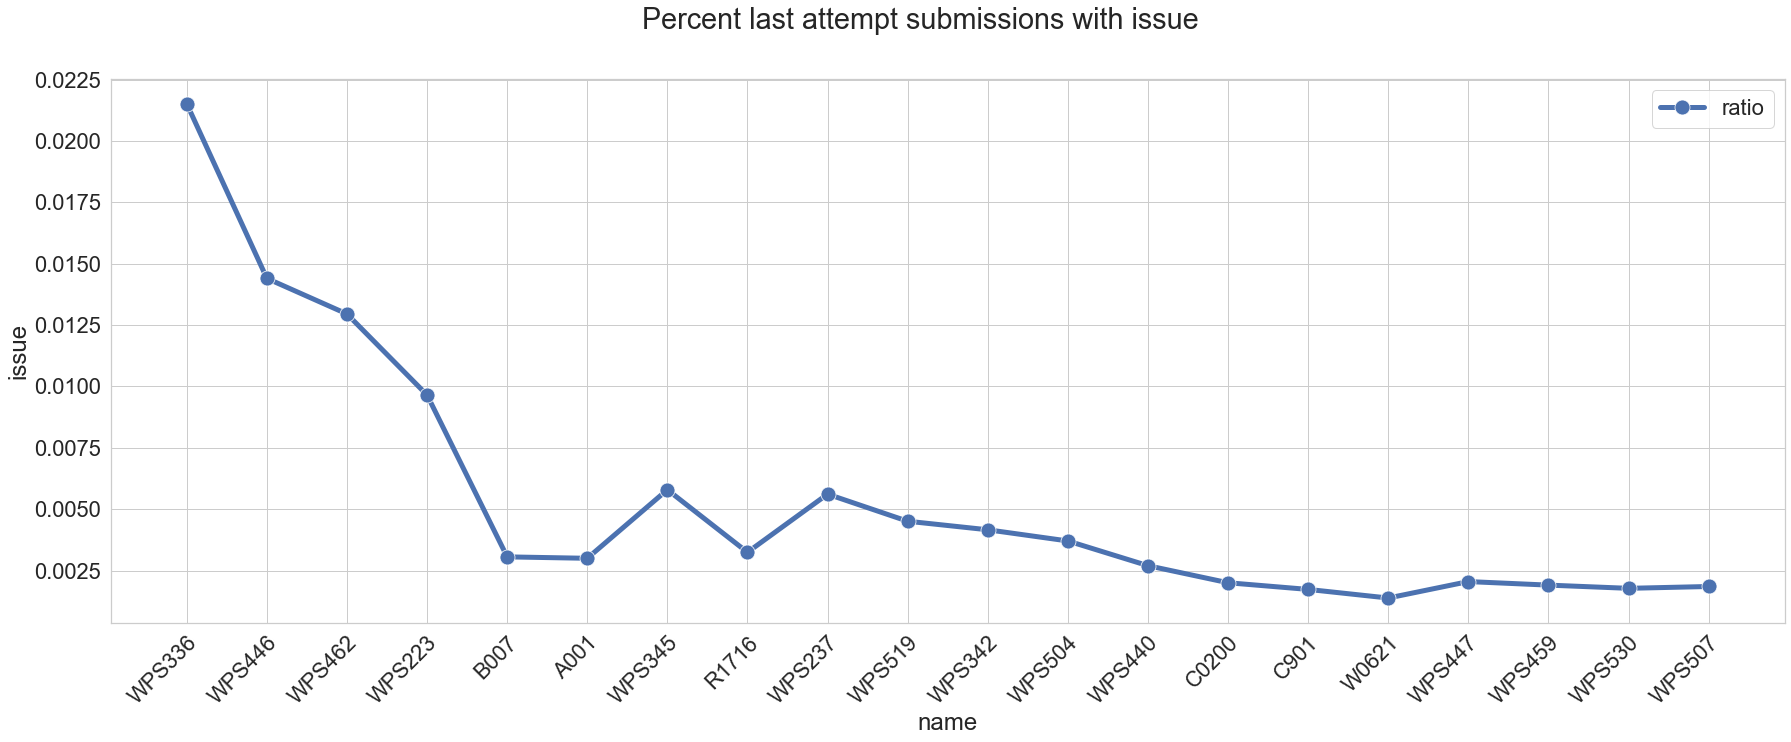

In [132]:
draw_compare(df_last_attempt_hyperstyle_issues_top, 'name', ['ratio', ['ratio']], 
             y_label='issue', 
             title='Percent last attempt submissions with issue', 
             save_path=os.path.join(LAST_ATTEMPT_STATS_PATH, f'top_issues.pdf'))

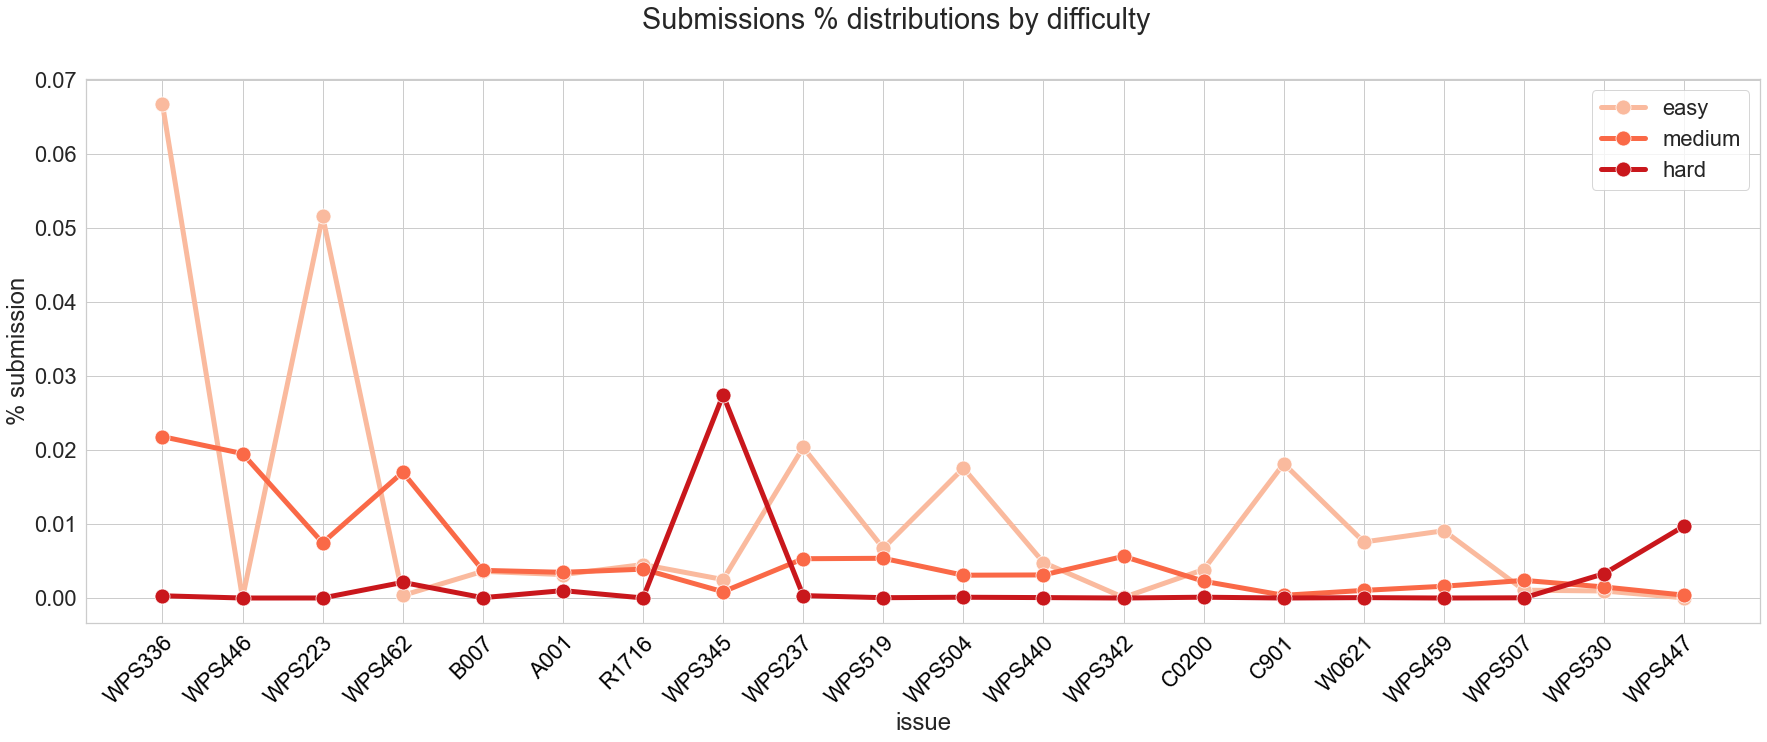

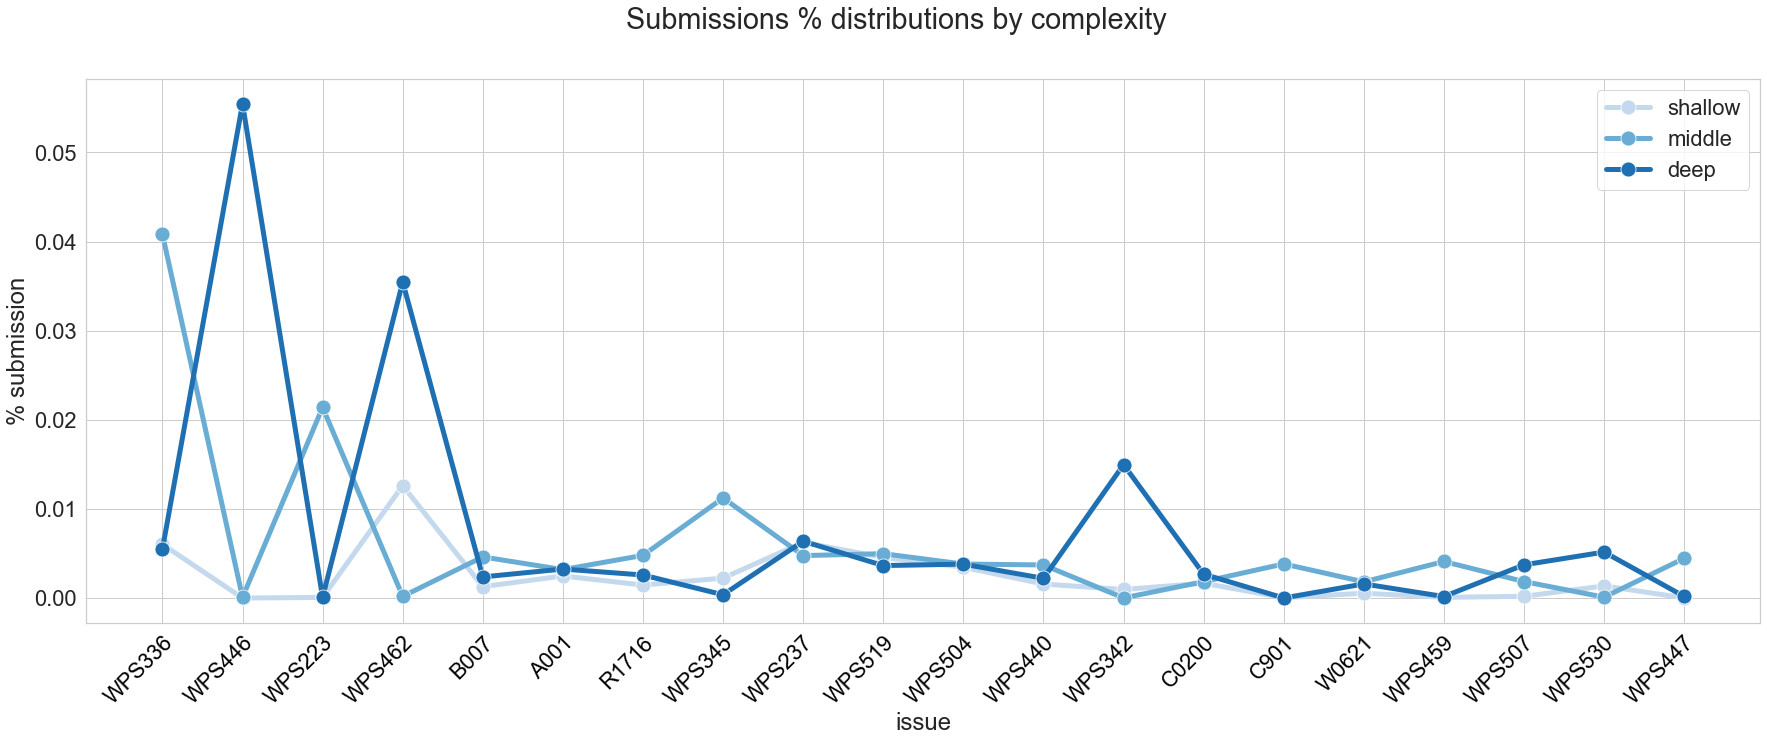

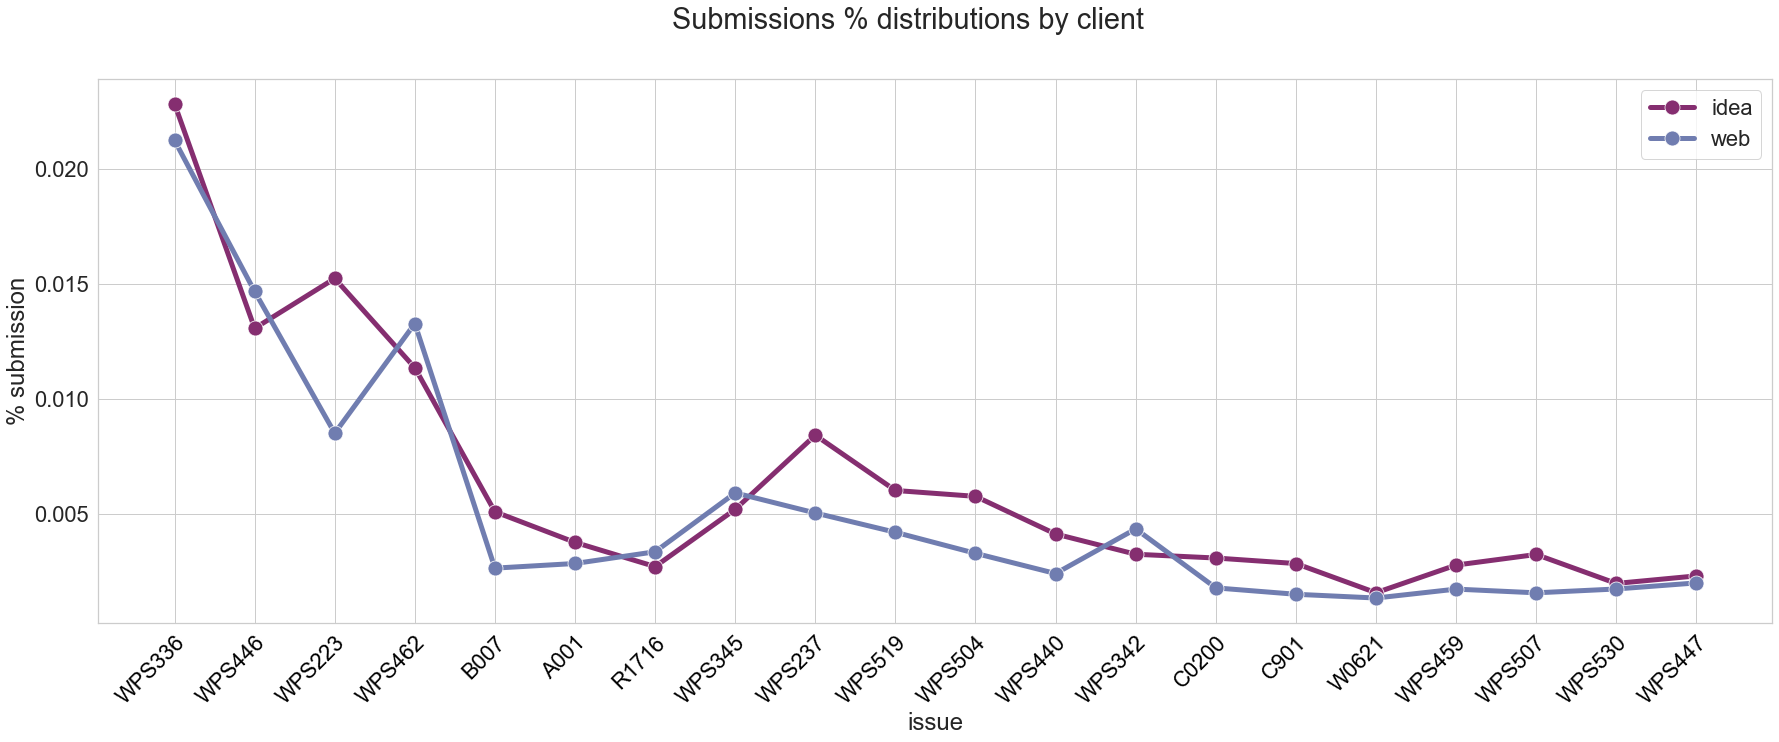

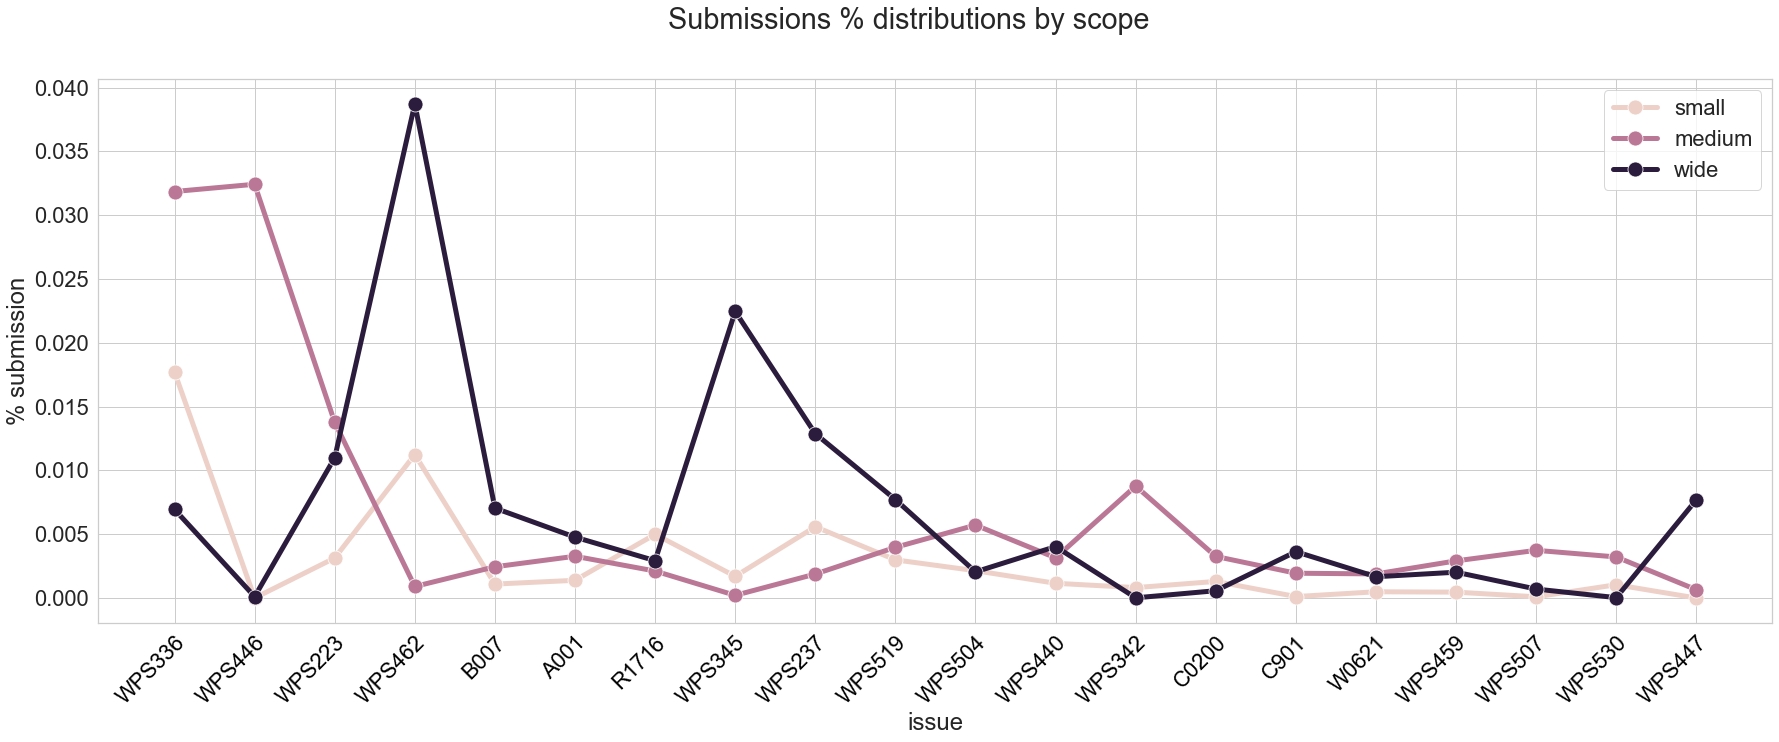

In [133]:
draw_issues(df_last_attempt_hyperstyle_issues_stats_unique, 
            df_hyperstyle_issues_top, 
            hyperstyle_issues_info_names,
            base_dir=LAST_ATTEMPT_STATS_PATH)

In [134]:
df_single_attempt_hyperstyle_issues_top = get_top_issues(
    df_first_attempt_hyperstyle_issues_stats_unique[df_first_attempt_hyperstyle_issues_stats_unique['total_attempts'] == 1],
    df_hyperstyle_issues, 
    len(df_first_attempt_hyperstyle_issues_top), 
    hyperstyle_issues_ignore_names)

df_single_attempt_hyperstyle_issues_top = sort_by_order(df_single_attempt_hyperstyle_issues_top,
                                                      'name',
                                                      df_first_attempt_hyperstyle_issues_top['name'].values)
                                                       
df_single_attempt_hyperstyle_issues_top.to_csv(os.path.join(FIRST_LAST_ATTEMPT_STATS_PATH, 
                                                            f'single_attempt_top_issues.csv'), index=False)
df_single_attempt_hyperstyle_issues_top

name  count        category  \
0   WPS336  20062  BEST_PRACTICES   
1   WPS446  16238  BEST_PRACTICES   
2   WPS462  14314  BEST_PRACTICES   
3   WPS223   7925      COMPLEXITY   
4     B007   3030  BEST_PRACTICES   
5     A001   3011     ERROR_PRONE   
6   WPS345   5660  BEST_PRACTICES   
7    R1716   3118  BEST_PRACTICES   
8   WPS237   5347      COMPLEXITY   
9   WPS519   3468  BEST_PRACTICES   
10  WPS342   4455  BEST_PRACTICES   
11  WPS504   3172  BEST_PRACTICES   
12  WPS440   2210     ERROR_PRONE   
13   C0200   1816  BEST_PRACTICES   
14    C901   1446      COMPLEXITY   
15   W0621   1340  BEST_PRACTICES   
16  WPS447   2171  BEST_PRACTICES   
17  WPS459   1623  BEST_PRACTICES   
18  WPS530   1434  BEST_PRACTICES   
19  WPS507   1528  BEST_PRACTICES   

                                                 text difficulty  \
0                 Found explicit string concatenation     MEDIUM   
1                    Found approximate constant: 2.71     MEDIUM   
2                        Wrong multiline string usage     MEDIUM   
3               Found too many `elif` branches: 7 > 3       HARD   
4   Loop control variable 'i' not used within the ...     MEDIUM   
5        variable "str" is shadowing a python builtin       HARD   
6                  Found meaningless number operation     MEDIUM   
7    Simplify chained comparison between the operands     MEDIUM   
8                      Found a too complex `f` string       HARD   
9                         Found implicit `sum()` call     MEDIUM   
10                  Found implicit raw string: "\\\\"     MEDIUM   
11                            Found negated condition     MEDIUM   
12                   Found block variables overlap: i       HARD   
13  Consider using enumerate instead of iterating ...     MEDIUM   
14  Too complex function. You can figure out how t...       HARD   
15  Redefining name 'title' from outer scope (line 9)     MEDIUM   
16  Found alphabet as strings: abcdefghijklmnopqrs...     MEDIUM   
17      Found comparison with float or complex number     MEDIUM   
18                      Found implicit negative index     MEDIUM   
19                      Found useless `len()` compare     MEDIUM   

                                          code_sample     ratio  
0   name = input()\nprint("Hello, " + name) # WPS3...  0.019854  
1   print(type("int"))\nprint(type(394))\nprint(ty...  0.016070  
2   print("""' '' ''' # WPS462 line=1 offset=6\n' ...  0.014166  
3   num1, num2, op = float(input()), float(input()...  0.007843  
4   n = int(input())\n\nfor i in range(n): # B007 ...  0.002999  
5   # put your python code here\nstr = input() # A...  0.002980  
6               print(1*2*3) # WPS345 line=1 offset=7  0.005601  
7   num = float(input())\n\nif num < 2:\n    print...  0.003086  
8   word = input()\nprint(f"{word} has {len(word)}...  0.005292  
9   # put your code here\nn = input()\nresult = 0\...  0.003432  
10             print("\\\\") # WPS342 line=1 offset=7  0.004409  
11  A =eval(input(""))\nB = eval(input(""))\nres =...  0.003139  
12  n = int(input())\n\nmy_stack = []\nmy_stack2 =...  0.002187  
13  inp = input()\nfor i in range(len(inp)): # C02...  0.001797  
14  string = input()\nfor c in string: # C901 line...  0.001431  
15  class Painting:\n    musuem = "Louvre"\n    \n...  0.001326  
16  alphabet = 'abcdefghijklmnopqrstuvwxyz' # WPS4...  0.002149  
17  def compare(numerator, denominator):\n    retu...  0.001606  
18  sentence = input()\nprint(sentence[len(sentenc...  0.001419  
19  numbers = input().split()\nnumber = input()\np...  0.001512

In [135]:
df_first_last_attempt_hyperstyle_issues_top = pd.merge(
    df_first_attempt_hyperstyle_issues_top[['name', 'count', 'category']], 
    df_last_attempt_hyperstyle_issues_top[['name', 'count', 'category']], 
    left_on=['name', 'category'], right_on=['name', 'category'], suffixes=('_first', '_last'))

df_first_last_attempt_hyperstyle_issues_top = pd.merge(
    df_first_last_attempt_hyperstyle_issues_top, 
    df_single_attempt_hyperstyle_issues_top[['name', 'count', 'category']].rename(
        columns={'count': 'count_single_attempt', 'ratio': 'ratio_single_attempt'}),
    left_on=['name', 'category'], right_on=['name', 'category'])

df_first_last_attempt_hyperstyle_issues_top

name  count_first        category  count_last  count_single_attempt
0   WPS336        25061  BEST_PRACTICES       24792                 20062
1   WPS446        16650  BEST_PRACTICES       16596                 16238
2   WPS462        14905  BEST_PRACTICES       14926                 14314
3   WPS223        11579      COMPLEXITY       11121                  7925
4     B007         8333  BEST_PRACTICES        3522                  3030
5     A001         7881     ERROR_PRONE        3455                  3011
6   WPS345         6832  BEST_PRACTICES        6674                  5660
7    R1716         6811  BEST_PRACTICES        3737                  3118
8   WPS237         6462      COMPLEXITY        6468                  5347
9   WPS519         5400  BEST_PRACTICES        5195                  3468
10  WPS342         4750  BEST_PRACTICES        4794                  4455
11  WPS504         4361  BEST_PRACTICES        4269                  3172
12  WPS440         3715     ERROR_PRONE        3108                  2210
13   C0200         3655  BEST_PRACTICES        2307                  1816
14    C901         2947      COMPLEXITY        1994                  1446
15   W0621         2742  BEST_PRACTICES        1590                  1340
16  WPS447         2416  BEST_PRACTICES        2362                  2171
17  WPS459         2238  BEST_PRACTICES        2196                  1623
18  WPS530         2231  BEST_PRACTICES        2045                  1434
19  WPS507         2165  BEST_PRACTICES        2131                  1528

In [136]:
df_first_last_attempt_hyperstyle_issues_top['count_first_not_single'] = \
    df_first_last_attempt_hyperstyle_issues_top['count_first'] - \
    df_first_last_attempt_hyperstyle_issues_top['count_single_attempt']

df_first_last_attempt_hyperstyle_issues_top['count_last_not_single'] = \
    df_first_last_attempt_hyperstyle_issues_top['count_last'] - \
    df_first_last_attempt_hyperstyle_issues_top['count_single_attempt']
    
df_first_last_attempt_hyperstyle_issues_top['count_diff'] = \
    df_first_last_attempt_hyperstyle_issues_top['count_first_not_single'] - \
    df_first_last_attempt_hyperstyle_issues_top['count_last_not_single']

df_first_last_attempt_hyperstyle_issues_top['ratio_left'] = \
    df_first_last_attempt_hyperstyle_issues_top['count_last_not_single'] / \
    df_first_last_attempt_hyperstyle_issues_top['count_first_not_single']

df_first_last_attempt_hyperstyle_issues_top = df_first_last_attempt_hyperstyle_issues_top \
    .sort_values(by='ratio_left')

df_first_last_attempt_hyperstyle_issues_top.to_csv(os.path.join(FIRST_LAST_ATTEMPT_STATS_PATH, 
                                                                f'top_issues.csv'), index=False)
df_first_last_attempt_hyperstyle_issues_top

name  count_first        category  count_last  count_single_attempt  \
5     A001         7881     ERROR_PRONE        3455                  3011   
4     B007         8333  BEST_PRACTICES        3522                  3030   
7    R1716         6811  BEST_PRACTICES        3737                  3118   
15   W0621         2742  BEST_PRACTICES        1590                  1340   
13   C0200         3655  BEST_PRACTICES        2307                  1816   
14    C901         2947      COMPLEXITY        1994                  1446   
12  WPS440         3715     ERROR_PRONE        3108                  2210   
18  WPS530         2231  BEST_PRACTICES        2045                  1434   
16  WPS447         2416  BEST_PRACTICES        2362                  2171   
6   WPS345         6832  BEST_PRACTICES        6674                  5660   
1   WPS446        16650  BEST_PRACTICES       16596                 16238   
3   WPS223        11579      COMPLEXITY       11121                  7925   
9   WPS519         5400  BEST_PRACTICES        5195                  3468   
11  WPS504         4361  BEST_PRACTICES        4269                  3172   
17  WPS459         2238  BEST_PRACTICES        2196                  1623   
0   WPS336        25061  BEST_PRACTICES       24792                 20062   
19  WPS507         2165  BEST_PRACTICES        2131                  1528   
8   WPS237         6462      COMPLEXITY        6468                  5347   
2   WPS462        14905  BEST_PRACTICES       14926                 14314   
10  WPS342         4750  BEST_PRACTICES        4794                  4455   

    count_first_not_single  count_last_not_single  count_diff  ratio_left  
5                     4870                    444        4426    0.091170  
4                     5303                    492        4811    0.092778  
7                     3693                    619        3074    0.167614  
15                    1402                    250        1152    0.178317  
13                    1839                    491        1348    0.266993  
14                    1501                    548         953    0.365090  
12                    1505                    898         607    0.596678  
18                     797                    611         186    0.766625  
16                     245                    191          54    0.779592  
6                     1172                   1014         158    0.865188  
1                      412                    358          54    0.868932  
3                     3654                   3196         458    0.874658  
9                     1932                   1727         205    0.893892  
11                    1189                   1097          92    0.922624  
17                     615                    573          42    0.931707  
0                     4999                   4730         269    0.946189  
19                     637                    603          34    0.946625  
8                     1115                   1121          -6    1.005381  
2                      591                    612         -21    1.035533  
10                     295                    339         -44    1.149153

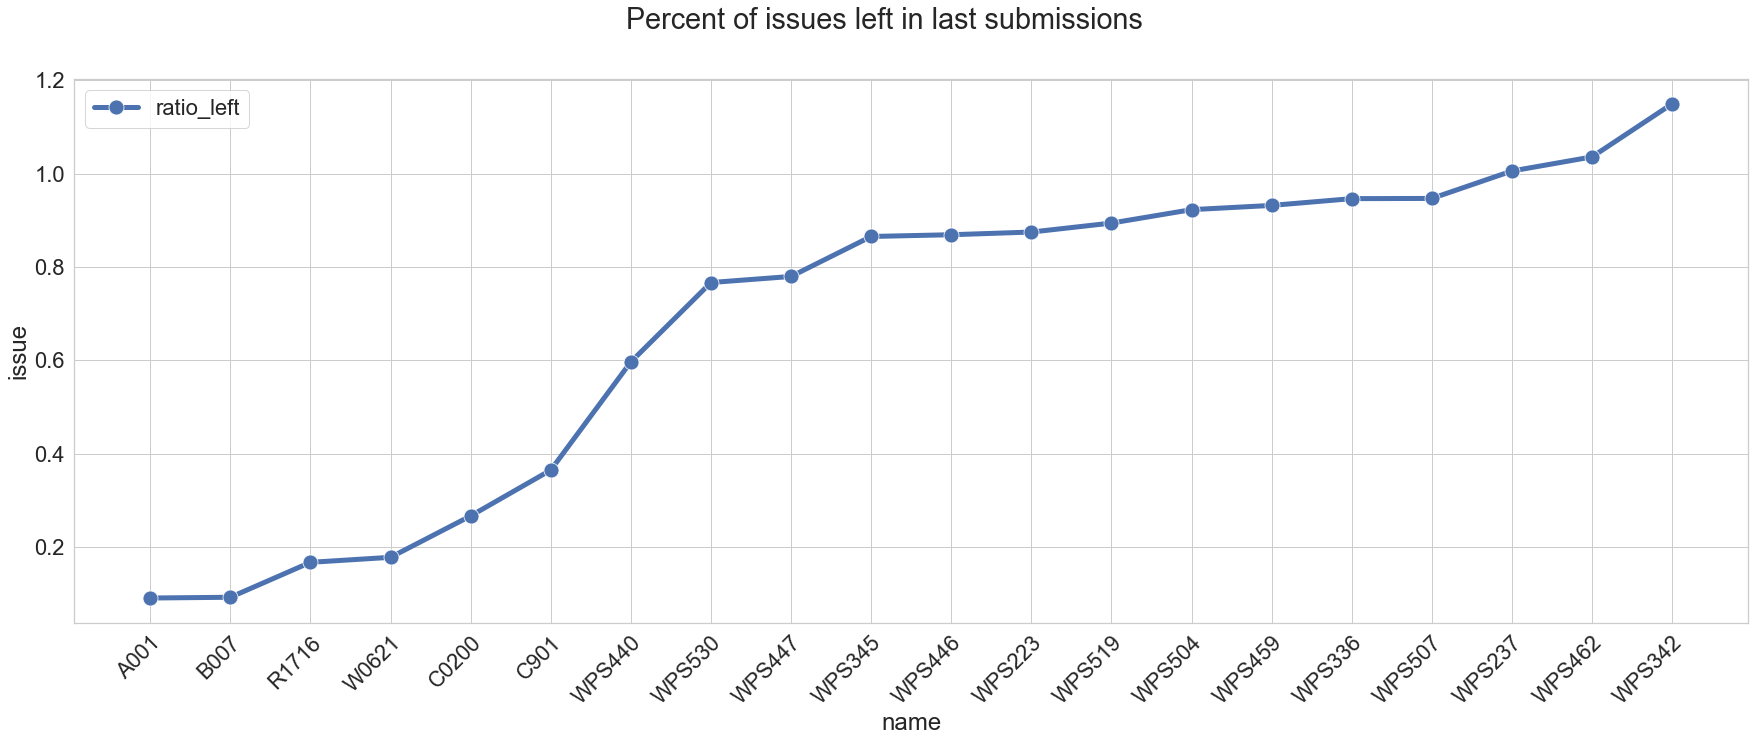

In [137]:
draw_compare(df_first_last_attempt_hyperstyle_issues_top, 
             'name', ['ratio', ['ratio_left']], 
             y_label='issue', 
             title='Percent of issues left in last submissions', 
             save_path=os.path.join(FIRST_LAST_ATTEMPT_STATS_PATH, f'top_issues.pdf'))

# Submission series (groups) analysis
To pass the step user can make several attemps. The ordered sequence of attemps in **submission series**. In this section you can find analysis of the student progess on code quality issues fixing. 

### Number of submission series by total number of attempts in series

In [138]:
df_last_attempt_stats['total_attempts'].value_counts()[:20]

1    1010454
2     105914
3      24917
4       8131
5       3155
Name: total_attempts, dtype: int64

In [139]:
def draw_feature_dynamic(feature: str, max_attempts: int = 5, exact_attempts: bool = False, is_mean=True):
    for attr in ['difficulty', 'complexity', 'client', 'scope']:
        df_dynamic = get_submissions_series_dynamic_by_feature(df_hyperstyle_issues_stats, feature, attr, 
                                                               max_attempts=max_attempts)
#         uncomment to save stats to csv
#         df_dynamic.to_csv(f'{feature}_dynamic_{attr}.csv', index=False)
        draw_compare(df_dynamic, 'attempt', attr, y_label=f'mean\n{feature}', title=f'{feature} dynamic by attemps')

## Average number of hyperstyle issues by each attempt
For all submission series, we calculate mean number of issues made on i-th attempt. The plots show that from attempt to attempt the number of issues in students’ solutions decreases, regardless of the parameters of the student, steps on environment.

`exact_attempts` - if True than only submissions with `total_attempt` == `max_attempts` (so the number of submission for each attempt is equal) are selected othwise `total_attempt` <= `max_attempts` (so the number of submission for each attempt is decreasing)

In [140]:
df_hyperstyle_issues_stats['hyperstyle_issues_count'] = \
    df_hyperstyle_issues_stats[df_hyperstyle_issues_top['name'].values].sum(axis=1)

df_hyperstyle_issues_stats['hyperstyle_issues_count'].value_counts()

0     1189841
1      126279
2       16664
3        6515
4        2323
5        1492
6         717
7         397
11        306
8         190
12        161
10        135
9         119
15         49
16         39
13         30
18         18
24         16
14         15
20         11
17          5
19          5
22          3
26          1
27          1
Name: hyperstyle_issues_count, dtype: int64

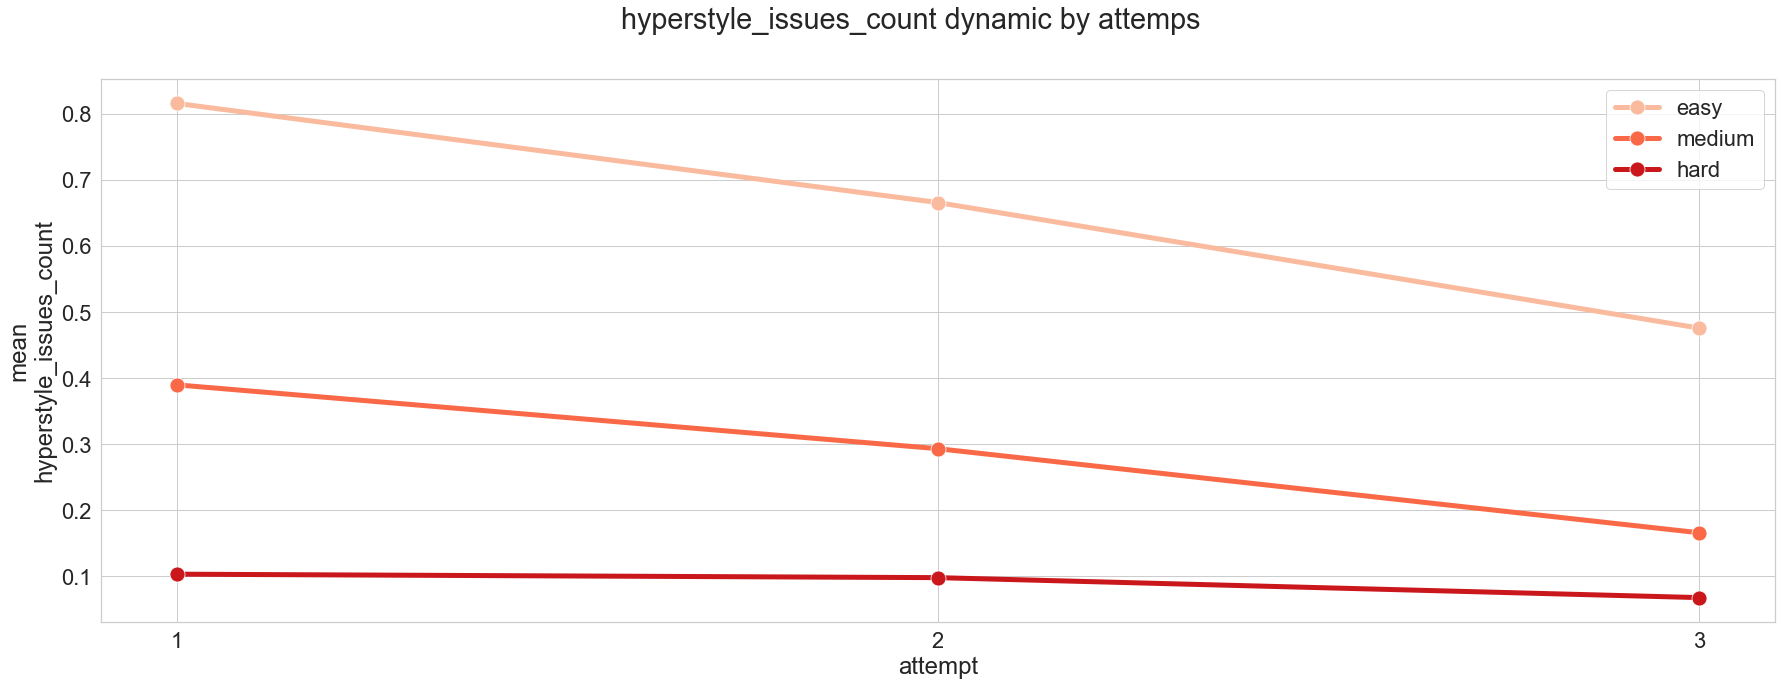

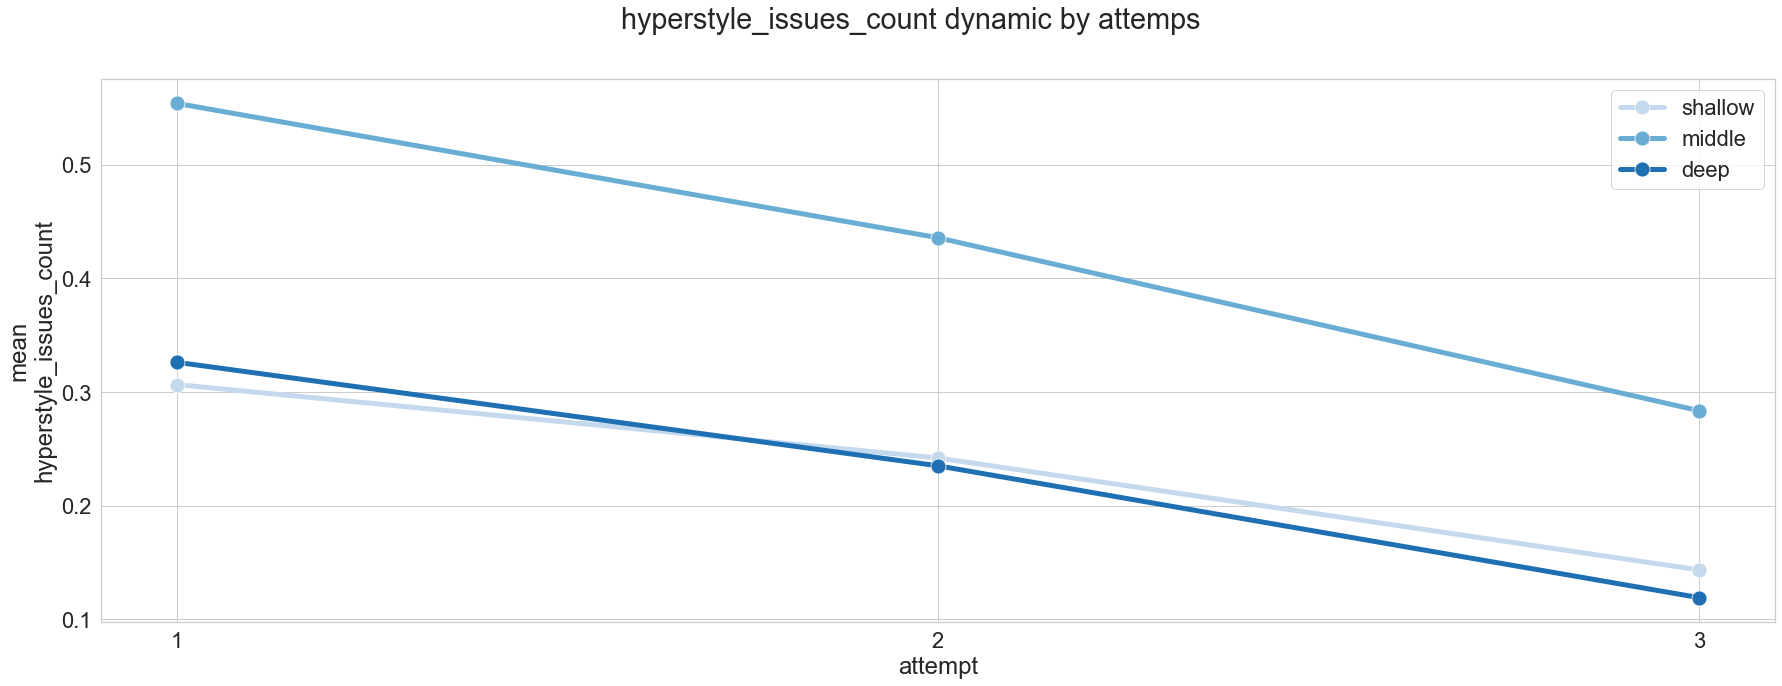

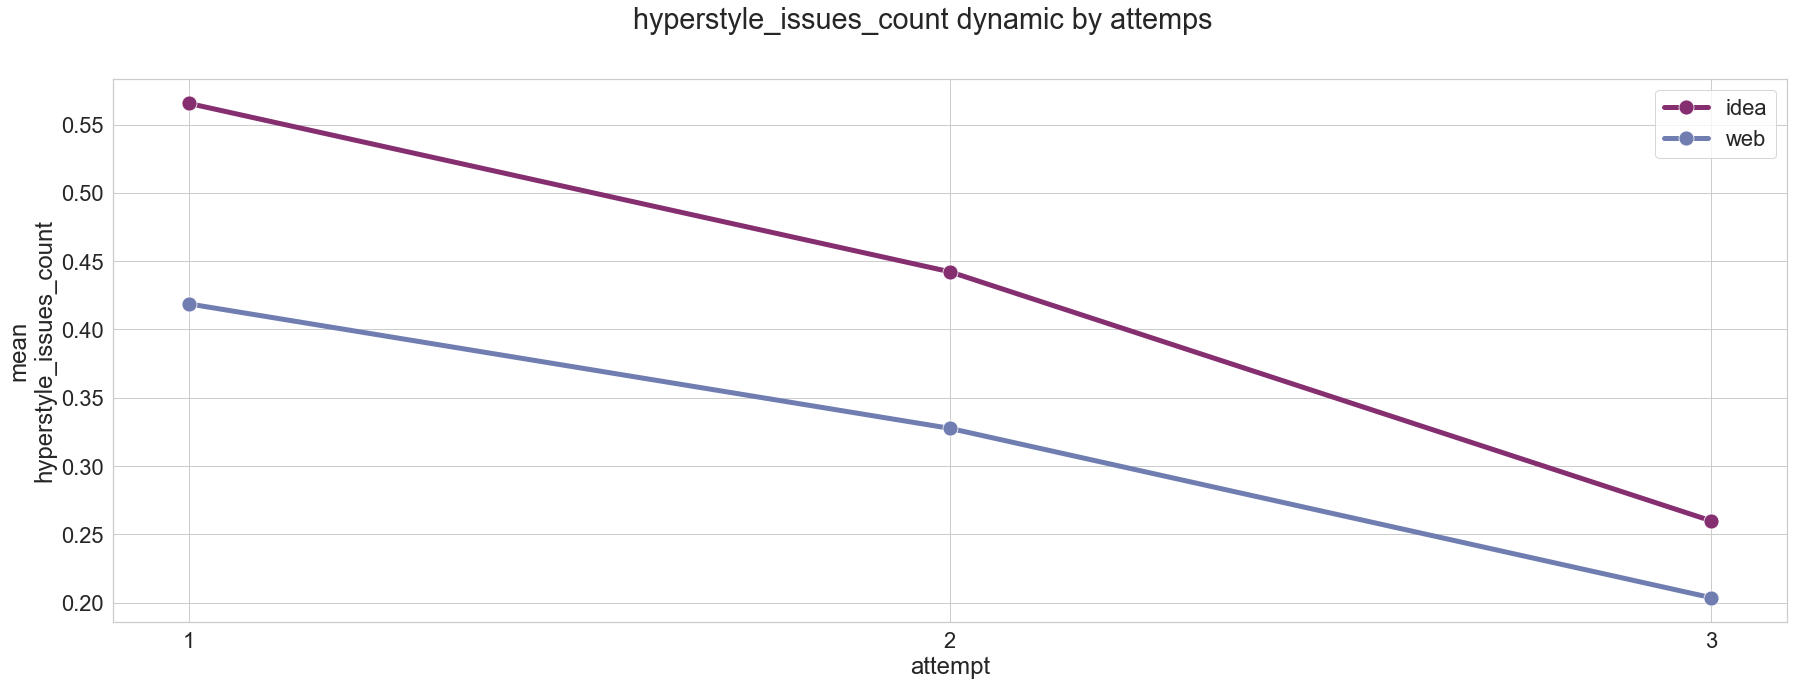

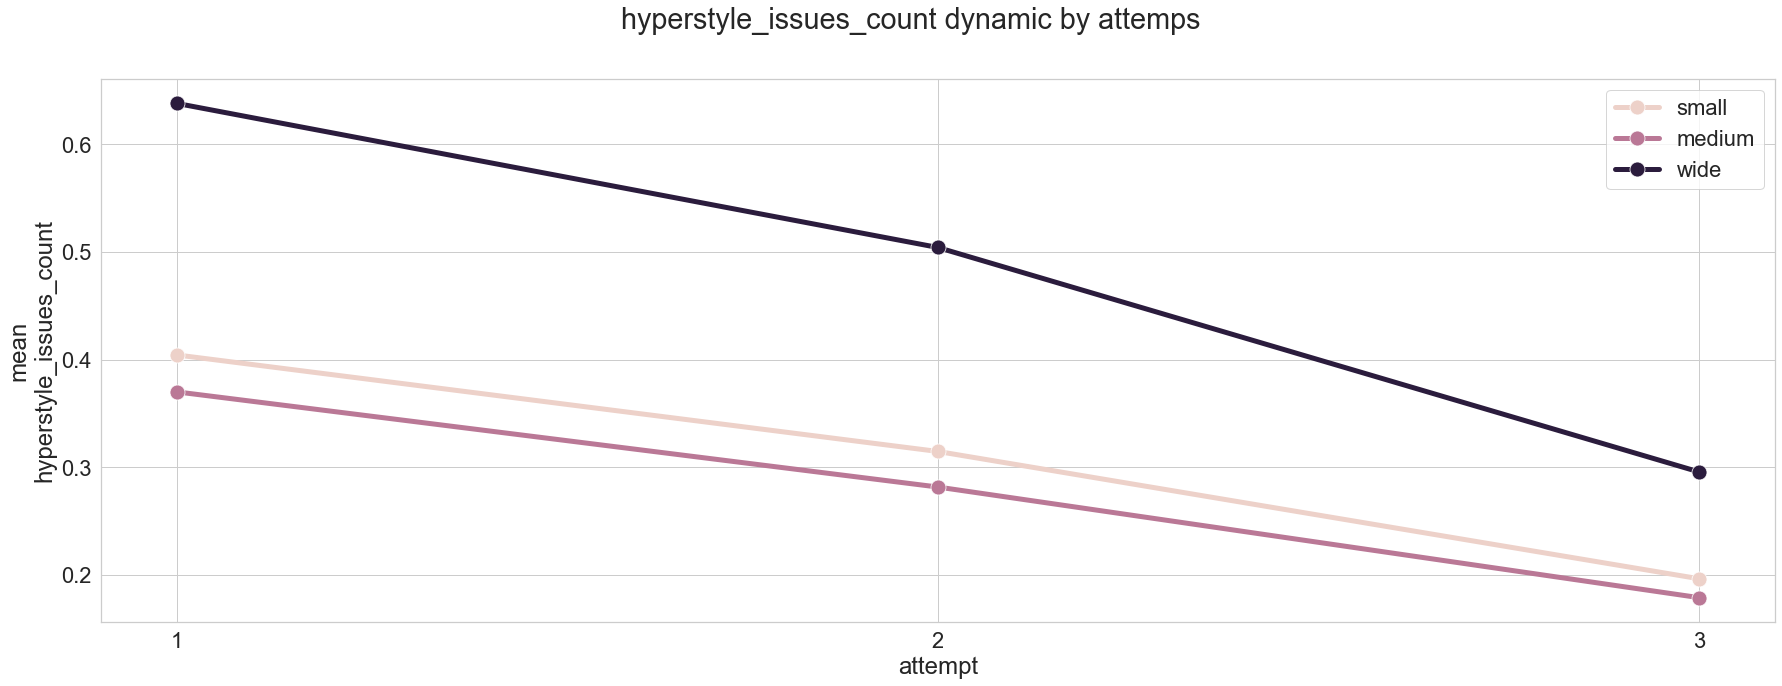

In [141]:
draw_feature_dynamic('hyperstyle_issues_count', max_attempts=3, exact_attempts=True)

## Submissions series dynamic
Plots show how average soution parameters change throught attemps 

### Dynamin for all sobmission series with total_attemps = 5

In [142]:
def draw_issues_dynamic(df: pd.DataFrame, df_issues: pd.DataFrame, max_attempts: int = 5,
                                          exact_attempts: bool = False, by_type=False, is_mean=True):
    df_issues_dynamic = get_submissions_series_issues_dynamic(df, df_issues, max_attempts, exact_attempts, 
                                                              by_type, is_mean)
    suffix = f'{max_attempts}' + ('_by_type' if by_type else '') + ('_exect' if exact_attempts else '')
    
    df_issues_dynamic.drop(columns=['attempt', 'count']).T \
        .to_csv(os.path.join(ISSUES_DYNAMIC_STATS_PATH, f'issues_dynamic_{suffix}.csv'), index=True)
    
    issues = df_issues['category' if by_type else 'name'].unique()
    draw_compare(df_issues_dynamic, 'attempt', ('issue', issues))
    return df_issues_dynamic.drop(columns=['attempt', 'count']).T

### Hypertyle issues dynamic by attempts (with issue names)
Percent of submission which contains each issue by attempts dynamic. The plot shows that in most cases all issues are decreras but it should be examined more precisely in csv file

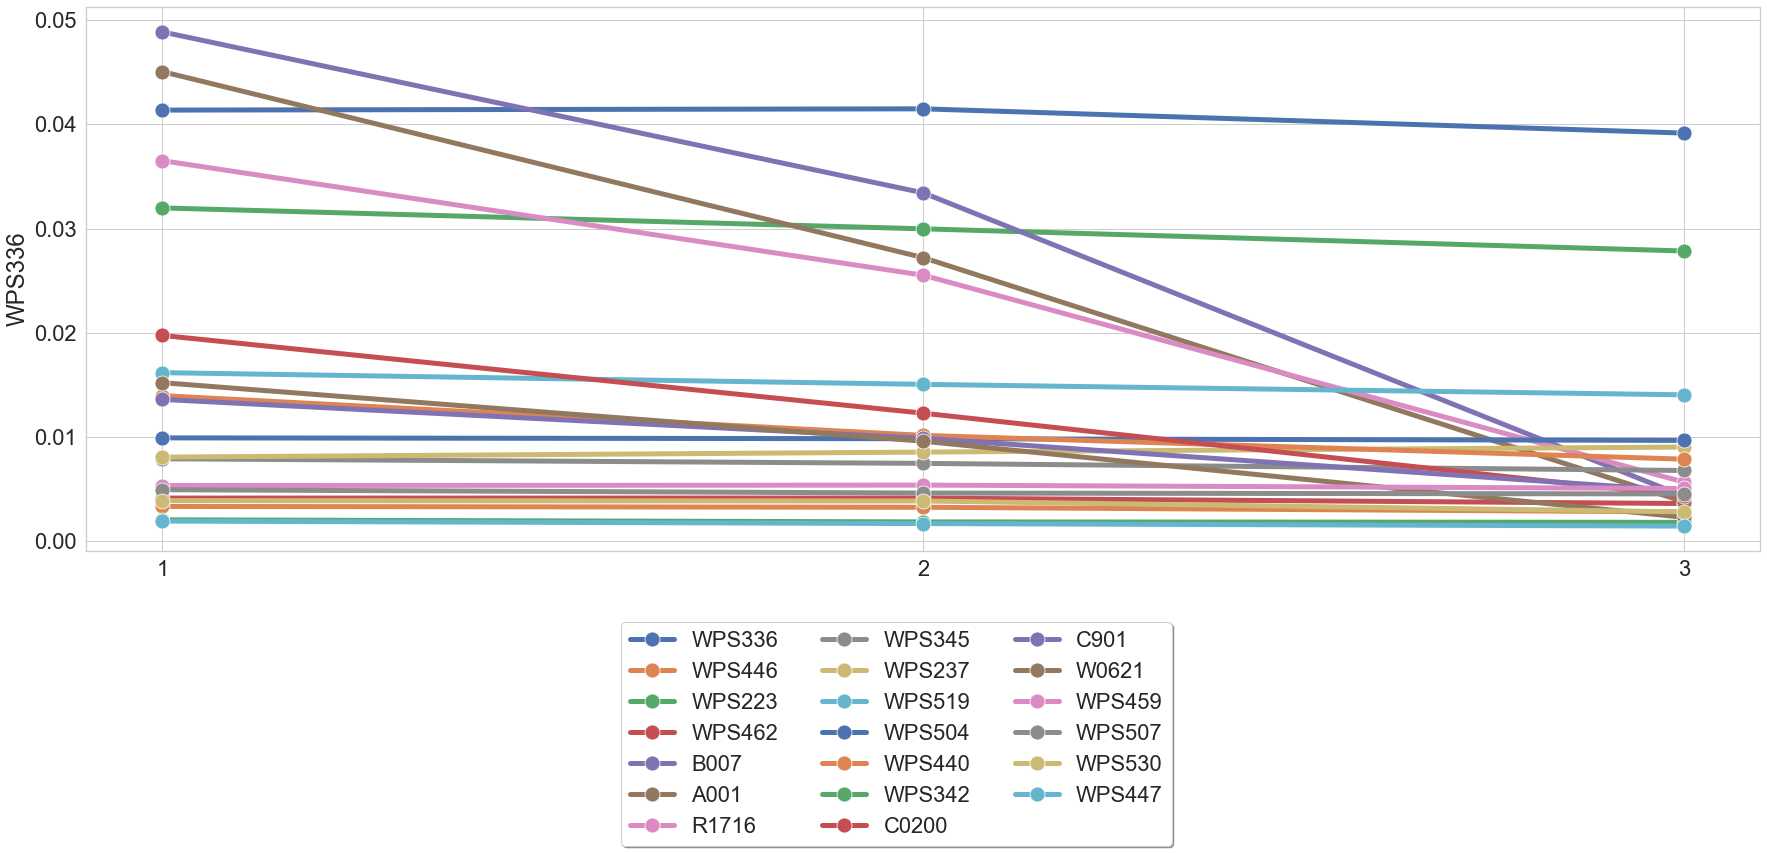

<Figure size 432x288 with 0 Axes>

0         1         2
WPS336  0.041377  0.041498  0.039170
WPS446  0.003331  0.003251  0.002809
WPS223  0.031986  0.029980  0.027852
WPS462  0.004134  0.004134  0.003612
B007    0.048882  0.033431  0.004294
A001    0.045070  0.027210  0.003773
R1716   0.036521  0.025525  0.005659
WPS345  0.007906  0.007465  0.006783
WPS237  0.008067  0.008548  0.009030
WPS519  0.016174  0.015050  0.014047
WPS504  0.009913  0.009833  0.009672
WPS440  0.013966  0.010154  0.007866
WPS342  0.002047  0.001846  0.001806
C0200   0.019746  0.012281  0.004334
C901    0.013605  0.009873  0.004816
W0621   0.015210  0.009592  0.002288
WPS459  0.005338  0.005378  0.005057
WPS507  0.004936  0.004615  0.004535
WPS530  0.003893  0.003853  0.002809
WPS447  0.001926  0.001686  0.001445

In [143]:
draw_issues_dynamic(df_hyperstyle_issues_stats_unique, 
                    df_hyperstyle_issues_top, 
                    max_attempts=3, 
                    exact_attempts=True)

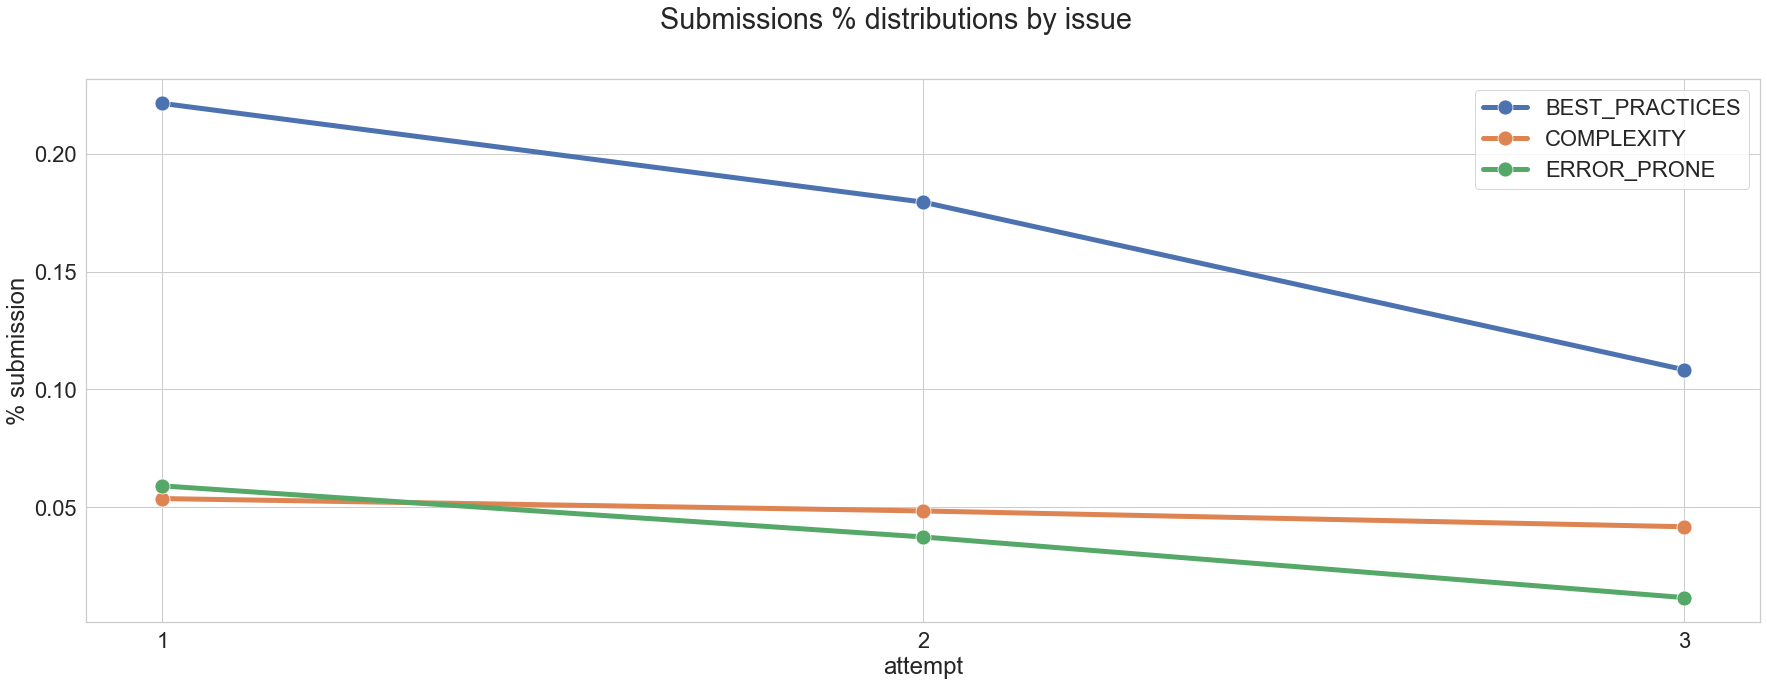

0         1         2
BEST_PRACTICES  0.221335  0.179436  0.108320
COMPLEXITY      0.053658  0.048401  0.041698
ERROR_PRONE     0.059036  0.037364  0.011639

In [144]:
draw_issues_dynamic(df_hyperstyle_issues_stats_unique, 
                    df_hyperstyle_issues_top, 
                    by_type=True, 
                    max_attempts=3, 
                    exact_attempts=True)

In [145]:
df_hyperstyle_issues_stats_unique['hypertysle_issues_count'] = \
    df_hyperstyle_issues_stats_unique[df_hyperstyle_issues_top['name'].values].sum(axis=1)

df_hyperstyle_issues_stats_unique['hypertysle_issues_count'].value_counts()

0    1189841
1     137957
2      14842
3       2523
4        165
5          4
Name: hypertysle_issues_count, dtype: int64

In [179]:
df_submissions_long = pd.read_csv(submissions_file_path)
df_submissions_long = df_submissions_long[df_submissions_long[c] > 5]
df_submissions_long.describe()

id       step_id  sync_counter       user_id         group  \
count  5.920000e+04  59200.000000  59200.000000  59200.000000  5.920000e+04   
mean   4.470242e+07   7486.977297      4.790861  19434.352872  3.275321e+05   
std    8.051793e+06   1572.057364      1.035263  25466.985269  4.916200e+05   
min    2.939506e+07   5205.000000      1.000000    261.000000  3.309000e+03   
25%    3.730144e+07   6467.000000      4.000000   2050.000000  2.697800e+04   
50%    4.702886e+07   6737.000000      5.000000   2050.000000  2.717000e+04   
75%    5.112447e+07   8441.000000      5.000000  47069.000000  5.801120e+05   
max    5.639731e+07  14618.000000     18.000000  81990.000000  1.721576e+06   

            attempt  total_attempts  
count  59200.000000    59200.000000  
mean     300.235760      599.471520  
std      526.178578      860.667703  
min        1.000000        6.000000  
25%        6.000000        8.000000  
50%       76.000000      304.000000  
75%      350.000000      710.000000  
max     3347.000000     3347.000000

In [182]:
print(df_submissions_long[df_submissions_long['total_attempts'] == 3347].shape[0])
df_submissions_long[df_submissions_long['total_attempts'] == 3347]

3347


id  step_id                        time client  sync_counter  \
22867  48279632     6462  2021-04-27 00:26:45.260146   idea             4   
22868  48279642     6462  2021-04-27 00:27:09.462522   idea             4   
22869  48279652     6462  2021-04-27 00:27:31.511271   idea             5   
22870  48279667     6462  2021-04-27 00:28:02.126299   idea             4   
22871  48279678     6462  2021-04-27 00:28:28.308454   idea             4   
...         ...      ...                         ...    ...           ...   
26209  51163501     6462  2021-06-17 18:38:10.459198   idea             5   
26210  51163568     6462  2021-06-17 18:39:19.463613   idea             4   
26211  51163605     6462  2021-06-17 18:39:49.761965   idea             5   
26212  51163629     6462  2021-06-17 18:40:21.136225   idea             6   
26213  51163661     6462  2021-06-17 18:40:57.361237   idea             5   

          lang  \
22867  python3   
22868  python3   
22869  python3   
22870  python3   
22871  python3   
...        ...   
26209  python3   
26210  python3   
26211  python3   
26212  python3   
26213  python3   

                                                                                                      code  \
22867  desk_num1 = (int(input()) + 1) // 2\ndesk_num2 = (int(input()) + 1) // 2\ndesk_num3 = (int(input...   
22868  group1 = int(input())\r\ngroup2 = int(input())\r\ngroup3 = int(input())\r\ngroup1_desks = group1...   
22869  class1 = int(input())\r\nclass2 = int(input())\r\nclass3 = int(input())\r\ndesks_class1 = class1...   
22870  # put your python code here\nclass1_students = int(input())\nclass2_students = int(input())\ncla...   
22871  import math\r\ngroup_1 = int(input())\r\ngroup_2 = int(input())\r\ngroup_3 = int(input())\r\n\r\...   
...                                                                                                    ...   
26209  user_a, user_b, user_c = int(input()), int(input()), int(input())\r\nprint(user_a // 2 + user_a ...   
26210  a = int(input()) / 2 + 0.5\r\nb = int(input()) / 2 + 0.5\r\nc = int(input()) / 2 + 0.5\r\nprint(...   
26211  # put your python code here\r\nclass_1 = int(input())\r\nclass_2 = int(input())\r\nclass_3 = int...   
26212  import math\n\nnum_list = []\nNUM_OF_SEATS = 2\n\nINPUT_BREAKER = 3\ninput_counter = 0\nwhile Tr...   
26213  cls1 = abs(int(input()))\r\ncls2 = abs(int(input()))\r\ncls3 = abs(int(input()))\r\ndesk1 = int(...   

      base_client  user_id  group  attempt  total_attempts  
22867         NaN     2050  26962        1            3347  
22868         NaN     2050  26962        2            3347  
22869         NaN     2050  26962        3            3347  
22870         NaN     2050  26962        4            3347  
22871         NaN     2050  26962        5            3347  
...           ...      ...    ...      ...             ...  
26209         NaN     2050  26962     3343            3347  
26210         NaN     2050  26962     3344            3347  
26211         NaN     2050  26962     3345            3347  
26212         NaN     2050  26962     3346            3347  
26213         NaN     2050  26962     3347            3347  

[3347 rows x 12 columns]

In [184]:
print(df_submissions_long[df_submissions_long['total_attempts'] == 1944].shape[0])
df_submissions_long[df_submissions_long['total_attempts'] == 1944]

1944


id  step_id                        time client  sync_counter  \
27678  32568493     6469  2020-10-04 15:19:23.306250   idea             4   
27679  32568516     6469  2020-10-04 15:19:28.673779   idea             3   
27680  32568525     6469  2020-10-04 15:19:33.381039   idea             4   
27681  32568535     6469  2020-10-04 15:19:38.854751   idea             4   
27682  32568547     6469  2020-10-04 15:19:45.077288   idea             4   
...         ...      ...                         ...    ...           ...   
29617  48980436     6469  2021-05-10 08:41:49.215498   idea             4   
29618  48980442     6469  2021-05-10 08:41:54.824600   idea             4   
29619  48980448     6469  2021-05-10 08:42:01.099215   idea             4   
29620  48980455     6469  2021-05-10 08:42:06.738123   idea             4   
29621  51316019     6469  2021-06-20 13:43:20.085791   idea             4   

          lang  \
27678  python3   
27679  python3   
27680  python3   
27681  python3   
27682  python3   
...        ...   
29617  python3   
29618  python3   
29619  python3   
29620  python3   
29621  python3   

                                                                                                      code  \
27678                                     n = int(input())\nprint((n//100) + ((n % 100)//10) + (n % 10))\n   
27679                                              a = input()\nprint(int(a[0]) + int(a[1]) + int(a[2]))\n   
27680  # put your python code here\ninput_ = input()\noutput = int(input_[0]) + int(input_[1]) + int(in...   
27681  #  Posted from EduTools plugin\ndigits = input()\nsum_digits = 0\n\nfor i in digits:\n    digit ...   
27682                        number = input()\r\nprint(int(number[0]) + int(number[1]) + int(number[2]))\n   
...                                                                                                    ...   
29617  # put your python code here\r\nnum1 = int(input())\r\na = num1 // 100\r\nb = num1 // 10 % 10\r\n...   
29618  three_digit_integer = int(input())\r\n\r\nfirst_digit = three_digit_integer // 100\r\nsecond_dig...   
29619  # put your python code here\r\nnumber = input()\r\ncentena = int(number[0])\r\ndezena = int(numb...   
29620  integer = int(input())\r\nones = integer % 10\r\ntens = (integer // 10) % 10 \r\nhundreds = inte...   
29621                                                 lst = [int(i) for i in input()]\r\nprint(sum(lst))\n   

      base_client  user_id  group  attempt  total_attempts  
27678         NaN     2050  26967        1            1944  
27679         NaN     2050  26967        2            1944  
27680         NaN     2050  26967        3            1944  
27681         NaN     2050  26967        4            1944  
27682         NaN     2050  26967        5            1944  
...           ...      ...    ...      ...             ...  
29617         NaN     2050  26967     1940            1944  
29618         NaN     2050  26967     1941            1944  
29619         NaN     2050  26967     1942            1944  
29620         NaN     2050  26967     1943            1944  
29621         NaN     2050  26967     1944            1944  

[1944 rows x 12 columns]

In [185]:
print(df_submissions_long[df_submissions_long['total_attempts'] == 1739].shape[0])
df_submissions_long[df_submissions_long['total_attempts'] == 1739]

1739


id  step_id                        time client  sync_counter  \
33405  32508131     6549  2020-10-03 20:13:17.295631   idea             5   
33406  32508144     6549  2020-10-03 20:13:25.672348   idea             5   
33407  32508162     6549  2020-10-03 20:13:33.365757   idea             4   
33408  32508168     6549  2020-10-03 20:13:39.252514   idea             5   
33409  32508181     6549  2020-10-03 20:13:47.427053   idea             5   
...         ...      ...                         ...    ...           ...   
35139  52721509     6549  2021-07-12 22:08:56.784254   idea             5   
35140  52721523     6549  2021-07-12 22:09:20.913870   idea             5   
35141  52721558     6549  2021-07-12 22:09:51.516589   idea             4   
35142  52721561     6549  2021-07-12 22:09:58.414373   idea             5   
35143  52721582     6549  2021-07-12 22:10:20.136111   idea             4   

          lang  \
33405  python3   
33406  python3   
33407  python3   
33408  python3   
33409  python3   
...        ...   
35139  python3   
35140  python3   
35141  python3   
35142  python3   
35143  python3   

                                                                                                      code  \
33405  number_of_values = int(input())\n\n\nfor i in range(number_of_values):\n    numbers = int(input(...   
33406  numbers = map(int, [input() for _ in range(int(input()))])\nnumbers = filter(lambda x: x % 7 == ...   
33407  #  Posted from EduTools plugin\nn = int(input())\nm = 0\na = []\nfor i in range(n):\n    x = int...   
33408  lst = []\nfor _ in range(int(input())):\n    x = int(input())\n    if x % 7 == 0:\n        lst.a...   
33409  xs = [int(input()) for x in range(int(input()))]\nfor x in xs:\n    if x % 7 == 0:\n        prin...   
...                                                                                                    ...   
35139  n = int(input())\nnumbers = [int(input()) for _ in range(n)]\nfor number in numbers:\n    if num...   
35140  n = int(input()) \nfor x in range(n):\n    x = int(input())\n    if x % 7 == 0:\n        print(x...   
35141  n = int(input())\n\nfor _ in range(n):\n    integer = int(input())\n    if integer % 7 == 0:\n  ...   
35142  x_loop = int(input())\n\nx_lista = []\n\ncontador = 0\n\nfor _ in range(1, x_loop + 1):\n    y =...   
35143  times = int(input())\nfor i in range(times):\n    x = int(input())\n    if x % 7 == 0:\n        ...   

      base_client  user_id  group  attempt  total_attempts  
33405         NaN     2050  26980        1            1739  
33406         NaN     2050  26980        2            1739  
33407         NaN     2050  26980        3            1739  
33408         NaN     2050  26980        4            1739  
33409         NaN     2050  26980        5            1739  
...           ...      ...    ...      ...             ...  
35139         NaN     2050  26980     1735            1739  
35140         NaN     2050  26980     1736            1739  
35141         NaN     2050  26980     1737            1739  
35142         NaN     2050  26980     1738            1739  
35143         NaN     2050  26980     1739            1739  

[1739 rows x 12 columns]

In [187]:
print(df_submissions_long[df_submissions_long['total_attempts'] == 104]['user_id'].unique())
df_submissions_long[df_submissions_long['total_attempts'] == 104]

[2050]


id  step_id                        time client  sync_counter  \
43591  37236376     7998  2020-11-30 05:53:19.690928   idea             4   
43592  37236382     7998  2020-11-30 05:53:25.650297   idea             4   
43593  37236385     7998  2020-11-30 05:53:30.628152   idea             4   
43594  37236389     7998  2020-11-30 05:53:35.594257   idea             4   
43595  37236393     7998  2020-11-30 05:53:40.656683   idea             4   
...         ...      ...                         ...    ...           ...   
53658  52538522    12683  2021-07-09 21:10:37.241882   idea             4   
53659  52538575    12683  2021-07-09 21:11:26.908273   idea             5   
53660  52538594    12683  2021-07-09 21:11:44.857238   idea             4   
53661  52538606    12683  2021-07-09 21:12:00.281350   idea             4   
53662  52538623    12683  2021-07-09 21:12:19.010384   idea             4   

          lang  \
43591  python3   
43592  python3   
43593  python3   
43594  python3   
43595  python3   
...        ...   
53658  python3   
53659  python3   
53660  python3   
53661  python3   
53662  python3   

                                                                                                      code  \
43591  menu = {"pizza": "Margherita, Four Seasons, Neapolitan, Vegetarian, Spicy", \n        "salad": "...   
43592  def print_itens(type_chosen):\n    if type_chosen == 'salad':\n        print('Caesar salad, Gree...   
43593  order = input().lower()\nvalid_inputs = ['pizza', 'salad', 'soup']\nif order == 'pizza':\n    pr...   
43594  pizza = ['Margherita', 'Four Seasons', 'Neapolitan', 'Vegetarian', 'Spicy']\n\nsalad = ['Caesar ...   
43595  food = {'pizza': 'Margherita, Four Seasons, Neapolitan, Vegetarian, Spicy', \n        'salad': '...   
...                                                                                                    ...   
53658  import re\n\n\n# put your regex in the variable template\ntemplate = r"(\d\d?)(/?|\.?)(\d\d?)(/?...   
53659  import re\n\n\ntemplate = r"(\d{1,2}[./]){2}(\d{4})"\nstring = input()\n\nmatch = re.match(templ...   
53660  import re\n\n\n# put your regex in the variable template\ntemplate = template1 = r'((\d\d?/){2}|...   
53661  import re\n\ntemplate = r"(\d{1,2})[/.](\d{1,2})[/.](\d{4})"\nstring = input()\nmatch = re.match...   
53662  import re\n\n\n# put your regex in the variable template\ntemplate = r"(\d{1,2}[/.]){2}(\d{4})"\...   

      base_client  user_id  group  attempt  total_attempts  
43591         NaN     2050  27101        1             104  
43592         NaN     2050  27101        2             104  
43593         NaN     2050  27101        3             104  
43594         NaN     2050  27101        4             104  
43595         NaN     2050  27101        5             104  
...           ...      ...    ...      ...             ...  
53658         NaN     2050  27367      100             104  
53659         NaN     2050  27367      101             104  
53660         NaN     2050  27367      102             104  
53661         NaN     2050  27367      103             104  
53662         NaN     2050  27367      104             104  

[208 rows x 12 columns]

In [190]:
print(df_submissions_long.shape)
print(df_submissions_long[df_submissions_long['user_id'] != 2050].shape)

(59200, 12)
(23861, 12)


In [200]:
df_submissions_long[df_submissions_long['user_id'] == 2081].groupby(['step_id']).count()

id  time  client  sync_counter  lang  code  base_client  user_id  \
step_id                                                                      
6468     737   737     737           737   737   737            0      737   
6881     405   405     405           405   405   405            0      405   
8076     325   325     325           325   325   325            0      325   
8131      42    42      42            42    42    42            0       42   
8440     348   348     348           348   348   348            0      348   
8921     221   221     221           221   221   221            0      221   
8923     140   140     140           140   140   140            0      140   
9148     561   561     561           561   561   561            0      561   
9149     407   407     407           407   407   407            0      407   
10213     56    56      56            56    56    56            0       56   
10214    106   106     106           106   106   106            0      106   
10215     29    29      29            29    29    29            0       29   
10216     85    85      85            85    85    85            0       85   
14256     18    18      18            18    18    18            0       18   
14590     12    12      12            12    12    12            0       12   
14615      8     8       8             8     8     8            0        8   

         group  attempt  total_attempts  
step_id                                  
6468       737      737             737  
6881       405      405             405  
8076       325      325             325  
8131        42       42              42  
8440       348      348             348  
8921       221      221             221  
8923       140      140             140  
9148       561      561             561  
9149       407      407             407  
10213       56       56              56  
10214      106      106             106  
10215       29       29              29  
10216       85       85              85  
14256       18       18              18  
14590       12       12              12  
14615        8        8               8

In [192]:
df_submissions_long['user_id'].value_counts()

2050     35339
2081      3500
55101      150
27084      147
55706      112
         ...  
49198        6
36920        6
45184        6
67305        6
43029        6
Name: user_id, Length: 2052, dtype: int64